参考: 

https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification

https://www.kaggle.com/code/werus23/g2net-pytorch-with-generated-data

In [1]:
# たまにgpu取れないときあるので取れないときは終わらせる
import torch
if torch.cuda.is_available() == False:
    raise Exception

In [2]:
!nvidia-smi

Mon Dec 19 17:28:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1D:00.0 Off |                    0 |
| N/A   42C    P0    67W / 300W |      3MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# papermill parameters
cfg_optimizer = "adamw" # "sam"
device_ids = [0]
epochs = 15
gradient_accumulation_steps = 1
is_syncBN = False

#lr = 5e-3  # 高すぎるみたい
lr = 4e-4

warmup_t = 3
#warmup_t = 1

min_lr_ratio = 1e-2

weight_decay = 1e-5  # 1e-6にしてもほぼ変わらない
#weight_decay = 1e-6

is_wandb = True
is_wandb = False
n_seeds = 1
cfg_seeds = [0]

cfg_apex = True
#cfg_apex = False  # ampなしにしても変わらず

#BATCH_SIZE = 2
#BATCH_SIZE = 8  # 8にしても16と変わらず学習遅くなるだけ
BATCH_SIZE = 16
#BATCH_SIZE = 32  # 32以降ぐらいからbatch上げるとepochごとのスコア安定しない
#BATCH_SIZE = 64
#BATCH_SIZE = 128
#BATCH_SIZE = 384

load_model_path = "none"
#load_model_path = "/volume/kaggle/g2net2/output/tmp/tmp_fold0_seed0_best_score.pth"
#model_cls = "CustomModel"
#model_cls = "CustomModelDrop"
model_cls = "CustomModelMultiOutput"
#model_cls = "CustomModelMultiInput"
#model_cls = "CustomModelLargeKernel"

# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook
cfg_drop_rate = 0.4
cfg_drop_path_rate = 0.2

#MODEL_NAME = ""
MODEL_NAME = "mobilenetv3_small_050"
#MODEL_NAME = "tf_efficientnetv2_b1"
#MODEL_NAME = "tf_efficientnet_b4_ap"
#MODEL_NAME = "tf_efficientnet_b5_ns"
#MODEL_NAME = "tf_efficientnet_b7_ns"
#MODEL_NAME = "seresnext101d_32x8d"
cfg_pretrained = True

n_fold = 5
#trn_fold = [0,1,2,3,4]
#is_trn_allfold = True
trn_fold = [0]
#trn_fold = "[3]"
is_trn_allfold = False

cfg_scheduler = 'CosineLRScheduler'  # warmup
#cfg_scheduler = 'CosineLRScheduler_cycle_limit3'  # warmup

# data params
cfg_ch = 2
#cfg_step = 64
cfg_step = 128
#cfg_step = 256
#cfg_step = 340
#cfg_step = 512
#cfg_step = 5760
cfg_spec_max = 4096
#cfg_spec_max = 4224  # 33 * 128
#cfg_spec_max = 5760

size_h, size_w = 360, cfg_step
#size_h, size_w = 360, 128
#size_h, size_w = 360, 256

# train+test set stat img  https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-img4096
# np.mean(p.reshape(freq, step, spec_max//step), axis=2)直後の統計値
cfg_p_mean = [2.4080, 2.3525]  # [H1, L1]
cfg_p_std = [0.6578, 0.8358]  # [H1, L1]

#normalize_type = "default-norm|ts-ma"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-max"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|ts-ma|p-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel|p-stand|ts-ma"
#normalize_type = "largekernel"

cfg_is_add_ch = False
cfg_is_train_zip_dataset = False
cfg_prob_mixup = 0.0

#cfg_prob_sample_mixup = 0.0
#cfg_prob_sample_mixup = 0.5
cfg_prob_sample_mixup = 0.8

cfg_is_sample_mixup_use_pseudo = True
#cfg_is_sample_mixup_use_pseudo = False

cfg_prob_add_sample_nega_mixup = 0.0
#cfg_prob_add_sample_nega_mixup = 0.5

#cfg_prob_mean_mixup = 0.0
cfg_prob_mean_mixup = 0.3

#cfg_prob_noise_band = 0.0
cfg_prob_noise_band = 0.3

#cfg_prob_noise_spot = 0.0
cfg_prob_noise_spot = 0.05

#cfg_prob_noise_vline = 0.0
cfg_prob_noise_vline = 0.2

#cfg_prob_noise_hband = 0.0
cfg_prob_noise_hband = 0.2
cfg_prob_noise_hband = 0.5

cfg_prob_spec_start_random = 0.0
#cfg_prob_spec_start_random = 0.5

#cfg_prob_swap_ch_nega = 0.0
cfg_prob_swap_ch_nega = 0.5

#cfg_prob_flip_nega = 0.0
cfg_prob_flip_nega = 0.5

#cfg_prob_swap_nega = 0.0
cfg_prob_swap_nega = 0.5

cfg_prob_vshift_nega = 0.0
#cfg_prob_vshift_nega = 0.5

#cfg_prob_vshift = 0.0
cfg_prob_vshift = 1.0

#cfg_freq_mask_num = 0  # マスクする横線
#cfg_time_mask_num = 0  # マスクする縦線
cfg_freq_mask_num = 2
cfg_time_mask_num = 1
cfg_freq_mask_param = 10
cfg_time_mask_param = 10
#cfg_freq_mask_param = 30
#cfg_time_mask_param = 50

cfg_cv_col = "target"
#cfg_cv_col = "freq_min//10"
#cfg_cv_col = "freq_min//10_target"

cfg_add_split_str = ""
#cfg_add_split_str = "KFold"
#cfg_add_split_str = "StratifiedKFold"

cfg_is_npy = True
#cfg_is_npy = False

FCOFF = 1e22
#FCOFF = 5e22

ADD_DIRS_STR = ""
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL, EX004_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL1, EX005_SIGNAL_ISO1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX003_NOISE2, EX004_SIGNAL, EX004_SIGNAL_ISO, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX006_SIGNAL800]"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

IS_ADD_ALL_TRAIN1 = False
#IS_ADD_ALL_TRAIN1 = True


PSEUDO_CSV = ""
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
#cfg_pseudo_max = 0.0  # pseudoの閾値なし
#cfg_pseudo_min = 0.0  # pseudoの閾値なし
#cfg_is_pseudo_hard = True
cfg_is_pseudo_hard = False

cfg_pseudo_type = ""
#cfg_pseudo_type = "real"
#cfg_pseudo_type = "sim"


ADD_PSEUDO_DIRS = ""
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"


cfg_freq_div_n = 10
#cfg_freq_div_n = 50
#cfg_freq_div_n = 100

cfg_pseudo_sim_max = cfg_pseudo_max
cfg_pseudo_sim_min = cfg_pseudo_min
#cfg_pseudo_sim_max = 0.8
#cfg_pseudo_sim_min = 0.4
#cfg_pseudo_sim_max = 0.0
#cfg_pseudo_sim_min = 0.0

cfg_pseudo_real_max = cfg_pseudo_max
cfg_pseudo_real_min = cfg_pseudo_min

is_matplotlib_agg = False
#is_matplotlib_agg = True  # 可視化なしにする

IS_MAKE_SUB = False
#IS_MAKE_SUB = True

#DEBUG = False
DEBUG = True

# ==============================================================
# kqi_3090_ex075_v2 base Parameters
# ==============================================================
add_name = "_pseudo_multioutput_freq_b5_ap_freq_div_n50"
BATCH_SIZE = 64
MODEL_NAME = "tf_efficientnet_b5_ap"
model_cls = "CustomModelMultiOutput"
epochs = 50
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
cfg_apex = True
cfg_step = 128
size_w = 128
cfg_is_sample_mixup_use_pseudo = True
cfg_add_split_str = "StratifiedKFold"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1

cfg_is_pseudo_hard = False
cfg_freq_div_n = 50
IS_ADD_ALL_TRAIN1 = False
IS_MAKE_SUB = True
n_fold = 5
#is_trn_allfold = True
#DEBUG = False
# ==============================================================

PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"

add_name = ""

In [4]:
# Parameters
add_name = "_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0771.csv"
cfg_pseudo_max = 1.0
cfg_pseudo_min = 0.0
cfg_pseudo_sim_max = 0.0
cfg_pseudo_real_max = -1
epochs = 100
is_trn_allfold = True
is_wandb = True
DEBUG = False


In [5]:
# papermillで引数をlistで渡さなかった場合の対策
if isinstance(device_ids, int):
    device_ids = [0]
    
# trn_foldをpapermillで渡したときの対策
if type(trn_fold) is str:
    trn_fold = eval(trn_fold)
    
# 全fold学習
if is_trn_allfold:
    trn_fold = list(range(n_fold))
    
# 複数seedで学習
if n_seeds > 1:
    cfg_seeds = list(range(n_seeds))
    
# ダウンロードしたデータで事前学習する場合はfold=0のみ
if cfg_is_train_zip_dataset:
    trn_fold = [0]
    
# フラグあればch増やす
if cfg_is_add_ch:
    cfg_ch = 2 + 2 
    
# 移動平均の場合は画像の横幅-1する
if "ts-ma" in normalize_type:
    size_w -= 1
    
# フーリエ係数変える場合
if FCOFF != 1e22:
    normalize_type += f"_{str(FCOFF)}"
    
## largekernelを使う場合
#if "largekernel" in normalize_type:
#    cfg_spec_max = 5760
    
# LargeKernelモデルを使う場合
if model_cls == "CustomModelLargeKernel":
    MODEL_NAME = ""
    cfg_step = 5760
    cfg_spec_max = 5760
    size_h, size_w = 360, cfg_step
    normalize_type = "largekernel"
    cfg_prob_mean_mixup = 0.0
    cfg_prob_spec_start_random = 0.0
    cfg_time_mask_param = int( 10 * (cfg_spec_max / 128) )

In [6]:
#import ipynbname
#NAME = ipynbname.name()
if DEBUG:
    NAME = f"tmp"
    #NAME = f"tmp_real"
    #NAME = f"tmp_no-alb"
    #NAME = f"tmp_VerticalFlip"
    #NAME = f"tmp_HorizontalFlip"
    #NAME = f"tmp_no-alb_EX003_NOISE01"
else:
    NAME = f"kqi_3090_ex075_v2{add_name}"
print(NAME)

kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep


# Directory

In [7]:
import os, sys

if "kaggle_web_client" in sys.modules:
    INPUT_DIR_TRAIN = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    INPUT_DIR_TEST = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"

elif "/work" in os.getcwd():
    INPUT_DIR_TRAIN = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    INPUT_DIR_TEST = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    OUTPUT_DIR = f"/volume/kaggle/g2net2/output/{NAME}"  # HDD
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise_gap5000"  # HDD 5000件
    EX004_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_1"  # HDD 800件
    EX005_SIGNAL_ISO1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_iso_1"  # HDD 800件
    EX006_NOISE1400 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap1400"  # HDD 1400件
    EX006_SIGNAL800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap800"  # HDD 800件
    EX006_SIGNAL_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso800"  # HDD 800件
    EX006_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap5000"  # HDD 5000件
    EX006_SIGNAL2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap2000"  # HDD 2000件
    EX006_SIGNAL_ISO2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso2000"  # HDD 2000件
    EX007_NONSTAT_NOISE800 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary800"  # HDD 800件
    EX007_NONSTAT_NOISE1000 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary1000"  # HDD 1000件
    EX008_SIGNAL_D5075_400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_400"  # HDD 400件
    EX008_SIGNAL_D5075_ISO400 = f"/volume/kaggle/g2net2/pyfstat_output/ex008_generating_signal_d5075_iso400"  # HDD 400件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/volume-ssd/kaggle_g2net2/npys"  # SSD
    

elif "/kqi/output" in os.getcwd():
    INPUT_DIR_TRAIN = f"/workspace/g2net2/input"  # cp_SSD
    INPUT_DIR_TEST = f"/kqi/output/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"
    
    # ============================================
    # 生成データのパス
    # ============================================
    _dir = f"/workspace/g2net2/pyfstat_output/{normalize_type}"
    EX003_NOISE = f"{_dir}/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"{_dir}/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"{_dir}/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"{_dir}/ex003_generating_noise_gap5000"  # SSD 5000件
    EX004_SIGNAL = f"{_dir}/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"{_dir}/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"{_dir}/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"{_dir}/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"{_dir}/ex005_generating_signal_gap_1"  # SSD 800件
    EX005_SIGNAL_ISO1 = f"{_dir}/ex005_generating_signal_gap_iso_1"  # SSD 800件
    EX006_NOISE1400 = f"{_dir}/ex006_generating_noise_gap1400"  # SSD 1400件
    EX006_SIGNAL800 = f"{_dir}/ex006_generating_signal_gap800"  # SSD 800件
    EX006_SIGNAL_ISO800 = f"{_dir}/ex006_generating_signal_gap_iso800"  # SSD 800件
    EX006_NOISE5000 = f"{_dir}/ex006_generating_noise_gap5000"  # SSD 5000件
    EX006_SIGNAL2000 = f"{_dir}/ex006_generating_signal_gap2000"  # SSD 2000件
    EX006_SIGNAL_ISO2000 = f"{_dir}/ex006_generating_signal_gap_iso2000"  # SSD 2000件
    EX007_NONSTAT_NOISE800 = f"{_dir}/ex007_generating_noise_nonstationary800"  # SSD 800件
    EX007_NONSTAT_NOISE1000 = f"{_dir}/ex007_generating_noise_nonstationary1000"  # SSD 1000件
    EX008_SIGNAL_D5075_400 = f"{_dir}/ex008_generating_signal_d5075_400"  # SSD 400件
    EX008_SIGNAL_D5075_ISO400 = f"{_dir}/ex008_generating_signal_d5075_iso400"  # SSD 400件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/workspace/g2net2/pyfstat_output"  # SSD
    
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)

./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep


# Data

In [8]:
import os, sys
import shutil
import cv2
import glob
import random
import h5py
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

pd.set_option('display.max_columns', None)

if is_matplotlib_agg:
    import matplotlib
    matplotlib.use('Agg')
    from matplotlib import pyplot as plt
else:
    from matplotlib import pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2
from src.zip_dataset import ZipDataset
from src import largekernel

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
if cfg_is_train_zip_dataset:
    
    zip_path = f'{INPUT_DIR_TRAIN}/../g2net-generated-signals'
    zip_mod = 100
    zip_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod)
    
    # ZipDatasetのラベルをcsvにしておく
    if os.path.exists(f'{zip_path}/zip_df.csv') == False:
        zip_labels = []
        zip_paths = []
        for i, (img, y) in tqdm(enumerate(zip_dataset), total=len(zip_dataset)):
            y = int(y)
            zip_labels.append(y)
            zip_paths.append(f'{zip_path}/archive/{y}_data_{zip_mod*(1+(i)//zip_mod)}/signals_{i%zip_mod}.npy')
            if i == 14900-1:
                break
        zip_df = pd.DataFrame({"id": range(len(zip_labels)), 
                               "target": zip_labels,
                               "path": zip_paths,
                               "fold": -1,
                              })
        zip_df.to_csv(f'{zip_path}/zip_df.csv', index=False)
        

#train_df = pd.read_csv(INPUT_DIR_TRAIN + '/train_labels.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
train_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/train_summary.csv").rename(columns={"Unnamed: 0":'id'})
train_df["path"] = INPUT_DIR_TRAIN + "/train/" + train_df["id"] + ".hdf5"
train_df = train_df[train_df.target >= 0]  # Remove 3 unknowns (target = -1)
train_df["orig"] = 1  # オリジナルデータのフラグ
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
train_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/train_mean_std.csv").drop(['target'], axis=1)
train_df = pd.merge(train_df, train_ma_img_mean_std, on="id")
print("train_df.shape:", train_df.shape)
#display(train_df)
#print(train_df["freq_min//10"].max(), train_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
train_df["freq_min//N"] = train_df["freq min"] // cfg_freq_div_n
print(train_df["freq_min//N"].max(), train_df["freq_min//N"].min())

#test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
test_df["target"] = 0.5
test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
test_df["orig"] = 1  # オリジナルデータのフラグ
test_df["freq_min//10"] = test_df["freq min"]//10
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
test_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/test_mean_std.csv").drop(['target'], axis=1)
test_df = pd.merge(test_df, test_ma_img_mean_std, on="id")

# リアルデータ/シュミレーションデータを区別するためのタイムスタンプのブロックごとでの標準偏差の差の列を追加
# stddiff == 0 はタイムスタンプのブロックごとでの差がない（=ガウスノイズ）なのでシュミレーションデータ
# https://www.kaggle.com/code/anonamename/g2net2-winning-strategy-with-external-data?scriptVersionId=112011488
df_stat_test = pd.read_csv(f"./kaggle_dl/g2net2-winning-strategy-with-external-data_v1/df_stat_test.csv").drop(['fname'], axis=1)
test_df = pd.merge(test_df, df_stat_test, on="id")

# リアルデータとシュミレーションデータのフラグ
_real_sim_flags = test_df["h1_stddiff"] + test_df["l1_stddiff"]
_real_sim_flags = _real_sim_flags.to_numpy()
test_df["real_sim"] = np.array([1 if _f > 0 else 0 for _f in _real_sim_flags])  # リアルデータ=1,シュミレーションデータ=0
print("test real_sim_flags:")
print(test_df["real_sim"].value_counts())

print("test_df.shape:", test_df.shape)
#display(test_df)
#print(test_df["freq_min//10"].max(), test_df["freq_min//10"].min())

# MultiOutputに使う freq_min//N 列をつくる
test_df["freq_min//N"] = test_df["freq min"] // cfg_freq_div_n
print(test_df["freq_min//N"].max(), test_df["freq_min//N"].min())


train_df.shape: (600, 22)
9.0 1.0
test real_sim_flags:
0    6478
1    1497
Name: real_sim, dtype: int64
test_df.shape: (7975, 29)
10.0 0.0


In [11]:
# ==================================================
# test_dfをリアルデータ/シュミレーションデータだけにする
# ==================================================
if cfg_pseudo_type == "real":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] > 0)].reset_index(drop=True)  #  shape: (1497, xxx)
elif cfg_pseudo_type == "sim":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] == 0)].reset_index(drop=True)  #  shape: (6478, xxx)
print("test_df.shape:", test_df.shape)

test_df.shape: (7975, 30)


In [12]:
# ==================================================
# 学習に使う生成データのパスやラベルをcsvにする
# ==================================================
if ADD_DIRS_STR != "":
    add_df_all = None
    for _add_dir in eval(ADD_DIRS_STR):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
        if "generating_noise" in _add_dir:
            _target = 0
        else:
            _target = 1
        add_df = pd.DataFrame({"path": sorted(glob.glob(f"{_add_dir}/*{_suff}")), 
                               "target": _target})
        add_df["id"] = [Path(p).stem for p in add_df["path"]]
        add_df["sqrtSX"] = add_df["id"].apply(lambda x: x.split("_")[1].split("sqrtSX")[1])
        add_df["F0"] = add_df["id"].apply(lambda x: x.split("_")[2].split("F0")[1])

        if "_signal" in _add_dir:
            add_df["F1"] = add_df["id"].apply(lambda x: x.split("_")[3].split("F1")[1])
            add_df["h0deg"] = add_df["id"].apply(lambda x: x.split("_")[4].split("h0deg")[1])

        add_df["type"] = add_df["id"].apply(lambda x: x.split("_")[-1])

        # どのデータかわかるようにディレクトリの名前残しとく
        add_df["dir_name"] = Path(_add_dir).name

        if "ex003_generating_noise" in _add_dir: 
            # gapデータだけにする
            add_df = add_df[add_df["type"] == "gap"]

            ## segmentデータだけにする
            #add_df = add_df[add_df["type"] != "gap"]
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_df = pd.merge(add_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_df["freq_min//N"] = add_df["freq min"] // cfg_freq_div_n
        print(add_df["freq_min//N"].max(), add_df["freq_min//N"].min())
        
        if add_df is None:
            add_df_all = add_df
        else:
            add_df_all = pd.concat([add_df_all, add_df]).reset_index(drop=True)

    add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_df_all.shape:", add_df_all.shape)
    #display(add_df_all)
    #print(add_df_all["freq_min//10"].value_counts())
    #print(add_df_all["freq_min//10"].max(), add_df_all["freq_min//10"].min())

9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
9.0 1.0
add_df_all.shape: (8400, 24)


In [13]:
pseudo_df = pd.read_csv(PSEUDO_CSV)
pseudo_df.sort_values("target")

id    target
3283  698567d90  0.101208
4164  851d75528  0.199860
925   1e85f128e  0.206511
2153  44dd7e761  0.206812
5106  a474bef22  0.207187
...         ...       ...
1005  211108cc0  0.998498
5230  a8aaa9755  0.998518
1310  2a180c12a  0.998548
1522  3022e8994  0.998618
5975  bf3baa13d  0.998672

[7975 rows x 2 columns]

9.0 0.0


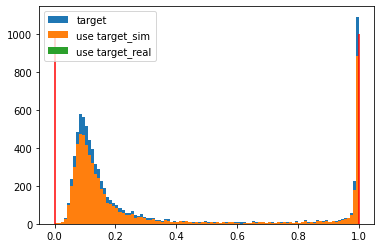

pseudo_df.shape: (6478, 30)


In [14]:
# ==================================================
# for Pseudo
# ==================================================
from sklearn.preprocessing import MinMaxScaler

if PSEUDO_CSV != "":
    pseudo_df = pd.read_csv(PSEUDO_CSV)
    pseudo_df["path"] = INPUT_DIR_TEST + "/test/" + pseudo_df["id"] + ".hdf5"
    #display(pseudo_df)
    
    # 最小値に外れ値があるのでclip
    pseudo_df["target"] = np.clip(pseudo_df["target"], 0.2, None)
    
    pseudo_df = pd.merge(pseudo_df, test_df[["id", "real_sim"]], on="id")
    
    # 確信度0-1に正規化
    pseudo_df["target"] = MinMaxScaler().fit_transform(pseudo_df["target"].values.reshape(-1, 1))
    #display(pseudo_df)
    
    # 分布可視化
    plt.hist(pseudo_df["target"], bins=100, label="target")
    
    p_sim_df = pseudo_df[pseudo_df["real_sim"] == 0].copy()
    p_real_df = pseudo_df[pseudo_df["real_sim"] == 1].copy()
    
    # 確信度が高い低いものだけ採用。0なら全部入れる
    if cfg_pseudo_max > 0:
        pseudo_df = pseudo_df[ (pseudo_df["target"] > cfg_pseudo_max) | (pseudo_df["target"] < cfg_pseudo_min) ].reset_index(drop=True)
        #display(pseudo_df)
        
    # simデータが高い低いものだけ採用
    if cfg_pseudo_sim_max > 0:
        p_sim_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_sim_max) | (p_sim_df["target"] < cfg_pseudo_sim_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_sim_df]).drop_duplicates()
    elif cfg_pseudo_sim_max == -1:
        # -1なら追加なし
        pass
        
    # realデータが高い低いものだけ採用
    if cfg_pseudo_real_max > 0:
        p_real_df = p_sim_df[ (p_sim_df["target"] > cfg_pseudo_real_max) | (p_sim_df["target"] < cfg_pseudo_real_min) ].reset_index(drop=True)
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == 0:
        # 0なら全部入れる
        pseudo_df = pd.concat([pseudo_df, p_real_df]).drop_duplicates()
    elif cfg_pseudo_real_max == -1:
        # -1なら追加なし
        pass
        
    # ハードラベルにする
    if cfg_is_pseudo_hard:
        pseudo_df.loc[pseudo_df["target"] >= 0.5, "target"] = 1
        pseudo_df.loc[pseudo_df["target"] < 0.5, "target"] = 0
        pseudo_df["target"] = pseudo_df["target"].astype(int)
        #display(pseudo_df)
        print("pseudo_df['target'].value_counts():")
        print(pseudo_df["target"].value_counts())
        pseudo_df.target.plot.hist()
        plt.show()
        
    # test setと同じサイズに変更
    pseudo_df = pd.merge(pseudo_df[["id", "target"]], test_df.drop("target", axis=1), on="id").reset_index(drop=True)
    
    # MultiOutputに使う freq_min//N 列をつくる
    pseudo_df["freq_min//N"] = pseudo_df["freq min"] // cfg_freq_div_n
    print(pseudo_df["freq_min//N"].max(), pseudo_df["freq_min//N"].min())
    
    # 分布可視化
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==0, "target"], bins=100, label="use target_sim")
    plt.hist(pseudo_df.loc[pseudo_df["real_sim"]==1, "target"], bins=100, label="use target_real")
    plt.vlines(cfg_pseudo_max, 0, 1000, colors="red")
    plt.vlines(cfg_pseudo_min, 0, 1000, colors="red")
    plt.legend()
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()
    
    pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("pseudo_df.shape:", pseudo_df.shape)
    #display(pseudo_df)
    #print(pseudo_df["freq_min//10"].value_counts())
    #print(pseudo_df["freq_min//10"].max(), pseudo_df["freq_min//10"].min())

In [15]:
# ==================================================
# for Pseudo 追加
# ==================================================
if ADD_PSEUDO_DIRS != "":
    
    add_pseudo_df = None
    for _add_dir in eval(ADD_PSEUDO_DIRS):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
    
        _add_df = pd.read_csv(_add_dir + "/df.csv")
        _add_df["path"] = _add_dir + "/" + _add_df["id"] + _suff
        
        if add_pseudo_df is None:
            add_pseudo_df = _add_df
        else:
            add_pseudo_df = pd.concat([add_pseudo_df, _add_df]).reset_index(drop=True)
            
        # df_summary.csv 連結
        _sum_df = pd.read_csv(f"{_add_dir}/df_summary.csv").drop("target", axis=1)
        add_pseudo_df = pd.merge(add_pseudo_df, _sum_df, on="id")

        # MultiOutputに使う freq_min//N 列をつくる
        add_pseudo_df["freq_min//N"] = add_pseudo_df["freq min"] // cfg_freq_div_n
        print(add_pseudo_df["freq_min//N"].max(), add_pseudo_df["freq_min//N"].min())

    add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_pseudo_df.shape:", add_pseudo_df.shape)
    #display(add_pseudo_df)
    #print(add_pseudo_df["freq_min//10"].value_counts())
    #print(add_pseudo_df["freq_min//10"].max(), add_pseudo_df["freq_min//10"].min())

9.0 1.0
add_pseudo_df.shape: (796, 18)


In [16]:
#=====

In [17]:
if cfg_spec_max == 4096:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd/notebook?scriptVersionId=109593703
    # shape: (360, 4096)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 4279:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-spec-max4279?scriptVersionId=110466908
    # shape: (360, 4279)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 5760:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-largekernel-abs?scriptVersionId=111603297
    # shape: (360, 5760)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値


In [18]:
# ====================================================================================
# 前処理の helper 関数
# ====================================================================================
def get_cut_ids(ts, step: int):
    """同程度の時間幅になるタイムスタンプのインデックスを取得"""
    full_length = ts.max() - ts.min() + 1
    cut_length = full_length // step  # この時間単位でidx取得する
    cut_ids = [0] 
    _store = 0
    for i in range(1, len(ts)):
        _store += ts[i] - ts[i-1]
        if _store > cut_length:
            cut_ids.append(i)
            _store = 0
    if cut_ids[-1] != len(ts) - 1:
        cut_ids += [len(ts) - 1] 
    return cut_ids  # リストの長さはstepより少ないので注意すること


def standardization(x , mu: float, std: float, max_pixel_value=None):
    """標準化"""
    if max_pixel_value is None:
        return (x - mu) / std
    else:
        # https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize
        return (x - mu * max_pixel_value) / (std * max_pixel_value)

    
def a2p(a):
    """振幅をパワーに変換"""
    a = a[:,:]
    a = a * FCOFF
    #a = a * 1e22  # Fourier coefficient complex64  # 正規化しない場合ではこの係数だと振幅大きいデータでnanになる
    #a = a * 1e21
    #a = a * 1e20  # 振幅低くなりすぎて精度でない
    p = a.real**2 + a.imag**2  # power. shape=(360, 4224など)
    return p


def power_norm(p, norm_type: str, s: str = ""):
    """パワーを正規化"""
    if "p-norm" in norm_type:
        # normalize
        p /= np.mean(p)
    elif "p-stand" in norm_type:
        # チャネルごとの平均と標準偏差で標準化
        p = standardization(p, p.mean(), p.std())
    elif "p-common-stand" in norm_type:
        # データセット全体の統計値で標準化
        if s == "H1":
            p = standardization(p, cfg_p_mean[0], cfg_p_std[0])
        else:
            p = standardization(p, cfg_p_mean[1], cfg_p_std[1])
    elif "p-max" in norm_type:
        # 最大値で割って0-1にする
        p /= np.max(p)
        # MinMaxScaler
        #p = MinMaxScaler().fit_transform(p)
    elif "p-robustscaler" in norm_type:
        # RobustScaler
        p = RobustScaler().fit_transform(p)
    return p


def power_a_comp(p, step: int, spec_max: int, freq: int, norm_type: str):
    """パワーをtimestepsごとに平均+resizeして圧縮する"""
    if "ts-ma" in norm_type:
        ### timestepsごとに移動平均. compress 4096 -> 127
        
        # https://www.kaggle.com/anonamename/g2net2-exporing-test-train-datasets
        n_ma = spec_max//step

        # 累積合計を計算。 np.cumsum(np.array([1, 2, 3, 4, 5, 6])): [ 1  3  6 10 15 21]
        power_ma_cumsum = np.cumsum(p, axis=1)  

        # 累積合計をMA個の要素ごとの平均とる
        power_ma_cumsum_0 = np.concatenate((np.zeros((p.shape[0],1)), power_ma_cumsum), axis=1)[:,::n_ma]  

        # 累積合計を平均で引き算。numpy.diff() は受け取った配列の隣り合う要素同士の差分をとる
        p = np.diff(power_ma_cumsum_0, axis=1)[:,:-1]/n_ma  
        
    elif "ts-a" in norm_type:
        # timestepsごとに平均. compress 4096 -> 128
        p = np.mean(p.reshape(freq, step, spec_max//step), axis=2)
        
    return p

def power_img_clip(img):
    """
    H1とL1でパワーの最大値が違いすぎる画像はノイズっぽいので、最大値が小さい方のチャネルを基準にして最大値大きい方のチャネルの値をクリッピングする
    """
    #th_max = 1.5
    th_max = 2.0
    th_clip = 1.25
    #print(np.max(img[0]), np.max(img[1]))
    if (np.max(img[0]) > np.max(img[1])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[0] = np.clip(img[0], None, np.max(img[1])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[0][img[0] == np.max(img[1])*th_clip]  # クリッピング部分
        _x_other = img[0][img[0] != np.max(img[1])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[0][img[0] == np.max(img[1])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[0] = RobustScaler().fit_transform(img[0])
        
    if (np.max(img[1]) > np.max(img[0])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[1] = np.clip(img[1], None, np.max(img[0])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[1][img[1] == np.max(img[0])*th_clip]  # クリッピング部分
        _x_other = img[1][img[1] != np.max(img[0])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[1][img[1] == np.max(img[0])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[1] = RobustScaler().fit_transform(img[1])

    return img

# ====================================================================================
# 前処理のメイン関数
# ====================================================================================
def amp2power(a, s, step, spec_max, norm_type, freq, ts=None):
    """振幅をパワーに変換して前処理も実行するメイン関数"""
    
    if "spec-sequence_a" in norm_type:
        ### gap区切りでパワーを圧縮してから正規化
        # 振幅をパワーに変換
        p = a2p(a)

        # 1つ隣のタイムポイントで引き算して+1800。基本の間隔は1800なので連続して計測してる場合は0になる
        gap_length = ts[1:] - (ts[:-1] + 1800)  

        # 隣接データでタイムポイントが0以上になった1800以上空いてるデータ点のインデックスのリスト
        gap_length_nonzero_idx = np.argwhere(gap_length != 0).flatten()
        #gap_length_nonzero_idx = gap_length_nonzero_idx[::2]  # 1つ飛ばしでidx取る場合

        # gapがある時刻区切りで平均化
        p_sequence_a = np.empty((freq, len(gap_length_nonzero_idx)+1), dtype=np.float32)
        s_idx = 0
        for i, e_idx in enumerate(gap_length_nonzero_idx):
            #print(i, s_idx, e_idx, np.mean(p[:,s_idx:e_idx], axis=1).shape, p_sequence_a[:,i].shape)
            p_sequence_a[:,i] = np.mean(p[:,s_idx:e_idx], axis=1)
            s_idx = e_idx
        if e_idx != len(gap_length_nonzero_idx)-1:
            p_sequence_a[:,-1] = np.mean(p[:,e_idx:], axis=1)

        # 後続処理のためstep単位のサイズにしておく
        spec_max = step*(p_sequence_a.shape[1]//step)
        p = p_sequence_a[:,:spec_max]
    
        p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        p = power_norm(p, norm_type, s=s)  # パワーを正規化
        
    else:
        if "default-norm" in norm_type:
            ### パワーを正規化してから圧縮(public NBの前処理)
            p = a2p(a)  # 振幅をパワーに変換
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        else:
            ### パワーを圧縮してから正規化
            p = a2p(a)  # 振幅をパワーに変換
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            
    return p


# https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification
def hdf5_to_img(h_path, step, spec_max, 
                norm_type=normalize_type, 
                ch=2, 
                freq=360,
               ):
    """hdf5ファイルロードしてパワーの画像に変換する"""
    
    if "largekernel" in norm_type:
        # publicNBの前処理
        # https://www.kaggle.com/code/laeyoung/g2net-large-kernel-inference/notebook
        if "p-robustscaler" in norm_type:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=True)
        else:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=False)
        ps = largekernel.preprocess(1, power, h1_m, l1_m, is_cuda=False, is_tta=True)[0]
        
        ## パワー圧縮前に外れ値クリッピング
        #if "clip" in norm_type:
        #    ps = power_img_clip( np.stack([ ps[0], ps[1] ] ) )
        
        p_h1 = power_a_comp(ps[0], step, 5760, freq, norm_type)  # パワーを圧縮
        p_l1 = power_a_comp(ps[1], step, 5760, freq, norm_type)  # パワーを圧縮
        img = np.stack([ p_h1, p_l1 ] ).astype(np.float32)
        
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
        return img
    
    file_id = Path(h_path).stem
    img = None
    with h5py.File(h_path, 'r') as f:
        g = f[file_id]
        
        a_h1, ts_h1 = g["H1"]['SFTs'][:], g["H1"]['timestamps_GPS'][:]
        a_l1, ts_l1 = g["L1"]['SFTs'][:], g["L1"]['timestamps_GPS'][:]
        
        ## 振幅の外れ値クリッピング
        #if "clip" in norm_type:
        #    a_clip = power_img_clip( np.stack([ a_h1, a_l1 ] ) )
        #    a_h1, a_l1 = a_clip[0], a_clip[1]
        
        if "same_ts_interval" in norm_type:
            ### H1,L1のズレを軽減するために、同じ時間間隔でパワーを平均してから正規化
            
            # 同程度の時間幅になるタイムスタンプのインデックスを取得
            h1_cut_ids = get_cut_ids(ts_h1, step+10)  # stepより小さくなるから大きめに取る
            l1_cut_ids = get_cut_ids(ts_l1, step+10)  # stepより小さくなるから大きめに取る
            #print(len(ts_h1), h1_cut_ids)
            #print(len(ts_l1), l1_cut_ids)
            
            # サイズ揃える
            n_min = min(len(h1_cut_ids), len(l1_cut_ids))
            img = np.empty((ch, freq, n_min-1), dtype=np.float32)
            p_h1 = a2p(a_h1)
            p_l1 = a2p(a_l1)
            for i in range(1, n_min):
                img[0,:,i-1] = np.mean(p_h1[:,h1_cut_ids[i-1]:h1_cut_ids[i]], axis=1)  # パワーを圧縮
                img[1,:,i-1] = np.mean(p_l1[:,l1_cut_ids[i-1]:l1_cut_ids[i]], axis=1)  # パワーを圧縮
            img[0] = power_norm(img[0], norm_type, s="H1")  # パワーを正規化
            img[1] = power_norm(img[1], norm_type, s="L1")  # パワーを正規化
            if "ts-ma" in norm_type:
                img = img[:,:,:step-1]
            else:
                img = img[:,:,:step]
            #print(img.shape)
            
        else:
            ### 振幅をパワーに変換
            p_h1 = amp2power(a_h1, "H1", step, spec_max, norm_type, freq, ts=ts_h1)
            p_l1 = amp2power(a_l1, "L1", step, spec_max, norm_type, freq, ts=ts_l1)
            # サイズ揃える
            min_len = min(p_h1.shape[1], p_l1.shape[1])
            img = np.stack([ p_h1[:,:min_len], p_l1[:,:min_len] ] ).astype(np.float32)
            
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
    return img

# Quick EDA

In [19]:
def show_1img_2ch(img):
    
    if normalize_type == "default_3ch":
        plt.figure(figsize=(20, 12))
        
        for i in range(img.shape[0]):
            plt.subplot(1, 6, i+1)
            plt.title('Spectrogram')
            plt.xlabel('time')
            plt.ylabel('frequency')
            plt.imshow(img[i])
            plt.colorbar()
            
        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()
    else:
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.title('H1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[0])
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('L1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[1])
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

In [20]:
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#
#print()
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    pass
#print(_path)
#img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
#                  norm_type=normalize_type, 
#                  ch=cfg_ch, 
#                  freq=360)
#print("img.max(), img.min():", img.max(), img.min())
#print("img.shape:", img.shape)
#print("y:", test_df.iloc[806]["target"])
#show_1img_2ch(img)
#print(img)

=> train label dist
1    400
0    200
Name: target, dtype: int64

=> train+test SFTs w
H1 SFTs w max(), min() 4887.0 4281.0
L1 SFTs w max(), min() 4878.0 4279.0

=> normalize_type: largekernel|p-robustscaler|ts-ma|clip
/workspace/g2net2/input/train/02887d232.hdf5
img.max(), img.min(): 0.98969114 -0.22172987
img.shape: (2, 360, 127)
y: 1


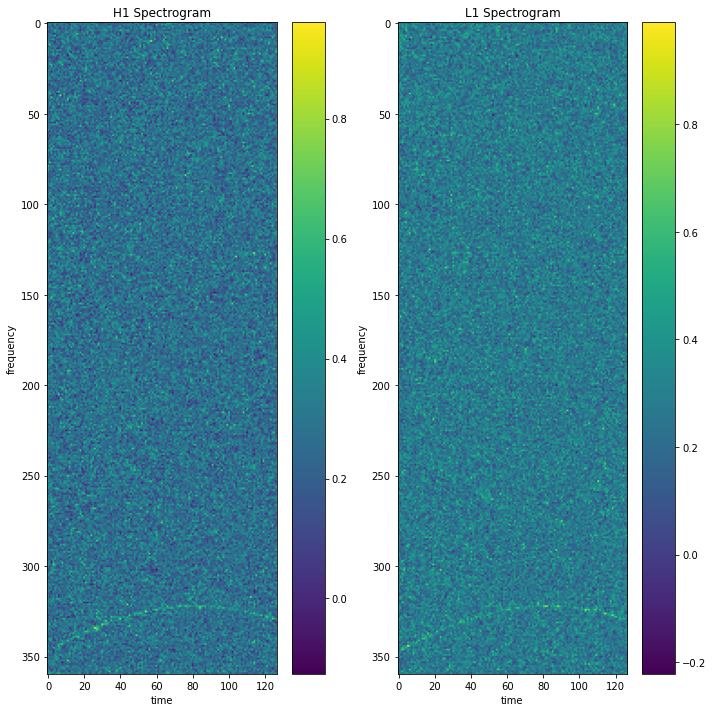

[[[0.32137838 0.16709663 0.3396818  ... 0.2626709  0.16461588 0.33100587]
  [0.2796943  0.42580783 0.2305968  ... 0.24144965 0.21867134 0.19973686]
  [0.10598349 0.26031205 0.2768124  ... 0.31672364 0.25243327 0.17542046]
  ...
  [0.29478994 0.30845058 0.02045513 ... 0.11102973 0.16875271 0.2889133 ]
  [0.34369513 0.405669   0.14893036 ... 0.39067653 0.31222874 0.04446886]
  [0.5159495  0.4887962  0.46702778 ... 0.2906223  0.36319172 0.30029297]]

 [[0.2062395  0.25594217 0.16885151 ... 0.286084   0.30238986 0.2612359 ]
  [0.5633493  0.30675367 0.44855195 ... 0.54641384 0.31243488 0.29295248]
  [0.25015137 0.25780466 0.48412102 ... 0.21490614 0.455306   0.30906305]
  ...
  [0.17517394 0.23172304 0.09281849 ... 0.2023736  0.28980306 0.21325955]
  [0.09962162 0.36566085 0.59807014 ... 0.36415744 0.1765435  0.43141547]
  [0.19821659 0.31826773 0.24057066 ... 0.21809082 0.47255045 0.3749376 ]]]

/kqi/output/g2net-detecting-continuous-gravitational-waves/test/0040fc1b3.hdf5
img.max(), img.m

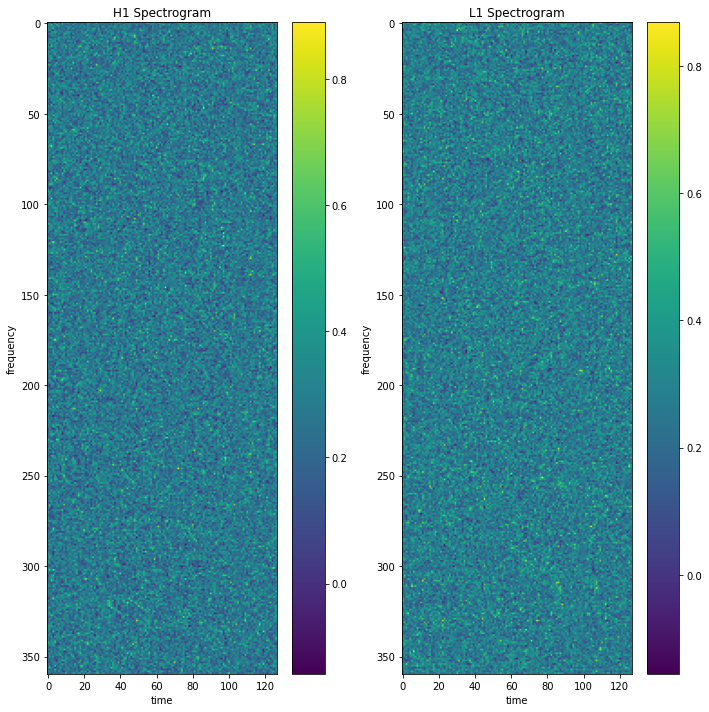

[[[0.07834371 0.41518974 0.03453428 ... 0.23158908 0.2986681  0.49482423]
  [0.45246527 0.32034603 0.59245676 ... 0.5081516  0.02925076 0.3297065 ]
  [0.30939502 0.34769353 0.28063354 ... 0.44695637 0.12244195 0.32932943]
  ...
  [0.17960311 0.09485427 0.2805743  ... 0.1812473  0.01590441 0.39879286]
  [0.33128324 0.3680573  0.30641037 ... 0.48501247 0.35853678 0.22712402]
  [0.18181036 0.33756462 0.08119549 ... 0.37087673 0.13703342 0.20791557]]

 [[0.44172123 0.36036965 0.18234669 ... 0.22356771 0.17934841 0.10755751]
  [0.3358819  0.3496892  0.23140924 ... 0.39707303 0.3277832  0.19452311]
  [0.5118028  0.20131297 0.36369485 ... 0.41187608 0.09545356 0.12684733]
  ...
  [0.2333712  0.3125624  0.30231085 ... 0.36914062 0.38469508 0.15664333]
  [0.1603819  0.33288157 0.4104267  ... 0.07677138 0.30295953 0.24770778]
  [0.145895   0.23965636 0.3157245  ... 0.34230414 0.37783474 0.2713596 ]]]


In [21]:
print("=> train label dist")
print(train_df.target.value_counts())
print()

print("=> train+test SFTs w")
_df = pd.concat([train_df, test_df])
print("H1 SFTs w max(), min()", _df["H1 SFTs w"].max(), _df["H1 SFTs w"].min())
print("L1 SFTs w max(), min()", _df["L1 SFTs w"].max(), _df["L1 SFTs w"].min())
print()

#normalize_type = "default-norm|p-norm|ts-a"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "spec-sequence_a|ts-ma|p-norm"
#normalize_type = "spec-sequence_a|ts-ma|p-stand"
#normalize_type = "spec-sequence_a|ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-norm"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|p-stand"
#normalize_type = "same_ts_interval|p-common-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel"

#cfg_step = 32
#cfg_step = 64
#cfg_step = 128

#cfg_spec_max = 4096
#cfg_spec_max = 4224


# 画像可視化
print("=> normalize_type:", normalize_type)

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", train_df.iloc[_i]["target"])
show_1img_2ch(img)
print(img)

print()
_path = test_df.iloc[_i]["path"]
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/a666b93a9.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d6828b59a.hdf5"
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360)
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", test_df.iloc[806]["target"])
show_1img_2ch(img)
print(img)

In [22]:
#%debug

In [23]:
#=====

# To npy

In [24]:
#!rm -r {NPY_DIR}/{normalize_type}

In [25]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def hdf5_to_npy(h_paths, out_dir):
    """
    前処理したhdf5データをnpyに保存する
    """
    if cfg_is_npy and (os.path.exists(out_dir) == False): 
        os.makedirs(out_dir, exist_ok=True)
        for _path in tqdm(h_paths):
            img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                              norm_type=normalize_type, 
                              ch=cfg_ch, 
                              freq=360,
                             )
            np.save(os.path.join(out_dir, f'{Path(_path).stem}.npy'), np.array(img))
    else:
        print(f"INFO: Exist {out_dir}")


if cfg_is_npy:
    _npy_dir = f"{NPY_DIR}/{normalize_type}"
    _max_workers = multiprocessing.cpu_count()  # total CPU
    with ThreadPoolExecutor(max_workers=_max_workers, thread_name_prefix="thread") as executor:
        hdf5_to_npy(train_df["path"].to_numpy(), f"{_npy_dir}/train")
        if IS_MAKE_SUB or (PSEUDO_CSV != ""):
            hdf5_to_npy(test_df["path"].to_numpy(), f"{_npy_dir}/test")
        if ADD_DIRS_STR != "":
            for _add_dir in eval(ADD_DIRS_STR):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        if ADD_PSEUDO_DIRS != "":
            for _add_dir in eval(ADD_PSEUDO_DIRS):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        
    # path書き換え
    train_df["path"] = f"{_npy_dir}/train/" + train_df["id"] + ".npy"
    print(train_df["path"].iloc[0])  # パス確認
    if IS_MAKE_SUB:
        test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
        print(test_df["path"].iloc[0])  # パス確認
    if ADD_DIRS_STR != "":
        add_df_all["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_df_all["path"].to_numpy()
        ]
        add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_df_all["path"].iloc[0])  # パス確認
    if PSEUDO_CSV != "":
        pseudo_df["path"] = f"{_npy_dir}/test/" + pseudo_df["id"] + ".npy"
        pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(pseudo_df["path"].iloc[0])  # パス確認
    if ADD_PSEUDO_DIRS != "":
        add_pseudo_df["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_pseudo_df["path"].to_numpy()
        ]
        add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_pseudo_df["path"].iloc[0])  # パス確認

INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/train
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/test
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex003_generating_noise_2_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso_1
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_noise_gap1400
INFO: Exist /workspace/g2net2/pyfstat_output/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_signal_gap800
INFO: Exist /workspace/g2ne

In [26]:
#=====

# Libraries

In [27]:
import warnings
warnings.filterwarnings("ignore")  

import os
import gc
import cv2
import math
import copy
import time
import random
import shutil
import yaml
import glob
from pprint import pprint
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict
import traceback
import imagesize

# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px
from PIL import Image
from matplotlib import pyplot as plt

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import torchaudio

# Utils
import pickle, joblib
from tqdm import tqdm
tqdm.pandas()

# Sklearn Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

# For Image Models
import timm
print("timm:", timm.__version__)
from timm.data import ImageDataset
from timm.data.mixup import Mixup, one_hot
from timm.data.auto_augment import rand_augment_transform
from timm.loss.cross_entropy import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy
from timm.scheduler import CosineLRScheduler  # warmupつきCosineAnnealingLR

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# tta
import ttach as tta

# DDP
# 何故か3090ではエラーになる
#from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs

## Synchronized-BatchNorm for DP
## https://blog.shikoan.com/sync-batch-norm-pytorch/
#import sys
#sys.path.append('./Synchronized-BatchNorm-PyTorch')
#from sync_batchnorm import convert_model, DataParallelWithCallback 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

TORCH_VERSION = '.'.join(torch.__version__.split('.')[:3])
print('torch:', TORCH_VERSION)

timm: 0.6.12
device: cuda
torch: 1.13.1+cu117


In [28]:
%reload_ext autoreload
%autoreload 2
from src.sam import SAM, ASAM
from src.cv_split import cv_split, cv_split_kfold

In [29]:
## timmのモデル一覧
## https://github.com/rwightman/pytorch-image-models/blob/master/results/README.md
##!pip install "git+https://github.com/rwightman/pytorch-image-models.git"
#import timm
#from pprint import pprint
#model_names = timm.list_models(pretrained=True)
#pprint(model_names)

In [30]:
#def test_timm_lr_Scheduler():
#    """
#    timmのlr_Schedulerの動作確認
#    https://timm.fast.ai/SGDR#cycle_limit=2
#    """
#    from timm import create_model 
#    from timm.optim import create_optimizer
#    from types import SimpleNamespace
#    from matplotlib import pyplot as plt
#
#    def get_lr_per_epoch(scheduler, num_epoch):
#        lr_per_epoch = []
#        for epoch in range(num_epoch):
#            lr_per_epoch.append(scheduler.get_epoch_values(epoch))
#        return lr_per_epoch
#
#    model = create_model('resnet34')
#
#    num_epoch = 50
#    
#    args = SimpleNamespace()
#    args.weight_decay = 0
#    args.lr = 1e-2
#    args.opt = 'adam' 
#    args.momentum = 0.9
#
#    optimizer = create_optimizer(args, model)
#
#    scheduler = CosineLRScheduler(optimizer, 
#                                  t_initial=num_epoch//3,  # 総エポック数
#                                  lr_min=args.lr*1e-2,  # 最小学習率
#                                  warmup_t=3,  # ウォームアップ完了時のエポック数
#                                  warmup_lr_init=args.lr*1e-2,  # ウォームアップの初期学習率
#                                  warmup_prefix=True,  # Warmupが完了したタイミングの学習率をオプティマイザーで設定した基本学習率にするかどうか
#                                  cycle_limit=1,  # lr restartの回数
#                                 )
#    lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
#
#    plt.plot([i for i in range(num_epoch)], lr_per_epoch);
#    
#test_timm_lr_Scheduler()

# CFG

In [31]:
import os, yaml, shutil

class Config:
    def __init__(self):
        self.name=NAME
        self.train=True
        self.debug=DEBUG
        self.print_freq=1000
        self.is_save_per_steps=False
        self.target_col="target"
        self.num_classes=1
        self.loss = "nn.BCEWithLogitsLoss"
        
        self.model_cls=model_cls
        self.apex=cfg_apex
        self.load_model_path=load_model_path
        #self.load_model_path=f"{OUTPUT_DIR}/tmp_fold0_seed0_best_score.pth"
        #self.is_load_opt=True
        self.is_load_opt=False
        
        # ============== model params ==============
        self.model_name=MODEL_NAME
        self.size_h=size_h
        self.size_w=size_w
        self.batch_size=BATCH_SIZE
        self.gradient_accumulation_steps=gradient_accumulation_steps
        self.is_syncBN = is_syncBN
        self.pretrained = cfg_pretrained
        self.drop_rate = cfg_drop_rate
        self.drop_path_rate = cfg_drop_path_rate
        # ==========================================
        
        self.num_workers=8#16 if "/work" in os.getcwd() else 8
        self.epochs=epochs
        self.optimizer=cfg_optimizer
        self.lr=lr
        self.warmup_lr_init=self.lr*min_lr_ratio
        self.min_lr=self.lr*min_lr_ratio
        self.weight_decay=weight_decay
        self.scheduler=cfg_scheduler  # 'CosineLRScheduler'  # warmup
        self.warmup_t=warmup_t
        self.T_max=epochs
        self.max_grad_norm=1000
        
        self.cv_col=cfg_cv_col
        self.seeds=cfg_seeds
        self.n_fold=n_fold
        self.trn_fold=trn_fold
        
        self.is_wandb=is_wandb
        self.device_ids=device_ids
        
        # ============== data params ==============
        self.step=cfg_step
        self.spec_max=cfg_spec_max
        self.ch=cfg_ch
        self.freq=360
        self.norm_type=normalize_type
        # ==========================================
        
        # 自作mixup
        self.prob_mixup = cfg_prob_mixup  # 0.0なら発生確率=0
        self.mix_alpha = 1.0
        self.is_mix_or = True
        #self.mixup_off_epoch = self.epochs-5  # 最後の5epochはmixup/cutmixなしにする
        self.mixup_off_epoch = 0  # 常にmixup/cutmixなし
        
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        self.prob_sample_mixup = cfg_prob_sample_mixup
        # sample_mixupのデータはpseudoデータだけにするか
        self.is_sample_mixup_use_pseudo = cfg_is_sample_mixup_use_pseudo
        
        # 追加データのtarget=0とオリジナルのtarget=0とのmixup確率
        self.prob_add_sample_nega_mixup = cfg_prob_add_sample_nega_mixup
        
        # データセットの移動平均のpowerとのmixupの確率
        self.prob_mean_mixup = cfg_prob_mean_mixup
        
        # ch追加するか
        self.is_add_ch = cfg_is_add_ch
        
        # スペクトログラムの開始点をランダムに変えるか
        self.prob_spec_start_random = cfg_prob_spec_start_random
        
        # test setのような縦線や横線のノイズ入れる確率
        self.prob_noise_band = cfg_prob_noise_band
        
        # test setのような外れ点ノイズ入れる確率
        self.prob_noise_spot = cfg_prob_noise_spot
        
        # test setのようなまばらな外れ縦線ノイズ入れる確率
        self.prob_noise_vline = cfg_prob_noise_vline
        
        # test setのようなまばらな外れ横バンドノイズ入れる確率
        self.prob_noise_hband = cfg_prob_noise_hband
        
        # target=0のデータのチャネル入れ替える確率
        self.prob_swap_ch_nega = cfg_prob_swap_ch_nega
        
        # target=0のデータhflipする確率
        self.prob_flip_nega = cfg_prob_flip_nega
        
        # target=0のデータ同士をシャッフルする確率
        self.prob_swap_nega = cfg_prob_swap_nega
        
        # target=0のデータをVshiftする確率
        self.prob_vshift_nega = cfg_prob_vshift_nega
        
        # データ関係なくVshiftする確率
        self.prob_vshift = cfg_prob_vshift
        
        # torchaudioで縦横cutout(マスク)する本数
        self.time_mask_num = cfg_time_mask_num  # 縦線
        self.freq_mask_num = cfg_freq_mask_num  # 横線
        self.time_mask_param = cfg_time_mask_param  # マスクの可能な最大長。[0, time_mask_param) 
        self.freq_mask_param = cfg_freq_mask_param  # マスクの可能な最大長。[0, freq_mask_param) 
        
        # zip_datasetをtrainにして学習するか
        self.is_train_zip_dataset = cfg_is_train_zip_dataset
        
        # 生成したデータは別の切り方でfold分けるときに使うKfoldのAPI名(StratifiedKFold, KFoldなど)。""なら別の切り方でfold分けない
        self.add_split_str = cfg_add_split_str
        
        # データをnpyに変換するか
        self.is_npy = cfg_is_npy
        
        # 学習に追加した生成データのディレクトリ名
        self.add_dirs_str = ADD_DIRS_STR
        
        # 学習に追加したtestの疑似ラベルに使うcsv、確信度の閾値、ハードラベルにするか
        self.pseudo_csv = PSEUDO_CSV
        self.pseudo_ths = [cfg_pseudo_max, cfg_pseudo_min]
        self.is_pseudo_hard = cfg_is_pseudo_hard
        
        # 学習に追加したtestの疑似ラベルをリアルデータ/シュミレーションデータだけにするか
        self.pseudo_type = cfg_pseudo_type
        
        # 追加の疑似ラベルのディレクトリ名
        self.add_pseudo_dirs = ADD_PSEUDO_DIRS
        
        # MultiOutputに使う列の要素。freq_min//cfg_freq_div_n の freq_min//N 列をつくる
        self.freq_div_n = cfg_freq_div_n
        

CFG = Config()
        
if CFG.debug:
    #CFG.seeds=[0,1,2]
    CFG.is_wandb=False
    #CFG.is_wandb=True
    CFG.print_freq=10
    CFG.epochs=1
    #CFG.epochs=5
    #CFG.warmup_t=1
    #CFG.mixup_off_epoch=3
    #CFG.epochs=1
    #CFG.mixup_off_epoch=1
    #CFG.epochs=10
    #CFG.trn_fold=[0]
    #CFG.trn_fold=[0,1,2,3,4]
    train_df = cv_split(train_df, 0, 10, cv_col="target")
    train_df = train_df[train_df["fold"] == 0].reset_index(drop=True)
    print("debug train_df.shape:", train_df.shape)
    test_df = test_df.iloc[:30]
    print("debug test_df.shape:", test_df.shape)
    # モデル削除
    !rm -f {OUTPUT_DIR}/*pth
    
with open(OUTPUT_DIR + "/cfg.yaml", "w") as wf:
    yaml.dump(CFG.__dict__, wf)
        
if len(CFG.device_ids) > 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(_) for _ in CFG.device_ids])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    CFG.batch_size = CFG.batch_size*len(CFG.device_ids)
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(CFG.device_ids[0])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    # For descriptive error messages
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    
pprint(CFG.__dict__)

os.environ['CUDA_VISIBLE_DEVICES']: 0
{'T_max': 100,
 'add_dirs_str': '[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, '
                 'EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, '
                 'EX006_SIGNAL800, EX006_SIGNAL_ISO800]',
 'add_pseudo_dirs': '[EX007_NONSTAT_NOISE800]',
 'add_split_str': 'StratifiedKFold',
 'apex': True,
 'batch_size': 64,
 'ch': 2,
 'cv_col': 'target',
 'debug': False,
 'device_ids': [0],
 'drop_path_rate': 0.2,
 'drop_rate': 0.4,
 'epochs': 100,
 'freq': 360,
 'freq_div_n': 50,
 'freq_mask_num': 2,
 'freq_mask_param': 10,
 'gradient_accumulation_steps': 1,
 'is_add_ch': False,
 'is_load_opt': False,
 'is_mix_or': True,
 'is_npy': True,
 'is_pseudo_hard': False,
 'is_sample_mixup_use_pseudo': True,
 'is_save_per_steps': False,
 'is_syncBN': False,
 'is_train_zip_dataset': False,
 'is_wandb': True,
 'load_model_path': 'none',
 'loss': 'nn.BCEWithLogitsLoss',
 'lr': 0.0004,
 'max_grad_norm': 1000,
 'min_lr': 4.000000000000001e-06,
 'mix_alpha':

# Utils

In [32]:
def init_logger(log_file=OUTPUT_DIR + '/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('> SEEDING DONE')

# Wandb

In [33]:
if CFG.is_wandb:
    import wandb
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        wandb.login(key="")  # 自分の api key でログイン  # https://wandb.ai/settings
        wandb.init(project="", entity='', name=NAME)
        wandb.config.update(CFG.__dict__)  # ハイパラ登録

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anonamename. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Dataset

In [34]:
class TrainDataset(Dataset):
    def __init__(self, train, transforms=None, 
                 is_npy=True,
                 is_add_ch=False,
                 prob_spec_start_random=0.0,
                 prob_sample_mixup=0.0,
                 is_sample_mixup_use_pseudo=CFG.is_sample_mixup_use_pseudo,
                 prob_add_sample_nega_mixup=0.0,
                 prob_mean_mixup=0.0, 
                 prob_noise_band=0.0,
                 prob_noise_spot=0.0,
                 prob_noise_vline=0.0,
                 prob_noise_hband=0.0,
                 prob_swap_ch_nega=0.0,
                 prob_flip_nega=0.0,
                 prob_swap_nega=0.0,
                 prob_vshift_nega=0.0,
                 prob_vshift=0.0,
                 time_mask_num=0,
                 freq_mask_num=0,
                 time_mask_param=CFG.time_mask_param,
                 freq_mask_param=CFG.freq_mask_param,
                ):
        self.train = train
        self.file_names = train['path'].values
        self.labels = train['target'].values
        self.transforms = transforms
        
        self.labels_freq = train['freq_min//N'].values - (40 // CFG.freq_div_n)  # for MultiOutput
        
        self.orig_flags = train['orig'].values  # np.nanは追加データ
        
        self.is_npy = is_npy  # npyをロードするか
        
        self.prob_spec_start_random = prob_spec_start_random  # スペクトログラムの開始点をランダムに変える確率
        
        self.is_add_ch = is_add_ch  # ch増やすか
        
        #self.train0 = train[train["target"] == 0]   # label=0のdf
        if is_sample_mixup_use_pseudo:
            #self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
            self.train0 = pseudo_df[pseudo_df["target"] < 0.5]   # label=0のdf pseudoのデータだけでmix
            if ADD_PSEUDO_DIRS != "":
                self.train0 = pd.concat([self.train0, add_pseudo_df], ignore_index=True)
        else:
            self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
        
        self.train0_orig = train[train["target"] < 0.5].dropna(subset=['freq min']).reset_index(drop=True)  # label=0かつオリジナルデータのdf
        
        self.prob_sample_mixup = prob_sample_mixup  # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        
        self.prob_add_sample_nega_mixup = prob_add_sample_nega_mixup  # 追加データのtarget=0とオリジナルのtarget=0とをmixup確率
        
        self.prob_mean_mixup = prob_mean_mixup  # データセットの移動平均のpowerとのmixup
        
        self.prob_noise_band = prob_noise_band  # test setのような縦線や横線のノイズ入れる確率
        
        self.prob_noise_spot = prob_noise_spot  # test setのような外れ点ノイズ入れる確率
        
        self.prob_noise_vline = prob_noise_vline  # test setのようなまばらな外れ縦線ノイズ入れる確率
        
        self.prob_noise_hband = prob_noise_hband  # test setのようなまばらな外れ横バンドノイズ入れる確率
        
        self.prob_swap_ch_nega = prob_swap_ch_nega # negaサンプルch入れ替える確率
        
        self.prob_flip_nega = prob_flip_nega  # negaサンプルhflipする確率
        
        self.prob_swap_nega = prob_swap_nega  # negaサンプル別の使う確率
        
        self.prob_vshift_nega = prob_vshift_nega  # negaサンプルのみ縦方向に平行移動(VShift)する確率
        
        self.prob_vshift = prob_vshift  # 縦方向に平行移動(VShift)する確率
        
        self.time_mask_num = time_mask_num # number of time masking
        self.freq_mask_num = freq_mask_num # number of frequency masking
        self.transforms_time_mask = nn.Sequential(
            # time_mask_param はマスクする幅の最大長。[0, time_mask_param) 
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param),
        )
        self.transforms_freq_mask = nn.Sequential(
            # freq_mask_param はマスクする幅の最大長。[0, freq_mask_param) 
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param),
        )    
        
    def __len__(self):
        return len(self.train)
    
    def load_img(self, path):
        if self.is_npy:
            img = np.load(path)
        else:
            img = hdf5_to_img(path, CFG.step, CFG.spec_max, 
                              norm_type=CFG.norm_type, 
                              ch=CFG.ch, 
                              freq=CFG.freq)  # (C,H,W)
        img = img.transpose(1, 2, 0)  # (H,W,C)
    
        ### 振幅の開始点をランダムに変更
        if (np.random.rand() > 1 - self.prob_spec_start_random) and (img.shape[1] > CFG.size_w):
            spec_start = img.shape[1] - CFG.size_w
            spec_start = int(np.random.uniform(low=0, high=spec_start))
            img = img[:, spec_start:spec_start+CFG.size_w, :]  # shape=(360, size_w, 2)
            #print("spec_start:", spec_start)
        
        ### 横幅のサイズはsize_wまでにする
        if CFG.size_w > 0:
            img = img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
        
        #print("img.shape:", img.shape)
        return img
    
    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.float)
        img = self.load_img(self.file_names[index])
        
        orig_flag = self.orig_flags[index]
        
        # ===============================================
        # for MultiOutput
        # ===============================================
        label_freq = self.labels_freq[index]
        label_freq = torch.tensor(label_freq, dtype=torch.long)
        label_freq = one_hot(label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
        
        # ===============================================
        # test setのような縦線や横線のノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 v_noise_band {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 v_noise_band {v_n_line}")
            
        # ===============================================
        # test setのような外れ点ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_spot:
            # H1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 0] *= _ratio  # 係数掛ける
            #print(f"{index} H1 noise_spot {n_area}")
        if np.random.rand() > 1 - self.prob_noise_spot:
            # L1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 1] *= _ratio  # 係数掛ける
            #print(f"{index} L1 noise_spot {n_area}")
            
        # ===============================================
        # test setのようなまばらな外れ縦線ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_vline:
            # H1の外れ縦線
            v_n_line = np.random.randint(1,8)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 0] += _gs_n
            #print(f"{index} H1 noise_vline {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_vline:
            # L1の外れ縦線
            v_n_line = np.random.randint(1, 5)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,1].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 1] += _gs_n
            #print(f"{index} L1 noise_vline {v_n_line}")
            
        # ===============================================
        # test setのようなまばらな外れ横バンドノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_hband:
            # H1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 0] += _gs_n
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_hband:
            # L1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 1] += _gs_n
            #print(f"{index} L1 h_noise_band {w_n_line}")
            
        # ソフトラベルの対策。negativeとみなすラベルの値
        nega_th = 0.5
        
        # ===============================================
        # VShift
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        if (np.random.rand() > 1 - self.prob_vshift):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift")
        ### Negative VShift
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_vshift_nega):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift_nega")
        
        # ===============================================
        # Negative Swap CH
        # ===============================================
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_swap_ch_nega):
            i0 = img[:,:,0].copy()
            img[:,:,0] = img[:,:,1]
            img[:,:,1] = i0
            #print("swap_ch_nega")
        
        # ===============================================
        # 前回コンペ8位のaug
        # https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275335
        # ===============================================
        # LIGO Swap は A.ChannelShuffle で実行
        
        # Negative Flip
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[:, ::-1, :].copy()  # hflip
            #print("hflip_nega")
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[::-1, :, :].copy()  # vflip
            #print("vflip_nega")
        
        # Swap with Other Negative
        if (label < nega_th) and (self.prob_swap_nega > 0.0):
            sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,0] = sample_img[:,:,0]
                #print("h1 swap_nega")
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,1] = sample_img[:,:,1]
                #print("l1 swap_nega")
            
        # ===============================================
        # Sample Mixup
        # ===============================================
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmix
        if np.random.rand() > 1 - self.prob_sample_mixup:
            if label < nega_th:
                sample = self.train.sample()
            else:
                sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            img = (img + sample_img) / 2.0
            # mix_sample_lam の割合で混ぜる
            #mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            #img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
            
            if sample.iloc[0]['target'] >= nega_th:
                label = torch.tensor(sample.iloc[0]['target']).float()
            
            # for MultiOutput
            sample_label_freq = sample.iloc[0]['freq_min//N'] - (40 // CFG.freq_div_n)
            sample_label_freq = torch.tensor(sample_label_freq, dtype=torch.long)
            sample_label_freq = one_hot(sample_label_freq, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, device='cpu')
            label_freq = (label_freq + sample_label_freq) / 2.0
            
            #print("sample_mixup", sample.iloc[0]['target'])
            
        # ===============================================
        # Add Data Nega Sample Mixup
        # ===============================================
        # target=0について add_data と orig_data をmixup
        if np.random.rand() > 1 - self.prob_add_sample_nega_mixup:
            if np.isnan(orig_flag):
                # orig_flagがnegaならadd_data
                if label < nega_th:
                    sample = self.train0_orig.sample()
                sample_img = self.load_img(sample.iloc[0]['path'])
                # mix_sample_lam の割合で混ぜる
                mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
                img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
                #print("add_sample_nega_mixup")
        
        # ===============================================
        # Mean Mixup
        # ===============================================
        # データセット全体の移動平均とmix
        if np.random.rand() > 1 - self.prob_mean_mixup:

            # データセット全体の移動平均の振幅をパワーに変換
            abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step), dtype=np.float32)
            if ("ts-ma" in CFG.norm_type) and (cfg_step % 64 == 0):
                # step%64=0の移動平均は1要素減る
                abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step-1), dtype=np.float32)
            abs_mean_img[0] = amp2power(a_abs_mean_h1, "H1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img[1] = amp2power(a_abs_mean_l1, "L1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img = abs_mean_img.transpose(1, 2, 0)  # (H,W,C)
            # 横幅のサイズはsize_wまでにする
            if CFG.size_w > 0:
                abs_mean_img = abs_mean_img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
            
            # mean_lam の割合で混ぜる
            mean_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            img = mean_lam*img + (1-mean_lam)*abs_mean_img
        
            # 移動平均と混ぜた分のラベルもmix
            if label < nega_th:
                label += 0.1*(1-mean_lam)
            #print("mean_mixup")
            
        # ===============================================
        # ch増やす
        # ===============================================
        if self.is_add_ch:
            img = np.stack([img[:,:,0], img[:,:,1],
                            img[:,:,0] + img[:,:,1], 
                            img[:,:,0] - img[:,:,1]])  # (C,H,W)
            img = img.transpose(1, 2, 0)  # (H,W,C)
              
        if self.transforms:
            img = self.transforms(image=img)["image"]  # (C,H,W)

        # ===============================================
        # Torchaudio Masking
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        # imgはtorch型の(C,H,W)形式じゃないとだめ
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.time_mask_num): # time masking
                img = self.transforms_time_mask(img)
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.freq_mask_num): # frequency masking
                img = self.transforms_freq_mask(img)
            
        return img, label, label_freq

# Transform

In [35]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            ToTensorV2(),
        ])
    #elif data == 'tta1':
    #    return A.Compose([
    #        A.Resize(CFG.size_h, CFG.size_w),
    #        A.ChannelShuffle(always_apply=True, p=1.0),
    #        ToTensorV2(),
    #    ])

In [36]:
def mixup(x, y, alpha):
    """
    Usage:
        x, y = batch["x"], batch["y"]
        x, y_mixs = mixup(x, y.long(), 1.0)
        y_hat = model(x.float())
        loss = criterion(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + criterion(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])
    """
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.7)
    x = lam*x + (1-lam)*shuffled_x
    ys = (y, shuffled_y, lam)

    return x, ys

# Dataloader check

torch.Size([15, 2, 360, 127]) torch.Size([15]) torch.Size([15, 1, 11])


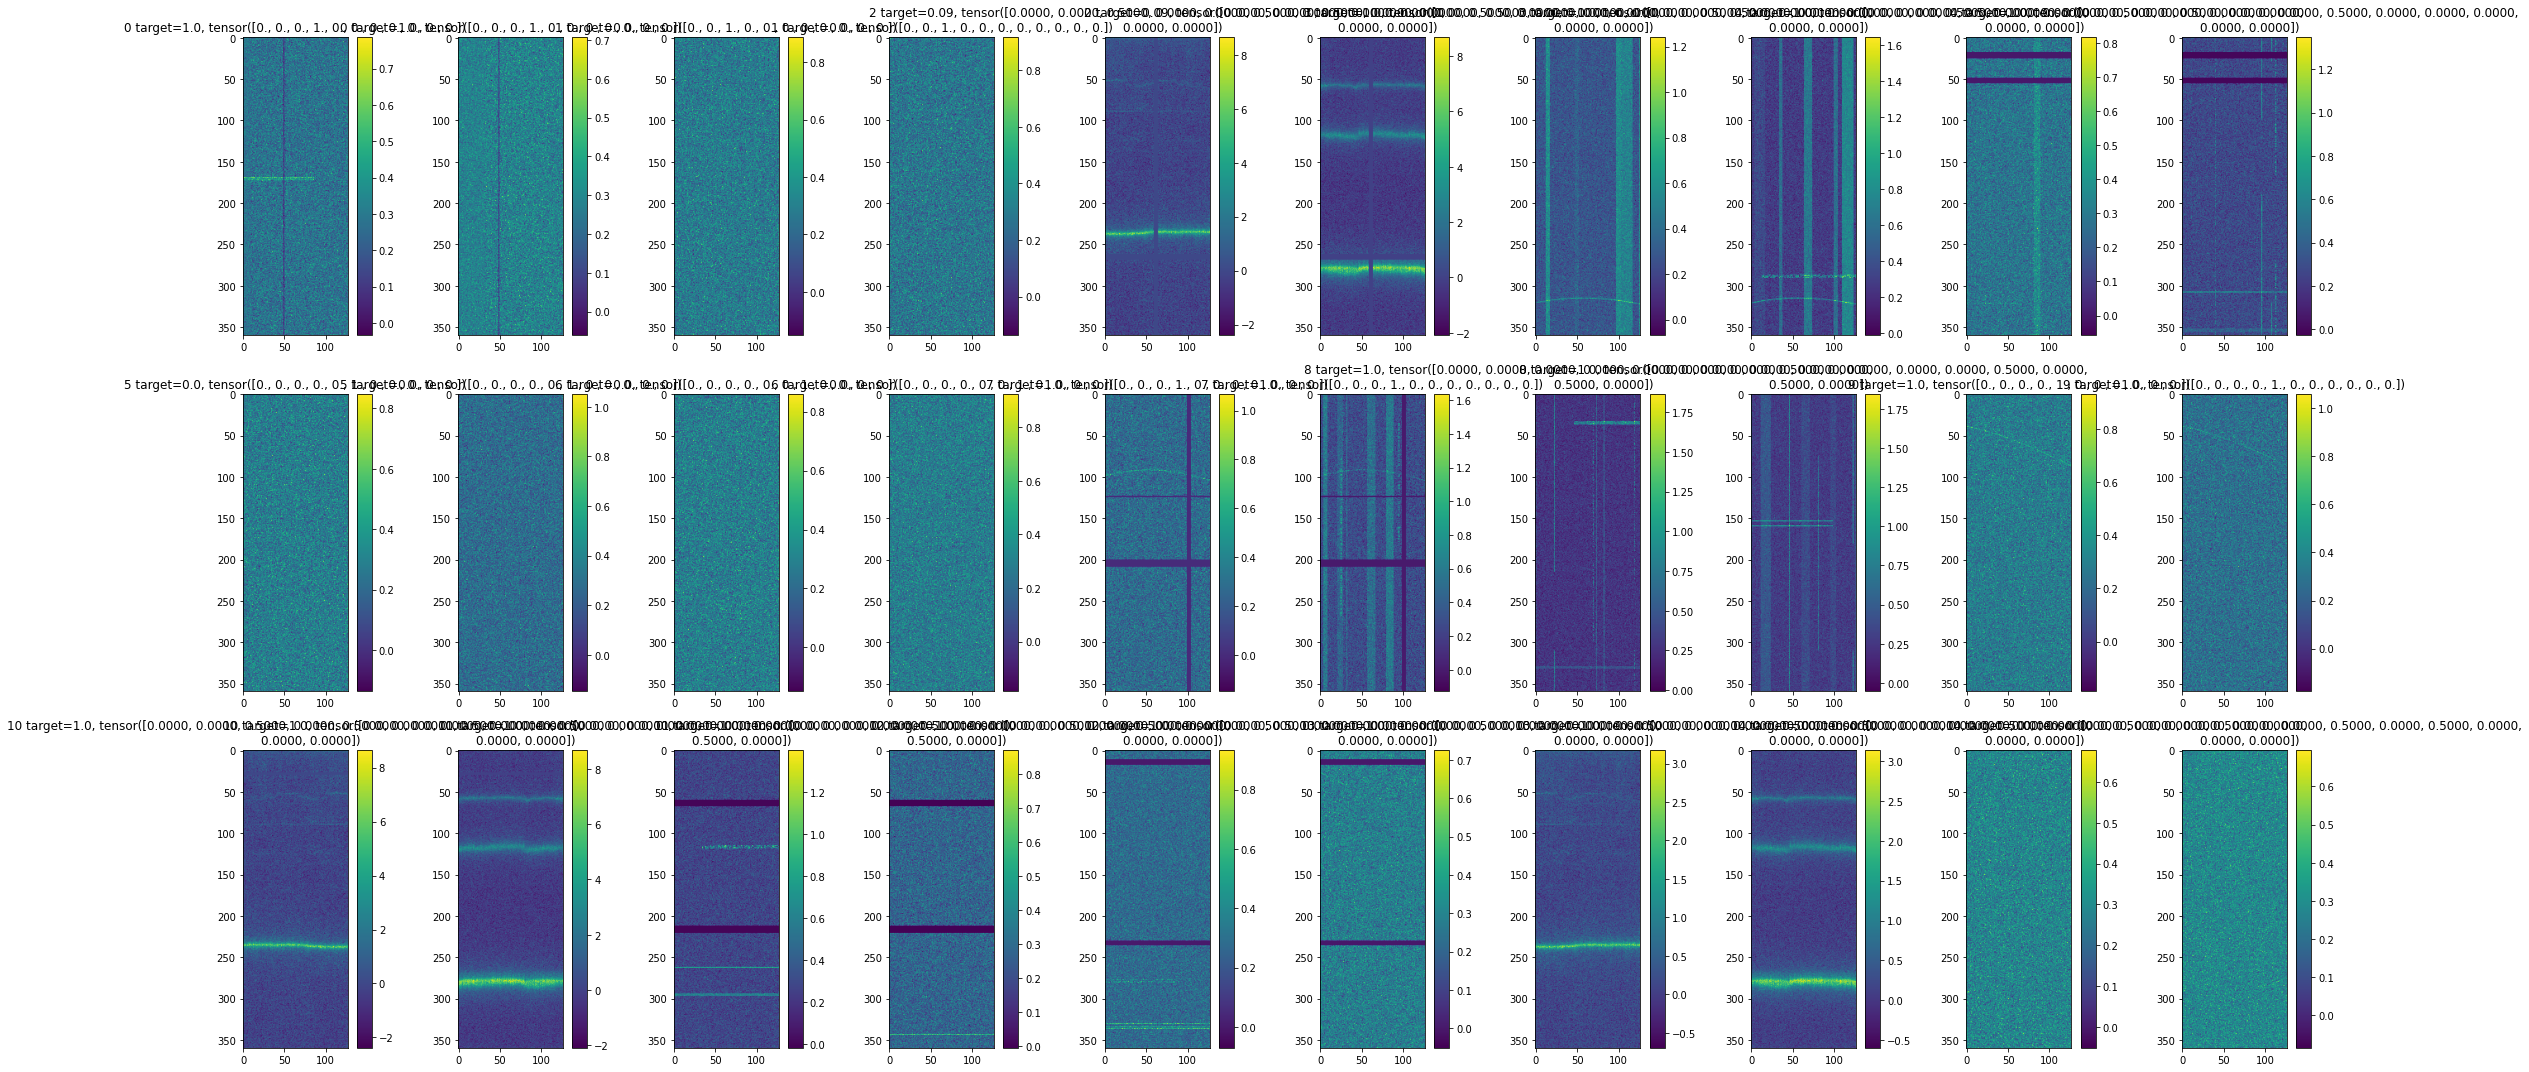

In [37]:
#%%time
# timeでファイルioに時間かかるか確認
if CFG.is_train_zip_dataset:
    train_dataset = ZipDataset(
        path=f"{zip_path}/archive", mod=zip_mod, transforms=get_transforms(data="train")
    )
else:
    train_dataset = TrainDataset(
        train_df,
        #pd.concat([train_df, add_df_all]),
        transforms=get_transforms(data="train"),
        is_npy=CFG.is_npy,
        is_add_ch=CFG.is_add_ch,
        prob_spec_start_random=CFG.prob_spec_start_random,
        prob_sample_mixup=CFG.prob_sample_mixup,
        prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
        prob_mean_mixup=CFG.prob_mean_mixup,
        prob_noise_band=CFG.prob_noise_band,
        prob_noise_spot=CFG.prob_noise_spot,
        prob_noise_vline=CFG.prob_noise_vline,
        prob_noise_hband=CFG.prob_noise_hband,
        prob_swap_ch_nega=CFG.prob_swap_ch_nega,
        prob_flip_nega=CFG.prob_flip_nega,
        prob_swap_nega=CFG.prob_swap_nega,
        prob_vshift_nega=CFG.prob_vshift_nega,
        prob_vshift=CFG.prob_vshift,
        time_mask_num=CFG.time_mask_num,
        freq_mask_num=CFG.freq_mask_num,
    )
    #train_dataset = TrainDataset(
    #    #train_df,
    #    pd.concat([train_df, add_df_all]),
    #    transforms=get_transforms(data="train"),
    #    is_npy=CFG.is_npy,
    #    #is_add_ch=True,
    #    #prob_spec_start_random=1.0,
    #    prob_add_sample_nega_mixup=1.0,
    #    prob_sample_mixup=1.0,
    #    prob_mean_mixup=1.0,
    #    prob_noise_band=1.0,
    #    prob_noise_spot=1.0,
    #    prob_noise_vline=1.0,
    #    prob_noise_hband=1.0,
    #    #prob_swap_ch_nega=1.0,
    #    #prob_flip_nega=1.0,
    #    #prob_swap_nega=1.0,
    #    #prob_vshift_nega=1.0,
    #    #prob_vshift=1.0,
    #    #time_mask_num=5,
    #    #freq_mask_num=5,
    #)
train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True,
    #collate_fn=mixup_collate_fn,
)
for step, (images, labels, labels_freq) in enumerate(train_loader):
    print(images.shape, labels.shape, labels_freq.shape)
    
    if normalize_type == "largekernel":
        plt.figure(figsize=(30,25))
    else:
        plt.figure(figsize=(30,15))
    i = 1
    for idx, (im, la, la_f) in enumerate(zip(images, labels, labels_freq)):
        #print(la_f.shape)
        #print(la_f.squeeze().shape)
        im = im.transpose(0, 1).transpose(1, 2)  # (H,W,C)
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,0])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,1])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}, {la_f.squeeze()}", fontsize=12)
        i += 1
        
        if i > 30:
            break
            
    plt.tight_layout()
    plt.show()
    break

In [38]:
#%debug

In [39]:
#=====

# Model

In [40]:
class CustomModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch)        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModel(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [41]:
# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook を参考にdropout入れて過学習避ける
class CustomModelDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch, 
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [42]:
class CustomModelMultiOutput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [43]:
class CustomModelMultiOutputDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch,
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )   
        self.head1 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        self.head2 = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)  # 40-500Hz // CFG.freq_div_n
        )
    def forward(self, x, labels=None):
        feat = self.net(x)
        y1 = self.head1(feat)
        y2 = self.head2(feat)
        return y1[:,0], y2

#print(CFG.model_name)
#m = CustomModelMultiOutputDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o1, o2 = m(x.cuda())
#print(o1, o1.shape)
#print(o2, o2.shape)
##m

In [44]:
#=====

In [45]:
class CustomModelAddEmb(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=0, 
                                     in_chans=CFG.ch)   
        self.head = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features+(500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1, CFG.num_classes)  # embを1次元増やす
        )
    def forward(self, x, add_x):
        feat = self.net(x)
        #print(feat.shape, add_x.shape)
        y = self.head( torch.cat((feat, add_x), 1) )
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelAddEmb(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#add_x = torch.rand(CFG.batch_size, (500 // CFG.freq_div_n) - (40 // CFG.freq_div_n) + 1)
#o = m(x.cuda(), add_x.cuda())
#print(o, o.shape)
##m

In [46]:
#=====

In [47]:
class CustomModelMultiInput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net1 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2) 
        self.net2 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2)
        self.head = nn.Sequential(
            nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net1.num_features + self.net2.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        
        x1 = x[:, :CFG.ch//2, :, :]
        x2 = x[:, CFG.ch//2:, :, :]
        #print(x1.shape, x2.shape)
        
        feat1 = self.net1(x1)
        feat2 = self.net2(x2)
        y = self.head( torch.cat((feat1, feat2), 1) )
        #print(feat1.shape, feat2.shape, y.shape)
        
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelMultiInput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [48]:
#=====

In [49]:
class CustomModelLargeKernel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            pth = "/volume/kaggle/g2net2/kaggle_dl/g2net-detecting-continuous-gravitational-waves-v0/model_best.pth"
        else:
            pth = ""
        self.net = largekernel.get_model(
            model_name="tf_efficientnetv2_b0",
            path=pth,
            conv_in_chans=32
        )
        self.net.classifier = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelLargeKernel().cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [50]:
#=====

In [51]:
# https://github.com/sinpcw/kaggle-whale2/blob/master/models.py
def loadpth(pth: str, map_location=None) -> OrderedDict:
    """
    パラメータロードのヘルパー関数.
    DataParallel化したモデルは module.xxxx という形式で保存されるため読込み時にmodule.から始まる場合はそれを取除く.
    """
    ostate = torch.load(pth, map_location=map_location)['model']
    nstate = OrderedDict()
    for k, v in ostate.items():
        if k.startswith('module.'):
            nstate[k[len('module.'):]] = v
        else:
            nstate[k] = v
    return nstate

# Metric

In [52]:
def get_score(labels: np.ndarray, predictions: np.ndarray):
    # predictions が nan になったときの対策
    try:
        return roc_auc_score(labels, predictions)
    except:
        return 0.0

# Helper

In [53]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [54]:
def forward_step(step, losses, batch_size, model, criterion, images, labels, prob_mixup, optimizer, scaler, optimizer_step,
                 labels_freq, criterion2):  # for MultiOutput
    """
    SAMは2回forward必要だからforwardの処理（loss計算+backward）切り出す
    """
    # SAM 1st/2nd Path
    optimizer.step = optimizer_step
    
    # ===========================================
    # model forward for mixup
    # ===========================================
    if np.random.rand() > 1 - prob_mixup:
        x, y_mixs = mixup(images, labels.long(), CFG.mix_alpha)  # y_mixs=(target, shuffled_target, lambda)
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(x.float())  # for MultiOutput
                if CFG.is_mix_or:
                    y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                    loss = criterion(outputs, y_mix_or.float())
                else:
                    loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
        else:
            outputs, outputs2 = model(x.float())  # for MultiOutput
            if CFG.is_mix_or:
                y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                loss = criterion(outputs, y_mix_or.float())
            else:
                loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
    else:
        if CFG.apex:
            with autocast():
                outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
                loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
        else:
            outputs, outputs2 = model(images)  # 予測値の算出  for MultiOutput
            loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
            
    loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
    loss = (loss + loss2) / 2.0  # for MultiOutput
    
    # ===========================================
    # record loss
    # ===========================================
    losses.update(loss.item(), batch_size)  # loggerにloss保存
    if CFG.gradient_accumulation_steps > 1:
        loss = loss / CFG.gradient_accumulation_steps  # normalize loss to account for batch accumulation
    if CFG.apex:
        scaler.scale(loss).backward()  # 各パラメータの勾配を算出
    else:
        loss.backward()  # 誤差逆伝播して各パラメータの勾配を算出
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)  # 勾配クリッピング
    
    # ===========================================
    # optimizer step
    # ===========================================
    if (step + 1) % CFG.gradient_accumulation_steps == 0:
        if CFG.apex:
            scaler.step(optimizer)  # 勾配の情報を用いたパラメータの更新
            scaler.update()
        else:
            optimizer.step()  # 勾配の情報を用いたパラメータの更新
        optimizer.zero_grad()  # 勾配情報の初期化
        
    return optimizer, scaler, losses, grad_norm

In [55]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, 
             prob_mixup=False, mixup_fn=None,
             criterion2=None):  # for MultiOutput
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    else:
        scaler = None
    losses = AverageMeter()
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        ## ===========================================
        ## timm mixup/cutmix
        ## ===========================================
        #if mixup_fn is not None:
        #    images, labels = mixup_fn(images, labels)
        #else:
        #    labels = one_hot(labels, CFG.num_classes, device=device)
        
        if isinstance(optimizer, SAM) or isinstance(optimizer, ASAM):
            optimizer, scaler, _, _ = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                   prob_mixup, optimizer, scaler, 
                                                   optimizer.first_step,
                                                   labels_freq, criterion2)  # for MultiOutput
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.second_step,
                                                                labels_freq, criterion2)  # for MultiOutput
        else:
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.step,
                                                                labels_freq, criterion2)  # for MultiOutput
            
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.4e}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=optimizer.param_groups[0]["lr"]))
        
        if CFG.is_save_per_steps:
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                OUTPUT_DIR + "/per_steps.pth",
            )

    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg

In [56]:
@torch.inference_mode()  # pytorch >= 1.9
def valid_fn(valid_loader, model, criterion, device, 
             criterion2):  # for MultiOutput
    model.eval()
    losses = AverageMeter()
    preds = []
    
    start = end = time.time()
    
    for step, (images, labels, labels_freq) in enumerate(valid_loader):  # for MultiOutput
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        labels_freq = labels_freq.to(device)  # for MultiOutput
        
        # ===========================================
        # compute loss
        # ===========================================
        with torch.no_grad():
            # for MultiOutput
            outputs, outputs2 = model(images)  # logit
        loss = criterion(outputs, labels)
        loss2 = criterion2(outputs2, labels_freq.squeeze())  # for MultiOutput
        loss = (loss + loss2) / 2.0  # for MultiOutput
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        ## ===========================================
        ## record topk index
        ## ===========================================
        #_, tk = torch.topk(outputs, 5, dim=1)
        #topk_indexs = tk.to('cpu').detach().numpy()
        #preds.append(topk_indexs[:,0])  # top1
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
            
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg, predictions

# Train loop

In [57]:
def train_loop(folds, fold, seed):
    
    LOGGER.info(f"========== fold: {fold}, seed: {seed} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    if CFG.is_train_zip_dataset:
        train_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod, transforms=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, is_npy=False, transforms=get_transforms(data='valid'))
    else:
        
        train_dataset = TrainDataset(train_folds, 
                                     transforms=get_transforms(data='train'), 
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                     prob_spec_start_random=CFG.prob_spec_start_random,
                                     prob_sample_mixup=CFG.prob_sample_mixup,
                                     prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
                                     prob_mean_mixup=CFG.prob_mean_mixup,
                                     prob_noise_band=CFG.prob_noise_band,
                                     prob_noise_spot=CFG.prob_noise_spot,
                                     prob_noise_vline=CFG.prob_noise_vline,
                                     prob_noise_hband=CFG.prob_noise_hband,
                                     prob_swap_ch_nega=CFG.prob_swap_ch_nega,
                                     prob_flip_nega=CFG.prob_flip_nega,
                                     prob_swap_nega=CFG.prob_swap_nega,
                                     prob_vshift_nega=CFG.prob_vshift_nega,
                                     prob_vshift=CFG.prob_vshift,
                                     time_mask_num=CFG.time_mask_num,
                                     freq_mask_num=CFG.freq_mask_num,
                                    )
        valid_dataset = TrainDataset(valid_folds, 
                                     transforms=get_transforms(data='valid'),
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                    )
    
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineLRScheduler':
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
        elif CFG.scheduler=='CosineLRScheduler_cycle_limit3':
            _cycle_limit = 3
            # https://timm.fast.ai/SGDR#cycle_limit=2
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs//_cycle_limit, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True,
                                          cycle_limit=_cycle_limit,
                                         )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = eval(CFG.model_cls)(pretrained=CFG.pretrained)
    
    if os.path.exists(CFG.load_model_path):
        LOGGER.info("=> loading checkpoint '{}'".format(CFG.load_model_path))
        states = torch.load(CFG.load_model_path, map_location=torch.device("cpu"))
        if len(CFG.device_ids) > 1:
            model.load_state_dict( loadpth(CFG.load_model_path, map_location=torch.device("cpu")) )
        else:
            model.load_state_dict(states["model"])
    
    if len(CFG.device_ids) > 1:
        if CFG.is_syncBN:
            # https://blog.shikoan.com/sync-batch-norm-pytorch/
            model = convert_model(model).to(device) # Batch NormをSync Batch Normに変換
            model = DataParallelWithCallback(model, device_ids=CFG.device_ids) # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids} use SyncBN")
        else:
            model.to(device)
            model = nn.DataParallel(model, device_ids=CFG.device_ids)  # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids}")
        # https://aru47.hatenablog.com/entry/2020/11/06/225052
        cudnn.benchmark = True
    else:
        model.to(device)

    if CFG.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == "adamw":
        optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'nesterov':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay, nesterov=True)
    elif CFG.optimizer == 'sam':
        optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=CFG.lr, weight_decay=CFG.weight_decay, rho=0.05)
        
    scheduler = get_scheduler(optimizer)
    
    if os.path.exists(CFG.load_model_path):
        if CFG.is_load_opt:
            LOGGER.info("=> loading optimizer and scheduler")
            optimizer.load_state_dict(states["optimizer"])
            scheduler.load_state_dict(states["scheduler"])

    if CFG.is_wandb:
        # wandbでpytorchのモデル監視
        wandb.watch(model)
            
    # ====================================================
    # loop
    # ====================================================
    train_criterion = eval(CFG.loss)().to(device)
    valid_criterion = eval(CFG.loss)().to(device)
    # for MultiOutput
    train_criterion2 = nn.CrossEntropyLoss().to(device)
    valid_criterion2 = nn.CrossEntropyLoss().to(device)
    
    best_score = -np.inf
    best_loss = np.inf
    
    #mixup_fn = Mixup(**CFG.mixup_args)
    mixup_fn = None
    prob_mixup = CFG.prob_mixup
    
    for epoch in range(CFG.epochs):
        
        # mixup_off_epoch以上はmixup/cutmixなしにする
        if epoch >= CFG.mixup_off_epoch:
            mixup_fn = None
            prob_mixup = 0.0
            #LOGGER.info(f'Epoch {epoch+1} - mixup_fn=None')
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, train_criterion, optimizer, epoch, scheduler, device, 
                            prob_mixup=prob_mixup,
                            criterion2=train_criterion2)  # for MultiOutput

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, valid_criterion, device,
                                       valid_criterion2)  # for MultiOutput
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, CosineLRScheduler):
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler.step(epoch+1)
            
        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - lr: {optimizer.param_groups[0]["lr"]:.4e}')
       
        if CFG.is_wandb:
            # save log wandb
            wandb.log({f"[fold{fold}] epoch": epoch+1,
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] lr": optimizer.param_groups[0]["lr"]})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
            
    valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth', map_location=torch.device('cpu'))['preds'].tolist()
    #valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth', map_location=torch.device('cpu'))['preds'].tolist()

    return valid_folds

# Main

In [58]:
def get_result(result_df, preds_col="preds", add_info=""):
    labels = result_df[CFG.target_col].values
    preds = result_df[preds_col].values
    preds = np.array([np.array(p) for p in preds])
    score = get_score(labels, preds)
    LOGGER.info(f'{add_info}Score: {score:<.4f}')
    return score
    

def main(df):
    if CFG.train:
        oof_scores = []
        for seed in CFG.seeds:
            seed_torch(seed)
            
            # 生成データロード
            if ADD_DIRS_STR != "":
                add_df = pd.read_csv(f"{OUTPUT_DIR}/add_data.csv")
                if CFG.debug:
                    add_df = cv_split_kfold(add_df, 0, 10)
                    add_df = add_df[add_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_df.shape: {str(add_df.shape)}")

                # cv_split
                if CFG.add_split_str == "":
                    folds = pd.concat([df, add_df], ignore_index=True)
                    folds = cv_split(folds, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                else:
                    # オリジナルデータと生成データは別の切り方でfold分ける
                    if CFG.add_split_str == "KFold":
                        add_df = cv_split_kfold(add_df, seed, CFG.n_fold)
                    else:
                        add_df = cv_split(add_df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold

                    folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                    folds = pd.concat([folds, add_df], ignore_index=True) 
                    
                # 生成データのtarget=1はすべてtrainに使う
                if IS_ADD_ALL_TRAIN1:
                    _orig_folds = folds.dropna(subset=['freq_min//10_target'])
                    _add_folds = folds.dropna(subset=['type'])
                    _add_target0 = _add_folds[_add_folds[CFG.target_col] == 0]
                    _add_target1 = _add_folds[_add_folds[CFG.target_col] == 1]
                    _add_target1["fold"] = -1    
                    folds = pd.concat([_orig_folds, _add_target0, _add_target1]).reset_index(drop=True)
                    print(folds.groupby(['fold', CFG.target_col]).size())

            else:
                folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                
            # zip_df.csvでfinetuneする場合
            if CFG.is_train_zip_dataset:
                folds = pd.read_csv(f'{zip_path}/zip_df.csv')                
                df["fold"] = 0
                folds = pd.concat([folds, df], ignore_index=True)
                
            # 疑似ラベル全foldのtrainに入れる
            if PSEUDO_CSV != "":
                pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/pseudo_df.csv")
                if CFG.debug:
                    pseudo_df = cv_split_kfold(pseudo_df, 0, 30)
                    pseudo_df = pseudo_df[pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"pseudo_df.shape: {str(pseudo_df.shape)}")
                pseudo_df["fold"] = -1
                folds = pd.concat([folds, pseudo_df], ignore_index=True)
            if ADD_PSEUDO_DIRS != "":
                add_pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv")
                if CFG.debug:
                    add_pseudo_df = cv_split_kfold(add_pseudo_df, 0, 30)
                    add_pseudo_df = add_pseudo_df[add_pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_pseudo_df.shape: {str(add_pseudo_df.shape)}")
                add_pseudo_df["fold"] = -1
                folds = pd.concat([folds, add_pseudo_df], ignore_index=True)
                
            folds.to_csv(OUTPUT_DIR +f"/folds_seed{seed}.csv", index=False)
            LOGGER.info(f"folds.shape: {str(folds.shape)}")
            
            # train fold
            scores = []
            oof_df = pd.DataFrame()
            for fold in range(CFG.n_fold):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(folds, fold, seed)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} seed: {seed} result ==========")
                    _score = get_result(_oof_df, add_info=f"fold{fold} ")
                    scores.append(_score)
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    
            # CV result
            LOGGER.info(f"========== CV ==========")
            LOGGER.info(f'macro mean folds Score ± std: {np.mean(scores):<.4f} ± {np.std(scores):<.4f}')
            oof_score = get_result(oof_df, add_info=f"oof ")
            oof_scores.append(oof_score)
            # save result
            oof_df.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}.csv', index=False)
            
            if CFG.is_wandb:
                # save log wandb
                wandb.log({f"[fold{str(CFG.trn_fold)}] best_score": oof_score})
            
            plt.hist(oof_df["preds"], bins=100)
            plt.show()
            plt.clf()  # メモリ解放
            plt.close()
            
        if len(oof_scores) > 1:
            LOGGER.info(f'seed macro mean oof Score ± std: {np.mean(oof_scores):<.4f} ± {np.std(oof_scores):<.4f}') 

add_df.shape: (8400, 24)
pseudo_df.shape: (6478, 30)
add_pseudo_df.shape: (796, 18)


> SEEDING DONE
fold0: (1680,)
fold1: (1680,)
fold2: (1680,)
fold3: (1680,)
fold4: (1680,)
fold  target
0     0         880
      1         800
1     0         880
      1         800
2     0         880
      1         800
3     0         880
      1         800
4     0         880
      1         800
dtype: int64
fold0: (120,)
fold1: (120,)
fold2: (120,)
fold3: (120,)
fold4: (120,)
fold  target
0     0         40
      1         80
1     0         40
      1         80
2     0         40
      1         80
3     0         40
      1         80
4     0         40
      1         80
dtype: int64


folds.shape: (16274, 38)
========== fold: 0, seed: 0 training ==========


Epoch: [1][0/226] Elapsed 0m 4s (remain 15m 55s) Loss: 1.5477(1.5477) Grad: 58263.4492  LR: 4.0000e-06  
Epoch: [1][225/226] Elapsed 1m 37s (remain 0m 0s) Loss: 1.5198(1.5374) Grad: 60465.2617  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.5548(1.5548) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6203(1.5373) 


Epoch 1 - avg_train_loss: 1.5374  avg_val_loss: 1.5373  time: 102s
Epoch 1 - Score: 0.5755
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.5755 Model
Epoch 1 - Save Best Loss: 1.5373 Model


Epoch: [2][0/226] Elapsed 0m 2s (remain 8m 8s) Loss: 1.5287(1.5287) Grad: 56472.6523  LR: 1.3600e-04  
Epoch: [2][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3675(1.4214) Grad: 48267.3828  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3510(1.3510) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3037(1.3359) 


Epoch 2 - avg_train_loss: 1.4214  avg_val_loss: 1.3359  time: 98s
Epoch 2 - Score: 0.7857
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7857 Model
Epoch 2 - Save Best Loss: 1.3359 Model


Epoch: [3][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.3941(1.3941) Grad: 64887.2617  LR: 2.6800e-04  
Epoch: [3][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3381(1.3790) Grad: 36461.9492  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3326(1.3326) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3865(1.3011) 


Epoch 3 - avg_train_loss: 1.3790  avg_val_loss: 1.3011  time: 101s
Epoch 3 - Score: 0.8146
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8146 Model
Epoch 3 - Save Best Loss: 1.3011 Model


Epoch: [4][0/226] Elapsed 0m 2s (remain 9m 24s) Loss: 1.4291(1.4291) Grad: 44742.1641  LR: 4.0000e-04  
Epoch: [4][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3757(1.3685) Grad: 24129.1758  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3528(1.3528) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6143(1.3296) 


Epoch 4 - avg_train_loss: 1.3685  avg_val_loss: 1.3296  time: 101s
Epoch 4 - Score: 0.8318
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8318 Model


Epoch: [5][0/226] Elapsed 0m 2s (remain 8m 37s) Loss: 1.3518(1.3518) Grad: 33597.5508  LR: 3.9990e-04  
Epoch: [5][225/226] Elapsed 1m 32s (remain 0m 0s) Loss: 1.3349(1.3608) Grad: 33721.6641  LR: 3.9990e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3203(1.3203) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4427(1.3217) 


Epoch 5 - avg_train_loss: 1.3608  avg_val_loss: 1.3217  time: 97s
Epoch 5 - Score: 0.8310
Epoch 5 - lr: 3.9961e-04


Epoch: [6][0/226] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3538(1.3538) Grad: 30228.9316  LR: 3.9961e-04  
Epoch: [6][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3616(1.3529) Grad: 31138.7793  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2757(1.2757) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3066(1.2726) 


Epoch 6 - avg_train_loss: 1.3529  avg_val_loss: 1.2726  time: 98s
Epoch 6 - Score: 0.8372
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Score: 0.8372 Model
Epoch 6 - Save Best Loss: 1.2726 Model


Epoch: [7][0/226] Elapsed 0m 2s (remain 8m 41s) Loss: 1.3820(1.3820) Grad: 21499.3066  LR: 3.9912e-04  
Epoch: [7][225/226] Elapsed 1m 32s (remain 0m 0s) Loss: 1.3210(1.3495) Grad: 22643.9043  LR: 3.9912e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2411(1.2411) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2874(1.2731) 


Epoch 7 - avg_train_loss: 1.3495  avg_val_loss: 1.2731  time: 97s
Epoch 7 - Score: 0.8369
Epoch 7 - lr: 3.9844e-04


Epoch: [8][0/226] Elapsed 0m 2s (remain 8m 42s) Loss: 1.3482(1.3482) Grad: 28545.4277  LR: 3.9844e-04  
Epoch: [8][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3473(1.3457) Grad: 24958.6309  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2571(1.2571) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2608(1.2924) 


Epoch 8 - avg_train_loss: 1.3457  avg_val_loss: 1.2924  time: 97s
Epoch 8 - Score: 0.8126
Epoch 8 - lr: 3.9756e-04


Epoch: [9][0/226] Elapsed 0m 2s (remain 8m 5s) Loss: 1.3340(1.3340) Grad: 34959.9531  LR: 3.9756e-04  
Epoch: [9][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3879(1.3436) Grad: 42040.7305  LR: 3.9756e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2853(1.2853) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4261(1.2863) 


Epoch 9 - avg_train_loss: 1.3436  avg_val_loss: 1.2863  time: 100s
Epoch 9 - Score: 0.8347
Epoch 9 - lr: 3.9649e-04


Epoch: [10][0/226] Elapsed 0m 2s (remain 8m 59s) Loss: 1.3747(1.3747) Grad: 24606.1426  LR: 3.9649e-04  
Epoch: [10][225/226] Elapsed 1m 32s (remain 0m 0s) Loss: 1.3203(1.3418) Grad: 26152.6895  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2767(1.2767) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3990(1.2735) 


Epoch 10 - avg_train_loss: 1.3418  avg_val_loss: 1.2735  time: 97s
Epoch 10 - Score: 0.8291
Epoch 10 - lr: 3.9523e-04


Epoch: [11][0/226] Elapsed 0m 2s (remain 8m 49s) Loss: 1.3550(1.3550) Grad: 22740.1289  LR: 3.9523e-04  
Epoch: [11][225/226] Elapsed 1m 32s (remain 0m 0s) Loss: 1.3324(1.3372) Grad: 35994.1875  LR: 3.9523e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2329(1.2329) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2929(1.2500) 


Epoch 11 - avg_train_loss: 1.3372  avg_val_loss: 1.2500  time: 97s
Epoch 11 - Score: 0.8420
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Score: 0.8420 Model
Epoch 11 - Save Best Loss: 1.2500 Model


Epoch: [12][0/226] Elapsed 0m 2s (remain 8m 39s) Loss: 1.3679(1.3679) Grad: 47695.6797  LR: 3.9378e-04  
Epoch: [12][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3887(1.3371) Grad: 28796.6250  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2591(1.2591) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2591(1.2613) 


Epoch 12 - avg_train_loss: 1.3371  avg_val_loss: 1.2613  time: 99s
Epoch 12 - Score: 0.8379
Epoch 12 - lr: 3.9214e-04


Epoch: [13][0/226] Elapsed 0m 2s (remain 7m 54s) Loss: 1.3468(1.3468) Grad: 20865.8047  LR: 3.9214e-04  
Epoch: [13][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3462(1.3390) Grad: 22804.6699  LR: 3.9214e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2260(1.2260) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2224(1.2562) 


Epoch 13 - avg_train_loss: 1.3390  avg_val_loss: 1.2562  time: 98s
Epoch 13 - Score: 0.8400
Epoch 13 - lr: 3.9031e-04


Epoch: [14][0/226] Elapsed 0m 2s (remain 10m 41s) Loss: 1.3449(1.3449) Grad: 24985.3125  LR: 3.9031e-04  
Epoch: [14][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3710(1.3339) Grad: 31266.5488  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2295(1.2295) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2862(1.2407) 


Epoch 14 - avg_train_loss: 1.3339  avg_val_loss: 1.2407  time: 99s
Epoch 14 - Score: 0.8447
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Score: 0.8447 Model
Epoch 14 - Save Best Loss: 1.2407 Model


Epoch: [15][0/226] Elapsed 0m 2s (remain 8m 52s) Loss: 1.3295(1.3295) Grad: 24424.9863  LR: 3.8829e-04  
Epoch: [15][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3069(1.3304) Grad: 21841.9199  LR: 3.8829e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2307(1.2307) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2580(1.2652) 


Epoch 15 - avg_train_loss: 1.3304  avg_val_loss: 1.2652  time: 98s
Epoch 15 - Score: 0.8362
Epoch 15 - lr: 3.8610e-04


Epoch: [16][0/226] Elapsed 0m 2s (remain 9m 2s) Loss: 1.3186(1.3186) Grad: 22632.4160  LR: 3.8610e-04  
Epoch: [16][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3351(1.3307) Grad: 19327.9902  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2408(1.2408) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2718(1.2435) 


Epoch 16 - avg_train_loss: 1.3307  avg_val_loss: 1.2435  time: 100s
Epoch 16 - Score: 0.8379
Epoch 16 - lr: 3.8372e-04


Epoch: [17][0/226] Elapsed 0m 2s (remain 9m 3s) Loss: 1.3730(1.3730) Grad: 23936.5410  LR: 3.8372e-04  
Epoch: [17][225/226] Elapsed 1m 32s (remain 0m 0s) Loss: 1.3244(1.3292) Grad: 26305.7734  LR: 3.8372e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2101(1.2101) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2117(1.2362) 


Epoch 17 - avg_train_loss: 1.3292  avg_val_loss: 1.2362  time: 97s
Epoch 17 - Score: 0.8477
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Score: 0.8477 Model
Epoch 17 - Save Best Loss: 1.2362 Model


Epoch: [18][0/226] Elapsed 0m 2s (remain 8m 6s) Loss: 1.4180(1.4180) Grad: 29332.8672  LR: 3.8116e-04  
Epoch: [18][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3048(1.3281) Grad: 18122.1191  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3307(1.3307) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3833(1.2697) 


Epoch 18 - avg_train_loss: 1.3281  avg_val_loss: 1.2697  time: 101s
Epoch 18 - Score: 0.8358
Epoch 18 - lr: 3.7842e-04


Epoch: [19][0/226] Elapsed 0m 2s (remain 8m 35s) Loss: 1.3497(1.3497) Grad: 22079.1602  LR: 3.7842e-04  
Epoch: [19][225/226] Elapsed 1m 32s (remain 0m 0s) Loss: 1.3304(1.3299) Grad: 20231.5723  LR: 3.7842e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2395(1.2395) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2175(1.2538) 


Epoch 19 - avg_train_loss: 1.3299  avg_val_loss: 1.2538  time: 97s
Epoch 19 - Score: 0.8340
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/226] Elapsed 0m 2s (remain 7m 55s) Loss: 1.2940(1.2940) Grad: 21099.3613  LR: 3.7551e-04  
Epoch: [20][225/226] Elapsed 1m 32s (remain 0m 0s) Loss: 1.3265(1.3270) Grad: 20356.5996  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3272(1.3272) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3260(1.2918) 


Epoch 20 - avg_train_loss: 1.3270  avg_val_loss: 1.2918  time: 97s
Epoch 20 - Score: 0.8145
Epoch 20 - lr: 3.7243e-04


Epoch: [21][0/226] Elapsed 0m 2s (remain 8m 54s) Loss: 1.3274(1.3274) Grad: 37460.5352  LR: 3.7243e-04  
Epoch: [21][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3140(1.3255) Grad: 20919.6172  LR: 3.7243e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2295(1.2295) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3097(1.2396) 


Epoch 21 - avg_train_loss: 1.3255  avg_val_loss: 1.2396  time: 99s
Epoch 21 - Score: 0.8430
Epoch 21 - lr: 3.6918e-04


Epoch: [22][0/226] Elapsed 0m 2s (remain 9m 0s) Loss: 1.2846(1.2846) Grad: 20807.6094  LR: 3.6918e-04  
Epoch: [22][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3217(1.3259) Grad: 20150.1621  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2576(1.2576) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3044(1.2432) 


Epoch 22 - avg_train_loss: 1.3259  avg_val_loss: 1.2432  time: 97s
Epoch 22 - Score: 0.8388
Epoch 22 - lr: 3.6576e-04


Epoch: [23][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.3135(1.3135) Grad: 21039.2324  LR: 3.6576e-04  
Epoch: [23][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.2991(1.3227) Grad: 20426.1211  LR: 3.6576e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2228(1.2228) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2116(1.2412) 


Epoch 23 - avg_train_loss: 1.3227  avg_val_loss: 1.2412  time: 98s
Epoch 23 - Score: 0.8443
Epoch 23 - lr: 3.6219e-04


Epoch: [24][0/226] Elapsed 0m 2s (remain 7m 36s) Loss: 1.3230(1.3230) Grad: 18133.4297  LR: 3.6219e-04  
Epoch: [24][225/226] Elapsed 1m 32s (remain 0m 0s) Loss: 1.2869(1.3241) Grad: 20915.8242  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2654(1.2654) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3791(1.2367) 


Epoch 24 - avg_train_loss: 1.3241  avg_val_loss: 1.2367  time: 97s
Epoch 24 - Score: 0.8364
Epoch 24 - lr: 3.5845e-04


Epoch: [25][0/226] Elapsed 0m 2s (remain 8m 47s) Loss: 1.3328(1.3328) Grad: 28079.2012  LR: 3.5845e-04  
Epoch: [25][225/226] Elapsed 1m 32s (remain 0m 0s) Loss: 1.3307(1.3223) Grad: 19667.0371  LR: 3.5845e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1989(1.1989) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2112(1.2464) 


Epoch 25 - avg_train_loss: 1.3223  avg_val_loss: 1.2464  time: 97s
Epoch 25 - Score: 0.8433
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/226] Elapsed 0m 2s (remain 7m 34s) Loss: 1.3302(1.3302) Grad: 21696.5703  LR: 3.5456e-04  
Epoch: [26][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2740(1.3190) Grad: 16003.1182  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2723(1.2723) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2501(1.2441) 


Epoch 26 - avg_train_loss: 1.3190  avg_val_loss: 1.2441  time: 99s
Epoch 26 - Score: 0.8382
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/226] Elapsed 0m 2s (remain 8m 31s) Loss: 1.3165(1.3165) Grad: 24996.9922  LR: 3.5052e-04  
Epoch: [27][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3270(1.3215) Grad: 25250.3633  LR: 3.5052e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2693(1.2693) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2409(1.2525) 


Epoch 27 - avg_train_loss: 1.3215  avg_val_loss: 1.2525  time: 97s
Epoch 27 - Score: 0.8363
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/226] Elapsed 0m 2s (remain 9m 6s) Loss: 1.3133(1.3133) Grad: 28660.3730  LR: 3.4634e-04  
Epoch: [28][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3192(1.3217) Grad: 24125.6836  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2047(1.2047) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1671(1.2486) 


Epoch 28 - avg_train_loss: 1.3217  avg_val_loss: 1.2486  time: 98s
Epoch 28 - Score: 0.8467
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/226] Elapsed 0m 2s (remain 8m 5s) Loss: 1.3367(1.3367) Grad: 23963.0117  LR: 3.4201e-04  
Epoch: [29][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3087(1.3195) Grad: 20970.3848  LR: 3.4201e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2135(1.2135) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2301(1.2287) 


Epoch 29 - avg_train_loss: 1.3195  avg_val_loss: 1.2287  time: 98s
Epoch 29 - Score: 0.8460
Epoch 29 - lr: 3.3754e-04
Epoch 29 - Save Best Loss: 1.2287 Model


Epoch: [30][0/226] Elapsed 0m 2s (remain 8m 17s) Loss: 1.3001(1.3001) Grad: 21400.7051  LR: 3.3754e-04  
Epoch: [30][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2985(1.3195) Grad: 18369.3887  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2158(1.2158) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1261(1.2686) 


Epoch 30 - avg_train_loss: 1.3195  avg_val_loss: 1.2686  time: 101s
Epoch 30 - Score: 0.8424
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/226] Elapsed 0m 1s (remain 6m 53s) Loss: 1.2918(1.2918) Grad: 25029.1113  LR: 3.3294e-04  
Epoch: [31][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3684(1.3182) Grad: 19434.8770  LR: 3.3294e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1897(1.1897) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1221(1.2320) 


Epoch 31 - avg_train_loss: 1.3182  avg_val_loss: 1.2320  time: 98s
Epoch 31 - Score: 0.8396
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/226] Elapsed 0m 2s (remain 8m 30s) Loss: 1.3045(1.3045) Grad: 21072.1992  LR: 3.2821e-04  
Epoch: [32][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3700(1.3190) Grad: 25536.3496  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2203(1.2203) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2343(1.2338) 


Epoch 32 - avg_train_loss: 1.3190  avg_val_loss: 1.2338  time: 98s
Epoch 32 - Score: 0.8414
Epoch 32 - lr: 3.2336e-04


Epoch: [33][0/226] Elapsed 0m 2s (remain 9m 22s) Loss: 1.3101(1.3101) Grad: 22322.7871  LR: 3.2336e-04  
Epoch: [33][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3275(1.3191) Grad: 20621.2695  LR: 3.2336e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2149(1.2149) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0939(1.2310) 


Epoch 33 - avg_train_loss: 1.3191  avg_val_loss: 1.2310  time: 101s
Epoch 33 - Score: 0.8396
Epoch 33 - lr: 3.1838e-04


Epoch: [34][0/226] Elapsed 0m 2s (remain 9m 50s) Loss: 1.2807(1.2807) Grad: 19412.7207  LR: 3.1838e-04  
Epoch: [34][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2568(1.3168) Grad: 19092.0273  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2372(1.2372) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1805(1.2334) 


Epoch 34 - avg_train_loss: 1.3168  avg_val_loss: 1.2334  time: 98s
Epoch 34 - Score: 0.8375
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/226] Elapsed 0m 2s (remain 8m 19s) Loss: 1.3620(1.3620) Grad: 41118.5000  LR: 3.1329e-04  
Epoch: [35][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2405(1.3158) Grad: 21293.1113  LR: 3.1329e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2887(1.2887) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2389(1.2310) 


Epoch 35 - avg_train_loss: 1.3158  avg_val_loss: 1.2310  time: 98s
Epoch 35 - Score: 0.8379
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/226] Elapsed 0m 2s (remain 9m 12s) Loss: 1.3249(1.3249) Grad: 22174.1621  LR: 3.0809e-04  
Epoch: [36][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3051(1.3169) Grad: 14857.8047  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2359(1.2359) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2392(1.2348) 


Epoch 36 - avg_train_loss: 1.3169  avg_val_loss: 1.2348  time: 99s
Epoch 36 - Score: 0.8431
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/226] Elapsed 0m 2s (remain 8m 3s) Loss: 1.3615(1.3615) Grad: 26596.6953  LR: 3.0279e-04  
Epoch: [37][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3174(1.3145) Grad: 20141.2598  LR: 3.0279e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2298(1.2298) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1750(1.2158) 


Epoch 37 - avg_train_loss: 1.3145  avg_val_loss: 1.2158  time: 98s
Epoch 37 - Score: 0.8389
Epoch 37 - lr: 2.9739e-04
Epoch 37 - Save Best Loss: 1.2158 Model


Epoch: [38][0/226] Elapsed 0m 2s (remain 8m 34s) Loss: 1.3002(1.3002) Grad: 18041.3047  LR: 2.9739e-04  
Epoch: [38][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2484(1.3102) Grad: 23902.0430  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2418(1.2418) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2695(1.2340) 


Epoch 38 - avg_train_loss: 1.3102  avg_val_loss: 1.2340  time: 98s
Epoch 38 - Score: 0.8435
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/226] Elapsed 0m 1s (remain 7m 18s) Loss: 1.3350(1.3350) Grad: 21792.1055  LR: 2.9189e-04  
Epoch: [39][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.2895(1.3113) Grad: 27975.9453  LR: 2.9189e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2194(1.2194) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3262(1.2254) 


Epoch 39 - avg_train_loss: 1.3113  avg_val_loss: 1.2254  time: 98s
Epoch 39 - Score: 0.8497
Epoch 39 - lr: 2.8630e-04
Epoch 39 - Save Best Score: 0.8497 Model


Epoch: [40][0/226] Elapsed 0m 2s (remain 9m 20s) Loss: 1.3056(1.3056) Grad: 19596.6367  LR: 2.8630e-04  
Epoch: [40][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3121(1.3130) Grad: 20811.9121  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2490(1.2490) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2445(1.2136) 


Epoch 40 - avg_train_loss: 1.3130  avg_val_loss: 1.2136  time: 99s
Epoch 40 - Score: 0.8443
Epoch 40 - lr: 2.8064e-04
Epoch 40 - Save Best Loss: 1.2136 Model


Epoch: [41][0/226] Elapsed 0m 2s (remain 7m 36s) Loss: 1.3032(1.3032) Grad: 23584.0195  LR: 2.8064e-04  
Epoch: [41][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.2847(1.3146) Grad: 27427.7227  LR: 2.8064e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2118(1.2118) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2000(1.2543) 


Epoch 41 - avg_train_loss: 1.3146  avg_val_loss: 1.2543  time: 98s
Epoch 41 - Score: 0.8271
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/226] Elapsed 0m 2s (remain 8m 3s) Loss: 1.3101(1.3101) Grad: 19696.2363  LR: 2.7489e-04  
Epoch: [42][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2777(1.3118) Grad: 25128.2949  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2707(1.2707) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2965(1.2381) 


Epoch 42 - avg_train_loss: 1.3118  avg_val_loss: 1.2381  time: 99s
Epoch 42 - Score: 0.8449
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/226] Elapsed 0m 2s (remain 9m 8s) Loss: 1.3050(1.3050) Grad: 18467.1836  LR: 2.6907e-04  
Epoch: [43][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2844(1.3110) Grad: 19754.0664  LR: 2.6907e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2159(1.2159) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2752(1.2277) 


Epoch 43 - avg_train_loss: 1.3110  avg_val_loss: 1.2277  time: 99s
Epoch 43 - Score: 0.8385
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/226] Elapsed 0m 2s (remain 8m 48s) Loss: 1.3004(1.3004) Grad: 23497.2441  LR: 2.6319e-04  
Epoch: [44][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3082(1.3091) Grad: 18216.8672  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2314(1.2314) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1689(1.2291) 


Epoch 44 - avg_train_loss: 1.3091  avg_val_loss: 1.2291  time: 101s
Epoch 44 - Score: 0.8443
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/226] Elapsed 0m 2s (remain 8m 38s) Loss: 1.3280(1.3280) Grad: 16096.9785  LR: 2.5724e-04  
Epoch: [45][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.2946(1.3091) Grad: 15981.5664  LR: 2.5724e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1838(1.1838) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1598(1.2418) 


Epoch 45 - avg_train_loss: 1.3091  avg_val_loss: 1.2418  time: 97s
Epoch 45 - Score: 0.8386
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/226] Elapsed 0m 2s (remain 9m 22s) Loss: 1.3288(1.3288) Grad: 19307.7402  LR: 2.5124e-04  
Epoch: [46][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2577(1.3102) Grad: 20537.6406  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2705(1.2705) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2006(1.2265) 


Epoch 46 - avg_train_loss: 1.3102  avg_val_loss: 1.2265  time: 99s
Epoch 46 - Score: 0.8414
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/226] Elapsed 0m 2s (remain 8m 4s) Loss: 1.3721(1.3721) Grad: 28402.9199  LR: 2.4519e-04  
Epoch: [47][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2982(1.3092) Grad: 24499.4688  LR: 2.4519e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2482(1.2482) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1849(1.2298) 


Epoch 47 - avg_train_loss: 1.3092  avg_val_loss: 1.2298  time: 101s
Epoch 47 - Score: 0.8462
Epoch 47 - lr: 2.3910e-04


Epoch: [48][0/226] Elapsed 0m 2s (remain 8m 45s) Loss: 1.2989(1.2989) Grad: 21763.9863  LR: 2.3910e-04  
Epoch: [48][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2777(1.3076) Grad: 18800.2676  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2246(1.2246) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2252(1.2202) 


Epoch 48 - avg_train_loss: 1.3076  avg_val_loss: 1.2202  time: 99s
Epoch 48 - Score: 0.8401
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/226] Elapsed 0m 1s (remain 7m 23s) Loss: 1.3030(1.3030) Grad: 18646.7305  LR: 2.3297e-04  
Epoch: [49][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3446(1.3078) Grad: 20496.9297  LR: 2.3297e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1848(1.1848) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2094(1.2377) 


Epoch 49 - avg_train_loss: 1.3078  avg_val_loss: 1.2377  time: 99s
Epoch 49 - Score: 0.8463
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/226] Elapsed 0m 2s (remain 8m 46s) Loss: 1.3355(1.3355) Grad: 29080.3281  LR: 2.2682e-04  
Epoch: [50][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2819(1.3046) Grad: 19297.7363  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2165(1.2165) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1284(1.2498) 


Epoch 50 - avg_train_loss: 1.3046  avg_val_loss: 1.2498  time: 99s
Epoch 50 - Score: 0.8402
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/226] Elapsed 0m 2s (remain 8m 32s) Loss: 1.2562(1.2562) Grad: 21849.1348  LR: 2.2063e-04  
Epoch: [51][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3107(1.3070) Grad: 22316.4336  LR: 2.2063e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2262(1.2262) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1304(1.2763) 


Epoch 51 - avg_train_loss: 1.3070  avg_val_loss: 1.2763  time: 100s
Epoch 51 - Score: 0.8174
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/226] Elapsed 0m 2s (remain 8m 56s) Loss: 1.3159(1.3159) Grad: 25968.5488  LR: 2.1443e-04  
Epoch: [52][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3310(1.3054) Grad: 22606.2148  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2235(1.2235) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1444(1.2075) 


Epoch 52 - avg_train_loss: 1.3054  avg_val_loss: 1.2075  time: 99s
Epoch 52 - Score: 0.8462
Epoch 52 - lr: 2.0822e-04
Epoch 52 - Save Best Loss: 1.2075 Model


Epoch: [53][0/226] Elapsed 0m 2s (remain 8m 45s) Loss: 1.2896(1.2896) Grad: 21675.4512  LR: 2.0822e-04  
Epoch: [53][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2762(1.3037) Grad: 24845.6992  LR: 2.0822e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2134(1.2134) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1592(1.2104) 


Epoch 53 - avg_train_loss: 1.3037  avg_val_loss: 1.2104  time: 99s
Epoch 53 - Score: 0.8472
Epoch 53 - lr: 2.0200e-04


Epoch: [54][0/226] Elapsed 0m 2s (remain 7m 49s) Loss: 1.2567(1.2567) Grad: 20868.0098  LR: 2.0200e-04  
Epoch: [54][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2440(1.3075) Grad: 20701.8555  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2299(1.2299) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2114(1.2099) 


Epoch 54 - avg_train_loss: 1.3075  avg_val_loss: 1.2099  time: 98s
Epoch 54 - Score: 0.8483
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/226] Elapsed 0m 2s (remain 7m 41s) Loss: 1.2764(1.2764) Grad: 19024.5527  LR: 1.9578e-04  
Epoch: [55][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3198(1.3025) Grad: 21507.3867  LR: 1.9578e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2070(1.2070) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1847(1.2039) 


Epoch 55 - avg_train_loss: 1.3025  avg_val_loss: 1.2039  time: 98s
Epoch 55 - Score: 0.8464
Epoch 55 - lr: 1.8957e-04
Epoch 55 - Save Best Loss: 1.2039 Model


Epoch: [56][0/226] Elapsed 0m 2s (remain 8m 23s) Loss: 1.3022(1.3022) Grad: 23887.7852  LR: 1.8957e-04  
Epoch: [56][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3129(1.3037) Grad: 29354.1250  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1693(1.1693) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2083(1.2258) 


Epoch 56 - avg_train_loss: 1.3037  avg_val_loss: 1.2258  time: 99s
Epoch 56 - Score: 0.8496
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/226] Elapsed 0m 2s (remain 8m 0s) Loss: 1.3283(1.3283) Grad: 22806.2559  LR: 1.8337e-04  
Epoch: [57][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2363(1.3036) Grad: 19730.0273  LR: 1.8337e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1790(1.1790) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1505(1.2475) 


Epoch 57 - avg_train_loss: 1.3036  avg_val_loss: 1.2475  time: 99s
Epoch 57 - Score: 0.8428
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/226] Elapsed 0m 2s (remain 7m 40s) Loss: 1.3345(1.3345) Grad: 23345.6758  LR: 1.7718e-04  
Epoch: [58][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2709(1.3041) Grad: 24809.5410  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2073(1.2073) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0491(1.2333) 


Epoch 58 - avg_train_loss: 1.3041  avg_val_loss: 1.2333  time: 98s
Epoch 58 - Score: 0.8457
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/226] Elapsed 0m 2s (remain 7m 54s) Loss: 1.2752(1.2752) Grad: 22448.9160  LR: 1.7103e-04  
Epoch: [59][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.2716(1.3040) Grad: 11733.8213  LR: 1.7103e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2068(1.2068) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1652(1.2129) 


Epoch 59 - avg_train_loss: 1.3040  avg_val_loss: 1.2129  time: 98s
Epoch 59 - Score: 0.8470
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/226] Elapsed 0m 2s (remain 8m 19s) Loss: 1.3295(1.3295) Grad: 21575.0605  LR: 1.6490e-04  
Epoch: [60][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2781(1.2999) Grad: 20806.9395  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2076(1.2076) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1450(1.2345) 


Epoch 60 - avg_train_loss: 1.2999  avg_val_loss: 1.2345  time: 99s
Epoch 60 - Score: 0.8536
Epoch 60 - lr: 1.5881e-04
Epoch 60 - Save Best Score: 0.8536 Model


Epoch: [61][0/226] Elapsed 0m 2s (remain 8m 45s) Loss: 1.2585(1.2585) Grad: 25978.5762  LR: 1.5881e-04  
Epoch: [61][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2957(1.3016) Grad: 24738.2617  LR: 1.5881e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2045(1.2045) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1260(1.2031) 


Epoch 61 - avg_train_loss: 1.3016  avg_val_loss: 1.2031  time: 99s
Epoch 61 - Score: 0.8458
Epoch 61 - lr: 1.5276e-04
Epoch 61 - Save Best Loss: 1.2031 Model


Epoch: [62][0/226] Elapsed 0m 2s (remain 8m 8s) Loss: 1.3255(1.3255) Grad: 23278.8379  LR: 1.5276e-04  
Epoch: [62][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2575(1.2997) Grad: 19525.1895  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1963(1.1963) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2007(1.2282) 


Epoch 62 - avg_train_loss: 1.2997  avg_val_loss: 1.2282  time: 100s
Epoch 62 - Score: 0.8346
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/226] Elapsed 0m 2s (remain 7m 40s) Loss: 1.3106(1.3106) Grad: 21723.1797  LR: 1.4676e-04  
Epoch: [63][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3623(1.2981) Grad: 32745.9102  LR: 1.4676e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2109(1.2109) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1625(1.2097) 


Epoch 63 - avg_train_loss: 1.2981  avg_val_loss: 1.2097  time: 99s
Epoch 63 - Score: 0.8425
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/226] Elapsed 0m 2s (remain 8m 11s) Loss: 1.2642(1.2642) Grad: 25323.9980  LR: 1.4081e-04  
Epoch: [64][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3299(1.2938) Grad: 19611.5293  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2338(1.2338) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2002(1.2321) 


Epoch 64 - avg_train_loss: 1.2938  avg_val_loss: 1.2321  time: 99s
Epoch 64 - Score: 0.8415
Epoch 64 - lr: 1.3493e-04


Epoch: [65][0/226] Elapsed 0m 2s (remain 9m 38s) Loss: 1.3146(1.3146) Grad: 20271.3789  LR: 1.3493e-04  
Epoch: [65][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3199(1.2995) Grad: 24049.4434  LR: 1.3493e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2113(1.2113) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1257(1.2108) 


Epoch 65 - avg_train_loss: 1.2995  avg_val_loss: 1.2108  time: 101s
Epoch 65 - Score: 0.8428
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/226] Elapsed 0m 2s (remain 7m 46s) Loss: 1.2766(1.2766) Grad: 26174.3906  LR: 1.2911e-04  
Epoch: [66][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3139(1.2974) Grad: 17939.0488  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1933(1.1933) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1769(1.2123) 


Epoch 66 - avg_train_loss: 1.2974  avg_val_loss: 1.2123  time: 99s
Epoch 66 - Score: 0.8440
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/226] Elapsed 0m 2s (remain 9m 15s) Loss: 1.3376(1.3376) Grad: 22233.9414  LR: 1.2336e-04  
Epoch: [67][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3421(1.2961) Grad: 34744.8242  LR: 1.2336e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2303(1.2303) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1959(1.2252) 


Epoch 67 - avg_train_loss: 1.2961  avg_val_loss: 1.2252  time: 99s
Epoch 67 - Score: 0.8362
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/226] Elapsed 0m 1s (remain 7m 25s) Loss: 1.2901(1.2901) Grad: 28174.6797  LR: 1.1770e-04  
Epoch: [68][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3147(1.2966) Grad: 20100.9453  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1820(1.1820) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1794(1.2343) 


Epoch 68 - avg_train_loss: 1.2966  avg_val_loss: 1.2343  time: 98s
Epoch 68 - Score: 0.8439
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/226] Elapsed 0m 2s (remain 7m 32s) Loss: 1.2972(1.2972) Grad: 25526.3750  LR: 1.1211e-04  
Epoch: [69][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.2696(1.2974) Grad: 32588.6895  LR: 1.1211e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2019(1.2019) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2321(1.2016) 


Epoch 69 - avg_train_loss: 1.2974  avg_val_loss: 1.2016  time: 98s
Epoch 69 - Score: 0.8446
Epoch 69 - lr: 1.0661e-04
Epoch 69 - Save Best Loss: 1.2016 Model


Epoch: [70][0/226] Elapsed 0m 2s (remain 9m 16s) Loss: 1.3384(1.3384) Grad: 25545.8105  LR: 1.0661e-04  
Epoch: [70][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3002(1.2970) Grad: 25932.8242  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2099(1.2099) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1645(1.2097) 


Epoch 70 - avg_train_loss: 1.2970  avg_val_loss: 1.2097  time: 99s
Epoch 70 - Score: 0.8431
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/226] Elapsed 0m 2s (remain 8m 25s) Loss: 1.3118(1.3118) Grad: 20949.6543  LR: 1.0121e-04  
Epoch: [71][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3104(1.2950) Grad: 19435.9961  LR: 1.0121e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1874(1.1874) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1529(1.1976) 


Epoch 71 - avg_train_loss: 1.2950  avg_val_loss: 1.1976  time: 98s
Epoch 71 - Score: 0.8474
Epoch 71 - lr: 9.5906e-05
Epoch 71 - Save Best Loss: 1.1976 Model


Epoch: [72][0/226] Elapsed 0m 1s (remain 7m 26s) Loss: 1.2537(1.2537) Grad: 27178.4551  LR: 9.5906e-05  
Epoch: [72][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2552(1.2959) Grad: 23748.6875  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2154(1.2154) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1840(1.2304) 


Epoch 72 - avg_train_loss: 1.2959  avg_val_loss: 1.2304  time: 98s
Epoch 72 - Score: 0.8430
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/226] Elapsed 0m 2s (remain 7m 47s) Loss: 1.3116(1.3116) Grad: 23624.6973  LR: 9.0707e-05  
Epoch: [73][225/226] Elapsed 1m 42s (remain 0m 0s) Loss: 1.3086(1.2962) Grad: 25221.9707  LR: 9.0707e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2261(1.2261) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1373(1.2136) 


Epoch 73 - avg_train_loss: 1.2962  avg_val_loss: 1.2136  time: 107s
Epoch 73 - Score: 0.8388
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/226] Elapsed 0m 1s (remain 7m 19s) Loss: 1.2924(1.2924) Grad: 22732.9082  LR: 8.5619e-05  
Epoch: [74][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2936(1.2963) Grad: 25646.2637  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1829(1.1829) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1107(1.1970) 


Epoch 74 - avg_train_loss: 1.2963  avg_val_loss: 1.1970  time: 98s
Epoch 74 - Score: 0.8461
Epoch 74 - lr: 8.0644e-05
Epoch 74 - Save Best Loss: 1.1970 Model


Epoch: [75][0/226] Elapsed 0m 1s (remain 6m 18s) Loss: 1.2684(1.2684) Grad: 24429.1738  LR: 8.0644e-05  
Epoch: [75][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3172(1.2902) Grad: 27285.4746  LR: 8.0644e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2071(1.2071) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1899(1.2012) 


Epoch 75 - avg_train_loss: 1.2902  avg_val_loss: 1.2012  time: 98s
Epoch 75 - Score: 0.8478
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/226] Elapsed 0m 2s (remain 8m 44s) Loss: 1.2722(1.2722) Grad: 20418.2441  LR: 7.5790e-05  
Epoch: [76][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2964(1.2929) Grad: 23052.5938  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2301(1.2301) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1499(1.2202) 


Epoch 76 - avg_train_loss: 1.2929  avg_val_loss: 1.2202  time: 99s
Epoch 76 - Score: 0.8405
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/226] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3055(1.3055) Grad: 27062.5605  LR: 7.1060e-05  
Epoch: [77][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2820(1.2918) Grad: 28741.8926  LR: 7.1060e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2232(1.2232) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2103(1.2260) 


Epoch 77 - avg_train_loss: 1.2918  avg_val_loss: 1.2260  time: 98s
Epoch 77 - Score: 0.8403
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/226] Elapsed 0m 2s (remain 8m 46s) Loss: 1.3057(1.3057) Grad: 41650.6562  LR: 6.6460e-05  
Epoch: [78][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2902(1.2941) Grad: 27602.0176  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1885(1.1885) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2222(1.2007) 


Epoch 78 - avg_train_loss: 1.2941  avg_val_loss: 1.2007  time: 99s
Epoch 78 - Score: 0.8453
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/226] Elapsed 0m 2s (remain 8m 24s) Loss: 1.2692(1.2692) Grad: 25810.1855  LR: 6.1993e-05  
Epoch: [79][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.2914(1.2932) Grad: 23169.4668  LR: 6.1993e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2195(1.2195) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2566(1.2166) 


Epoch 79 - avg_train_loss: 1.2932  avg_val_loss: 1.2166  time: 98s
Epoch 79 - Score: 0.8455
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/226] Elapsed 0m 2s (remain 8m 24s) Loss: 1.2785(1.2785) Grad: 24151.2617  LR: 5.7664e-05  
Epoch: [80][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3082(1.2895) Grad: 24123.1250  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1983(1.1983) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2840(1.1999) 


Epoch 80 - avg_train_loss: 1.2895  avg_val_loss: 1.1999  time: 98s
Epoch 80 - Score: 0.8430
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/226] Elapsed 0m 2s (remain 8m 48s) Loss: 1.2954(1.2954) Grad: 35472.8672  LR: 5.3478e-05  
Epoch: [81][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2812(1.2889) Grad: 28198.7969  LR: 5.3478e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2072(1.2072) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2394(1.2029) 


Epoch 81 - avg_train_loss: 1.2889  avg_val_loss: 1.2029  time: 98s
Epoch 81 - Score: 0.8443
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/226] Elapsed 0m 1s (remain 7m 28s) Loss: 1.2526(1.2526) Grad: 17188.5488  LR: 4.9438e-05  
Epoch: [82][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3157(1.2948) Grad: 29235.3125  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1874(1.1874) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1968(1.2330) 


Epoch 82 - avg_train_loss: 1.2948  avg_val_loss: 1.2330  time: 101s
Epoch 82 - Score: 0.8471
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/226] Elapsed 0m 2s (remain 8m 32s) Loss: 1.3109(1.3109) Grad: 25119.0898  LR: 4.5549e-05  
Epoch: [83][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2473(1.2912) Grad: 19210.9453  LR: 4.5549e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2034(1.2034) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2905(1.2097) 


Epoch 83 - avg_train_loss: 1.2912  avg_val_loss: 1.2097  time: 100s
Epoch 83 - Score: 0.8449
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/226] Elapsed 0m 1s (remain 6m 53s) Loss: 1.3070(1.3070) Grad: 26887.7207  LR: 4.1815e-05  
Epoch: [84][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3141(1.2894) Grad: 25652.7500  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2126(1.2126) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1170(1.2021) 


Epoch 84 - avg_train_loss: 1.2894  avg_val_loss: 1.2021  time: 99s
Epoch 84 - Score: 0.8429
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/226] Elapsed 0m 2s (remain 8m 6s) Loss: 1.3316(1.3316) Grad: 21531.4785  LR: 3.8238e-05  
Epoch: [85][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3228(1.2905) Grad: 30057.6660  LR: 3.8238e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2201(1.2201) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1150(1.2079) 


Epoch 85 - avg_train_loss: 1.2905  avg_val_loss: 1.2079  time: 98s
Epoch 85 - Score: 0.8437
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/226] Elapsed 0m 2s (remain 8m 49s) Loss: 1.2863(1.2863) Grad: 32377.3789  LR: 3.4823e-05  
Epoch: [86][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3099(1.2919) Grad: 29664.4863  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1874(1.1874) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2053(1.2297) 


Epoch 86 - avg_train_loss: 1.2919  avg_val_loss: 1.2297  time: 99s
Epoch 86 - Score: 0.8443
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/226] Elapsed 0m 2s (remain 8m 34s) Loss: 1.3170(1.3170) Grad: 28504.3164  LR: 3.1573e-05  
Epoch: [87][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3045(1.2880) Grad: 32328.4004  LR: 3.1573e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2119(1.2119) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2080(1.2220) 


Epoch 87 - avg_train_loss: 1.2880  avg_val_loss: 1.2220  time: 99s
Epoch 87 - Score: 0.8453
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/226] Elapsed 0m 2s (remain 9m 0s) Loss: 1.2688(1.2688) Grad: 19661.1230  LR: 2.8491e-05  
Epoch: [88][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2410(1.2866) Grad: 32062.1953  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2304(1.2304) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0952(1.2104) 


Epoch 88 - avg_train_loss: 1.2866  avg_val_loss: 1.2104  time: 99s
Epoch 88 - Score: 0.8395
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/226] Elapsed 0m 2s (remain 8m 1s) Loss: 1.2839(1.2839) Grad: 26968.5996  LR: 2.5581e-05  
Epoch: [89][225/226] Elapsed 1m 38s (remain 0m 0s) Loss: 1.2878(1.2888) Grad: 31569.1133  LR: 2.5581e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2095(1.2095) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2177(1.2211) 


Epoch 89 - avg_train_loss: 1.2888  avg_val_loss: 1.2211  time: 102s
Epoch 89 - Score: 0.8438
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/226] Elapsed 0m 2s (remain 7m 46s) Loss: 1.2852(1.2852) Grad: 26260.3984  LR: 2.2844e-05  
Epoch: [90][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3074(1.2901) Grad: 31200.3145  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1951(1.1951) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2068(1.2134) 


Epoch 90 - avg_train_loss: 1.2901  avg_val_loss: 1.2134  time: 98s
Epoch 90 - Score: 0.8457
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/226] Elapsed 0m 2s (remain 10m 15s) Loss: 1.3642(1.3642) Grad: 34711.3203  LR: 2.0285e-05  
Epoch: [91][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2783(1.2872) Grad: 23172.9551  LR: 2.0285e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2336(1.2336) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0275(1.2168) 


Epoch 91 - avg_train_loss: 1.2872  avg_val_loss: 1.2168  time: 99s
Epoch 91 - Score: 0.8408
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/226] Elapsed 0m 2s (remain 9m 5s) Loss: 1.2964(1.2964) Grad: 27516.2344  LR: 1.7904e-05  
Epoch: [92][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2396(1.2891) Grad: 35872.6758  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2529(1.2529) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1491(1.2397) 


Epoch 92 - avg_train_loss: 1.2891  avg_val_loss: 1.2397  time: 98s
Epoch 92 - Score: 0.8337
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/226] Elapsed 0m 2s (remain 8m 54s) Loss: 1.3694(1.3694) Grad: 36453.1797  LR: 1.5706e-05  
Epoch: [93][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2901(1.2867) Grad: 34148.8672  LR: 1.5706e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1975(1.1975) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2450(1.2167) 


Epoch 93 - avg_train_loss: 1.2867  avg_val_loss: 1.2167  time: 100s
Epoch 93 - Score: 0.8467
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/226] Elapsed 0m 1s (remain 6m 56s) Loss: 1.2384(1.2384) Grad: 28345.1816  LR: 1.3691e-05  
Epoch: [94][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2972(1.2872) Grad: 36770.9062  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.1727(1.1727) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1962(1.2279) 


Epoch 94 - avg_train_loss: 1.2872  avg_val_loss: 1.2279  time: 100s
Epoch 94 - Score: 0.8456
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/226] Elapsed 0m 2s (remain 8m 45s) Loss: 1.3000(1.3000) Grad: 23597.5078  LR: 1.1862e-05  
Epoch: [95][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3386(1.2838) Grad: 31503.3965  LR: 1.1862e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2056(1.2056) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1997(1.2169) 


Epoch 95 - avg_train_loss: 1.2838  avg_val_loss: 1.2169  time: 99s
Epoch 95 - Score: 0.8420
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/226] Elapsed 0m 2s (remain 9m 24s) Loss: 1.2695(1.2695) Grad: 20627.3379  LR: 1.0221e-05  
Epoch: [96][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2213(1.2894) Grad: 22446.4688  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2208(1.2208) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1947(1.2196) 


Epoch 96 - avg_train_loss: 1.2894  avg_val_loss: 1.2196  time: 99s
Epoch 96 - Score: 0.8386
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/226] Elapsed 0m 2s (remain 8m 55s) Loss: 1.2773(1.2773) Grad: 27500.7559  LR: 8.7685e-06  
Epoch: [97][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3162(1.2877) Grad: 24761.5703  LR: 8.7685e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2269(1.2269) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0781(1.2141) 


Epoch 97 - avg_train_loss: 1.2877  avg_val_loss: 1.2141  time: 100s
Epoch 97 - Score: 0.8404
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/226] Elapsed 0m 2s (remain 9m 3s) Loss: 1.3136(1.3136) Grad: 27022.2188  LR: 7.5071e-06  
Epoch: [98][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2714(1.2848) Grad: 23795.2109  LR: 7.5071e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1814(1.1814) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1809(1.2219) 


Epoch 98 - avg_train_loss: 1.2848  avg_val_loss: 1.2219  time: 101s
Epoch 98 - Score: 0.8395
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/226] Elapsed 0m 2s (remain 8m 21s) Loss: 1.3577(1.3577) Grad: 27168.7227  LR: 6.4377e-06  
Epoch: [99][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3222(1.2862) Grad: 37162.6133  LR: 6.4377e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2026(1.2026) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2389(1.2209) 


Epoch 99 - avg_train_loss: 1.2862  avg_val_loss: 1.2209  time: 99s
Epoch 99 - Score: 0.8441
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/226] Elapsed 0m 2s (remain 7m 49s) Loss: 1.2588(1.2588) Grad: 32834.0312  LR: 5.5613e-06  
Epoch: [100][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.2672(1.2858) Grad: 30530.4844  LR: 5.5613e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.1955(1.1955) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1689(1.2422) 


Epoch 100 - avg_train_loss: 1.2858  avg_val_loss: 1.2422  time: 98s
Epoch 100 - Score: 0.8290
Epoch 100 - lr: 4.8787e-06
========== fold: 0 seed: 0 result ==========
fold0 Score: 0.8536
========== fold: 1, seed: 0 training ==========


Epoch: [1][0/226] Elapsed 0m 2s (remain 7m 58s) Loss: 1.5592(1.5592) Grad: 57867.1055  LR: 4.0000e-06  
Epoch: [1][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.5304(1.5401) Grad: 59078.2617  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.5565(1.5565) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6092(1.5370) 


Epoch 1 - avg_train_loss: 1.5401  avg_val_loss: 1.5370  time: 98s
Epoch 1 - Score: 0.6778
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6778 Model
Epoch 1 - Save Best Loss: 1.5370 Model


Epoch: [2][0/226] Elapsed 0m 2s (remain 8m 25s) Loss: 1.5254(1.5254) Grad: 58867.6328  LR: 1.3600e-04  
Epoch: [2][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3760(1.4243) Grad: 50956.4297  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3659(1.3659) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2457(1.3273) 


Epoch 2 - avg_train_loss: 1.4243  avg_val_loss: 1.3273  time: 98s
Epoch 2 - Score: 0.8097
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8097 Model
Epoch 2 - Save Best Loss: 1.3273 Model


Epoch: [3][0/226] Elapsed 0m 2s (remain 8m 34s) Loss: 1.3630(1.3630) Grad: 57187.4258  LR: 2.6800e-04  
Epoch: [3][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3520(1.3786) Grad: 31236.6895  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3762(1.3762) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3018(1.3182) 


Epoch 3 - avg_train_loss: 1.3786  avg_val_loss: 1.3182  time: 98s
Epoch 3 - Score: 0.8153
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8153 Model
Epoch 3 - Save Best Loss: 1.3182 Model


Epoch: [4][0/226] Elapsed 0m 2s (remain 8m 24s) Loss: 1.3854(1.3854) Grad: 48188.2773  LR: 4.0000e-04  
Epoch: [4][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3877(1.3701) Grad: 30641.2402  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3259(1.3259) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3530(1.2950) 


Epoch 4 - avg_train_loss: 1.3701  avg_val_loss: 1.2950  time: 98s
Epoch 4 - Score: 0.8364
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8364 Model
Epoch 4 - Save Best Loss: 1.2950 Model


Epoch: [5][0/226] Elapsed 0m 2s (remain 8m 46s) Loss: 1.3261(1.3261) Grad: 31476.9434  LR: 3.9990e-04  
Epoch: [5][225/226] Elapsed 1m 43s (remain 0m 0s) Loss: 1.3409(1.3598) Grad: 24043.0996  LR: 3.9990e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3584(1.3584) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3010(1.3013) 


Epoch 5 - avg_train_loss: 1.3598  avg_val_loss: 1.3013  time: 107s
Epoch 5 - Score: 0.8411
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8411 Model


Epoch: [6][0/226] Elapsed 0m 2s (remain 7m 43s) Loss: 1.3416(1.3416) Grad: 32054.4922  LR: 3.9961e-04  
Epoch: [6][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3690(1.3547) Grad: 32258.2773  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3977(1.3977) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2942(1.3202) 


Epoch 6 - avg_train_loss: 1.3547  avg_val_loss: 1.3202  time: 98s
Epoch 6 - Score: 0.8378
Epoch 6 - lr: 3.9912e-04


Epoch: [7][0/226] Elapsed 0m 2s (remain 9m 38s) Loss: 1.3316(1.3316) Grad: 33317.9766  LR: 3.9912e-04  
Epoch: [7][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3013(1.3502) Grad: 21535.7363  LR: 3.9912e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3921(1.3921) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2846(1.2925) 


Epoch 7 - avg_train_loss: 1.3502  avg_val_loss: 1.2925  time: 98s
Epoch 7 - Score: 0.8209
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Loss: 1.2925 Model


Epoch: [8][0/226] Elapsed 0m 2s (remain 9m 10s) Loss: 1.3188(1.3188) Grad: 17660.1484  LR: 3.9844e-04  
Epoch: [8][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3660(1.3471) Grad: 36678.2500  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2528(1.2528) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3328(1.2617) 


Epoch 8 - avg_train_loss: 1.3471  avg_val_loss: 1.2617  time: 99s
Epoch 8 - Score: 0.8470
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Score: 0.8470 Model
Epoch 8 - Save Best Loss: 1.2617 Model


Epoch: [9][0/226] Elapsed 0m 2s (remain 7m 58s) Loss: 1.3675(1.3675) Grad: 21434.8730  LR: 3.9756e-04  
Epoch: [9][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3558(1.3435) Grad: 30437.3867  LR: 3.9756e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3052(1.3052) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2718(1.2689) 


Epoch 9 - avg_train_loss: 1.3435  avg_val_loss: 1.2689  time: 101s
Epoch 9 - Score: 0.8465
Epoch 9 - lr: 3.9649e-04


Epoch: [10][0/226] Elapsed 0m 2s (remain 9m 59s) Loss: 1.3776(1.3776) Grad: 22837.6875  LR: 3.9649e-04  
Epoch: [10][225/226] Elapsed 1m 38s (remain 0m 0s) Loss: 1.4130(1.3409) Grad: 45614.5234  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2831(1.2831) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2385(1.2572) 


Epoch 10 - avg_train_loss: 1.3409  avg_val_loss: 1.2572  time: 103s
Epoch 10 - Score: 0.8456
Epoch 10 - lr: 3.9523e-04
Epoch 10 - Save Best Loss: 1.2572 Model


Epoch: [11][0/226] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3597(1.3597) Grad: 21145.3926  LR: 3.9523e-04  
Epoch: [11][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3505(1.3393) Grad: 25853.7324  LR: 3.9523e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3135(1.3135) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3305(1.2679) 


Epoch 11 - avg_train_loss: 1.3393  avg_val_loss: 1.2679  time: 98s
Epoch 11 - Score: 0.8276
Epoch 11 - lr: 3.9378e-04


Epoch: [12][0/226] Elapsed 0m 2s (remain 10m 4s) Loss: 1.3928(1.3928) Grad: 31564.6309  LR: 3.9378e-04  
Epoch: [12][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3398(1.3388) Grad: 21081.5879  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2948(1.2948) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1965(1.2481) 


Epoch 12 - avg_train_loss: 1.3388  avg_val_loss: 1.2481  time: 99s
Epoch 12 - Score: 0.8437
Epoch 12 - lr: 3.9214e-04
Epoch 12 - Save Best Loss: 1.2481 Model


Epoch: [13][0/226] Elapsed 0m 1s (remain 7m 0s) Loss: 1.3307(1.3307) Grad: 22610.5488  LR: 3.9214e-04  
Epoch: [13][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3439(1.3354) Grad: 16173.6592  LR: 3.9214e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3469(1.3469) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2888(1.2752) 


Epoch 13 - avg_train_loss: 1.3354  avg_val_loss: 1.2752  time: 98s
Epoch 13 - Score: 0.8279
Epoch 13 - lr: 3.9031e-04


Epoch: [14][0/226] Elapsed 0m 2s (remain 10m 2s) Loss: 1.3357(1.3357) Grad: 18260.2559  LR: 3.9031e-04  
Epoch: [14][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3059(1.3387) Grad: 17876.4688  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.3068(1.3068) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2100(1.2483) 


Epoch 14 - avg_train_loss: 1.3387  avg_val_loss: 1.2483  time: 99s
Epoch 14 - Score: 0.8346
Epoch 14 - lr: 3.8829e-04


Epoch: [15][0/226] Elapsed 0m 2s (remain 10m 28s) Loss: 1.3394(1.3394) Grad: 24303.8164  LR: 3.8829e-04  
Epoch: [15][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.4026(1.3323) Grad: 24175.1484  LR: 3.8829e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2948(1.2948) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1587(1.2554) 


Epoch 15 - avg_train_loss: 1.3323  avg_val_loss: 1.2554  time: 99s
Epoch 15 - Score: 0.8432
Epoch 15 - lr: 3.8610e-04


Epoch: [16][0/226] Elapsed 0m 2s (remain 9m 20s) Loss: 1.3773(1.3773) Grad: 29229.2637  LR: 3.8610e-04  
Epoch: [16][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3921(1.3311) Grad: 45583.4844  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2609(1.2609) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1809(1.2447) 


Epoch 16 - avg_train_loss: 1.3311  avg_val_loss: 1.2447  time: 98s
Epoch 16 - Score: 0.8426
Epoch 16 - lr: 3.8372e-04
Epoch 16 - Save Best Loss: 1.2447 Model


Epoch: [17][0/226] Elapsed 0m 2s (remain 8m 30s) Loss: 1.3744(1.3744) Grad: 47236.7305  LR: 3.8372e-04  
Epoch: [17][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3476(1.3293) Grad: 25769.3320  LR: 3.8372e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2975(1.2975) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2348(1.2435) 


Epoch 17 - avg_train_loss: 1.3293  avg_val_loss: 1.2435  time: 98s
Epoch 17 - Score: 0.8393
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Loss: 1.2435 Model


Epoch: [18][0/226] Elapsed 0m 2s (remain 9m 1s) Loss: 1.3704(1.3704) Grad: 24062.1914  LR: 3.8116e-04  
Epoch: [18][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3263(1.3308) Grad: 21871.3242  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2593(1.2593) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2025(1.2382) 


Epoch 18 - avg_train_loss: 1.3308  avg_val_loss: 1.2382  time: 99s
Epoch 18 - Score: 0.8455
Epoch 18 - lr: 3.7842e-04
Epoch 18 - Save Best Loss: 1.2382 Model


Epoch: [19][0/226] Elapsed 0m 2s (remain 8m 19s) Loss: 1.2888(1.2888) Grad: 21253.0410  LR: 3.7842e-04  
Epoch: [19][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3542(1.3270) Grad: 21151.3516  LR: 3.7842e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2351(1.2351) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2214(1.2484) 


Epoch 19 - avg_train_loss: 1.3270  avg_val_loss: 1.2484  time: 100s
Epoch 19 - Score: 0.8331
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/226] Elapsed 0m 2s (remain 9m 18s) Loss: 1.3302(1.3302) Grad: 17395.3770  LR: 3.7551e-04  
Epoch: [20][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3779(1.3286) Grad: 21053.4512  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2659(1.2659) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1915(1.2406) 


Epoch 20 - avg_train_loss: 1.3286  avg_val_loss: 1.2406  time: 99s
Epoch 20 - Score: 0.8361
Epoch 20 - lr: 3.7243e-04


Epoch: [21][0/226] Elapsed 0m 2s (remain 8m 12s) Loss: 1.3390(1.3390) Grad: 20945.6113  LR: 3.7243e-04  
Epoch: [21][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3498(1.3243) Grad: 15220.3770  LR: 3.7243e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2664(1.2664) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2230(1.2380) 


Epoch 21 - avg_train_loss: 1.3243  avg_val_loss: 1.2380  time: 98s
Epoch 21 - Score: 0.8358
Epoch 21 - lr: 3.6918e-04
Epoch 21 - Save Best Loss: 1.2380 Model


Epoch: [22][0/226] Elapsed 0m 2s (remain 8m 41s) Loss: 1.3031(1.3031) Grad: 19357.8145  LR: 3.6918e-04  
Epoch: [22][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.2979(1.3232) Grad: 23314.3008  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2980(1.2980) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3092(1.2355) 


Epoch 22 - avg_train_loss: 1.3232  avg_val_loss: 1.2355  time: 98s
Epoch 22 - Score: 0.8430
Epoch 22 - lr: 3.6576e-04
Epoch 22 - Save Best Loss: 1.2355 Model


Epoch: [23][0/226] Elapsed 0m 2s (remain 8m 24s) Loss: 1.3684(1.3684) Grad: 28492.4316  LR: 3.6576e-04  
Epoch: [23][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3117(1.3262) Grad: 18173.5879  LR: 3.6576e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2692(1.2692) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1196(1.2270) 


Epoch 23 - avg_train_loss: 1.3262  avg_val_loss: 1.2270  time: 99s
Epoch 23 - Score: 0.8324
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Loss: 1.2270 Model


Epoch: [24][0/226] Elapsed 0m 2s (remain 8m 48s) Loss: 1.3458(1.3458) Grad: 23036.2207  LR: 3.6219e-04  
Epoch: [24][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3309(1.3237) Grad: 32869.6797  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2698(1.2698) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2937(1.2454) 


Epoch 24 - avg_train_loss: 1.3237  avg_val_loss: 1.2454  time: 99s
Epoch 24 - Score: 0.8347
Epoch 24 - lr: 3.5845e-04


Epoch: [25][0/226] Elapsed 0m 2s (remain 8m 44s) Loss: 1.3792(1.3792) Grad: 28667.6914  LR: 3.5845e-04  
Epoch: [25][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3044(1.3234) Grad: 19725.4961  LR: 3.5845e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2715(1.2715) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1589(1.2425) 


Epoch 25 - avg_train_loss: 1.3234  avg_val_loss: 1.2425  time: 99s
Epoch 25 - Score: 0.8250
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/226] Elapsed 0m 2s (remain 8m 48s) Loss: 1.3158(1.3158) Grad: 18768.8652  LR: 3.5456e-04  
Epoch: [26][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3679(1.3232) Grad: 23860.9395  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2795(1.2795) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1247(1.2217) 


Epoch 26 - avg_train_loss: 1.3232  avg_val_loss: 1.2217  time: 99s
Epoch 26 - Score: 0.8314
Epoch 26 - lr: 3.5052e-04
Epoch 26 - Save Best Loss: 1.2217 Model


Epoch: [27][0/226] Elapsed 0m 2s (remain 8m 34s) Loss: 1.3228(1.3228) Grad: 20417.7656  LR: 3.5052e-04  
Epoch: [27][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2834(1.3231) Grad: 17969.6855  LR: 3.5052e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2941(1.2941) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3095(1.2338) 


Epoch 27 - avg_train_loss: 1.3231  avg_val_loss: 1.2338  time: 99s
Epoch 27 - Score: 0.8362
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/226] Elapsed 0m 2s (remain 8m 57s) Loss: 1.3452(1.3452) Grad: 23848.5547  LR: 3.4634e-04  
Epoch: [28][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3385(1.3207) Grad: 32300.3066  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.3130(1.3130) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2045(1.2414) 


Epoch 28 - avg_train_loss: 1.3207  avg_val_loss: 1.2414  time: 100s
Epoch 28 - Score: 0.8250
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/226] Elapsed 0m 2s (remain 8m 16s) Loss: 1.3219(1.3219) Grad: 31473.6367  LR: 3.4201e-04  
Epoch: [29][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2933(1.3164) Grad: 19080.9961  LR: 3.4201e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2942(1.2942) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1364(1.2292) 


Epoch 29 - avg_train_loss: 1.3164  avg_val_loss: 1.2292  time: 100s
Epoch 29 - Score: 0.8258
Epoch 29 - lr: 3.3754e-04


Epoch: [30][0/226] Elapsed 0m 2s (remain 9m 41s) Loss: 1.3230(1.3230) Grad: 21847.2949  LR: 3.3754e-04  
Epoch: [30][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3218(1.3231) Grad: 22867.4668  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2427(1.2427) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1987(1.2724) 


Epoch 30 - avg_train_loss: 1.3231  avg_val_loss: 1.2724  time: 98s
Epoch 30 - Score: 0.8289
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/226] Elapsed 0m 2s (remain 8m 1s) Loss: 1.3234(1.3234) Grad: 28294.6504  LR: 3.3294e-04  
Epoch: [31][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2871(1.3169) Grad: 20100.9844  LR: 3.3294e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2519(1.2519) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1436(1.2247) 


Epoch 31 - avg_train_loss: 1.3169  avg_val_loss: 1.2247  time: 98s
Epoch 31 - Score: 0.8332
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/226] Elapsed 0m 2s (remain 10m 33s) Loss: 1.2876(1.2876) Grad: 18953.2734  LR: 3.2821e-04  
Epoch: [32][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3106(1.3168) Grad: 25694.8535  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2326(1.2326) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1619(1.2195) 


Epoch 32 - avg_train_loss: 1.3168  avg_val_loss: 1.2195  time: 100s
Epoch 32 - Score: 0.8336
Epoch 32 - lr: 3.2336e-04
Epoch 32 - Save Best Loss: 1.2195 Model


Epoch: [33][0/226] Elapsed 0m 2s (remain 9m 40s) Loss: 1.3182(1.3182) Grad: 19365.0449  LR: 3.2336e-04  
Epoch: [33][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2950(1.3150) Grad: 24517.2441  LR: 3.2336e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2626(1.2626) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2112(1.2791) 


Epoch 33 - avg_train_loss: 1.3150  avg_val_loss: 1.2791  time: 99s
Epoch 33 - Score: 0.8151
Epoch 33 - lr: 3.1838e-04


Epoch: [34][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.3105(1.3105) Grad: 21179.5078  LR: 3.1838e-04  
Epoch: [34][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2352(1.3168) Grad: 20332.6055  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2269(1.2269) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1023(1.2537) 


Epoch 34 - avg_train_loss: 1.3168  avg_val_loss: 1.2537  time: 99s
Epoch 34 - Score: 0.8485
Epoch 34 - lr: 3.1329e-04
Epoch 34 - Save Best Score: 0.8485 Model


Epoch: [35][0/226] Elapsed 0m 2s (remain 9m 34s) Loss: 1.3071(1.3071) Grad: 27662.2168  LR: 3.1329e-04  
Epoch: [35][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3094(1.3150) Grad: 32675.9512  LR: 3.1329e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2362(1.2362) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2339(1.2228) 


Epoch 35 - avg_train_loss: 1.3150  avg_val_loss: 1.2228  time: 100s
Epoch 35 - Score: 0.8383
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/226] Elapsed 0m 2s (remain 10m 17s) Loss: 1.3017(1.3017) Grad: 17663.5840  LR: 3.0809e-04  
Epoch: [36][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3094(1.3123) Grad: 18482.8301  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2711(1.2711) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1112(1.2303) 


Epoch 36 - avg_train_loss: 1.3123  avg_val_loss: 1.2303  time: 100s
Epoch 36 - Score: 0.8291
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/226] Elapsed 0m 2s (remain 8m 5s) Loss: 1.3098(1.3098) Grad: 24450.6953  LR: 3.0279e-04  
Epoch: [37][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3576(1.3152) Grad: 22930.9355  LR: 3.0279e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2593(1.2593) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1389(1.2252) 


Epoch 37 - avg_train_loss: 1.3152  avg_val_loss: 1.2252  time: 99s
Epoch 37 - Score: 0.8348
Epoch 37 - lr: 2.9739e-04


Epoch: [38][0/226] Elapsed 0m 2s (remain 10m 50s) Loss: 1.3584(1.3584) Grad: 21500.2949  LR: 2.9739e-04  
Epoch: [38][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2998(1.3164) Grad: 22863.8887  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2329(1.2329) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0562(1.2241) 


Epoch 38 - avg_train_loss: 1.3164  avg_val_loss: 1.2241  time: 102s
Epoch 38 - Score: 0.8390
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/226] Elapsed 0m 2s (remain 10m 9s) Loss: 1.3227(1.3227) Grad: 25480.8184  LR: 2.9189e-04  
Epoch: [39][225/226] Elapsed 1m 33s (remain 0m 0s) Loss: 1.3876(1.3116) Grad: 30758.7910  LR: 2.9189e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2871(1.2871) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1143(1.2146) 


Epoch 39 - avg_train_loss: 1.3116  avg_val_loss: 1.2146  time: 98s
Epoch 39 - Score: 0.8415
Epoch 39 - lr: 2.8630e-04
Epoch 39 - Save Best Loss: 1.2146 Model


Epoch: [40][0/226] Elapsed 0m 2s (remain 9m 25s) Loss: 1.2703(1.2703) Grad: 19496.4727  LR: 2.8630e-04  
Epoch: [40][225/226] Elapsed 1m 38s (remain 0m 0s) Loss: 1.2937(1.3122) Grad: 20376.3965  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3144(1.3144) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1510(1.2283) 


Epoch 40 - avg_train_loss: 1.3122  avg_val_loss: 1.2283  time: 103s
Epoch 40 - Score: 0.8317
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/226] Elapsed 0m 2s (remain 9m 24s) Loss: 1.3031(1.3031) Grad: 19537.6289  LR: 2.8064e-04  
Epoch: [41][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3343(1.3132) Grad: 22526.6387  LR: 2.8064e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2616(1.2616) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1531(1.2266) 


Epoch 41 - avg_train_loss: 1.3132  avg_val_loss: 1.2266  time: 99s
Epoch 41 - Score: 0.8348
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/226] Elapsed 0m 2s (remain 9m 2s) Loss: 1.3147(1.3147) Grad: 15756.8018  LR: 2.7489e-04  
Epoch: [42][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.4037(1.3106) Grad: 44911.3633  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 11s) Loss: 1.2402(1.2402) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0955(1.2397) 


Epoch 42 - avg_train_loss: 1.3106  avg_val_loss: 1.2397  time: 98s
Epoch 42 - Score: 0.8401
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/226] Elapsed 0m 2s (remain 9m 28s) Loss: 1.2592(1.2592) Grad: 17964.7617  LR: 2.6907e-04  
Epoch: [43][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3121(1.3103) Grad: 22748.7773  LR: 2.6907e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2375(1.2375) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0902(1.2421) 


Epoch 43 - avg_train_loss: 1.3103  avg_val_loss: 1.2421  time: 99s
Epoch 43 - Score: 0.8331
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/226] Elapsed 0m 2s (remain 8m 29s) Loss: 1.3734(1.3734) Grad: 22730.7148  LR: 2.6319e-04  
Epoch: [44][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2806(1.3090) Grad: 19403.5430  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 12s) Loss: 1.2293(1.2293) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1203(1.2456) 


Epoch 44 - avg_train_loss: 1.3090  avg_val_loss: 1.2456  time: 101s
Epoch 44 - Score: 0.8396
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/226] Elapsed 0m 2s (remain 10m 53s) Loss: 1.3651(1.3651) Grad: 36572.0039  LR: 2.5724e-04  
Epoch: [45][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3181(1.3098) Grad: 25604.8672  LR: 2.5724e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2436(1.2436) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0942(1.2214) 


Epoch 45 - avg_train_loss: 1.3098  avg_val_loss: 1.2214  time: 100s
Epoch 45 - Score: 0.8374
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/226] Elapsed 0m 2s (remain 9m 6s) Loss: 1.3072(1.3072) Grad: 23325.2559  LR: 2.5124e-04  
Epoch: [46][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3157(1.3116) Grad: 21814.2754  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2696(1.2696) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0265(1.2198) 


Epoch 46 - avg_train_loss: 1.3116  avg_val_loss: 1.2198  time: 100s
Epoch 46 - Score: 0.8395
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/226] Elapsed 0m 2s (remain 8m 10s) Loss: 1.3488(1.3488) Grad: 22254.1289  LR: 2.4519e-04  
Epoch: [47][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3640(1.3110) Grad: 30235.8340  LR: 2.4519e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2655(1.2655) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1042(1.2125) 


Epoch 47 - avg_train_loss: 1.3110  avg_val_loss: 1.2125  time: 99s
Epoch 47 - Score: 0.8368
Epoch 47 - lr: 2.3910e-04
Epoch 47 - Save Best Loss: 1.2125 Model


Epoch: [48][0/226] Elapsed 0m 2s (remain 8m 57s) Loss: 1.3276(1.3276) Grad: 23202.7305  LR: 2.3910e-04  
Epoch: [48][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2788(1.3066) Grad: 17009.5684  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2297(1.2297) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1139(1.2317) 


Epoch 48 - avg_train_loss: 1.3066  avg_val_loss: 1.2317  time: 99s
Epoch 48 - Score: 0.8407
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/226] Elapsed 0m 2s (remain 9m 6s) Loss: 1.3206(1.3206) Grad: 21794.1445  LR: 2.3297e-04  
Epoch: [49][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3279(1.3059) Grad: 24768.2168  LR: 2.3297e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2118(1.2118) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0944(1.2413) 


Epoch 49 - avg_train_loss: 1.3059  avg_val_loss: 1.2413  time: 100s
Epoch 49 - Score: 0.8465
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/226] Elapsed 0m 2s (remain 8m 43s) Loss: 1.3320(1.3320) Grad: 18638.2383  LR: 2.2682e-04  
Epoch: [50][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2571(1.3062) Grad: 17175.0391  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2738(1.2738) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1160(1.2068) 


Epoch 50 - avg_train_loss: 1.3062  avg_val_loss: 1.2068  time: 99s
Epoch 50 - Score: 0.8369
Epoch 50 - lr: 2.2063e-04
Epoch 50 - Save Best Loss: 1.2068 Model


Epoch: [51][0/226] Elapsed 0m 2s (remain 9m 41s) Loss: 1.3350(1.3350) Grad: 29663.7695  LR: 2.2063e-04  
Epoch: [51][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3274(1.3052) Grad: 21868.9590  LR: 2.2063e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2324(1.2324) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0980(1.2230) 


Epoch 51 - avg_train_loss: 1.3052  avg_val_loss: 1.2230  time: 100s
Epoch 51 - Score: 0.8408
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/226] Elapsed 0m 2s (remain 8m 37s) Loss: 1.2907(1.2907) Grad: 20927.3652  LR: 2.1443e-04  
Epoch: [52][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3198(1.3057) Grad: 20923.0059  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2371(1.2371) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1040(1.2483) 


Epoch 52 - avg_train_loss: 1.3057  avg_val_loss: 1.2483  time: 99s
Epoch 52 - Score: 0.8387
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/226] Elapsed 0m 2s (remain 10m 50s) Loss: 1.3252(1.3252) Grad: 26396.3809  LR: 2.0822e-04  
Epoch: [53][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2740(1.3059) Grad: 19498.1289  LR: 2.0822e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2628(1.2628) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1062(1.2195) 


Epoch 53 - avg_train_loss: 1.3059  avg_val_loss: 1.2195  time: 100s
Epoch 53 - Score: 0.8360
Epoch 53 - lr: 2.0200e-04


Epoch: [54][0/226] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3317(1.3317) Grad: 23300.1426  LR: 2.0200e-04  
Epoch: [54][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3223(1.3046) Grad: 31468.5938  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2299(1.2299) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1042(1.2618) 


Epoch 54 - avg_train_loss: 1.3046  avg_val_loss: 1.2618  time: 100s
Epoch 54 - Score: 0.8260
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/226] Elapsed 0m 2s (remain 10m 42s) Loss: 1.3428(1.3428) Grad: 30800.2969  LR: 1.9578e-04  
Epoch: [55][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2545(1.3046) Grad: 20867.0957  LR: 1.9578e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2573(1.2573) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0221(1.2109) 


Epoch 55 - avg_train_loss: 1.3046  avg_val_loss: 1.2109  time: 100s
Epoch 55 - Score: 0.8392
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.2762(1.2762) Grad: 23505.6582  LR: 1.8957e-04  
Epoch: [56][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2532(1.3027) Grad: 24670.2207  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2508(1.2508) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0956(1.2018) 


Epoch 56 - avg_train_loss: 1.3027  avg_val_loss: 1.2018  time: 100s
Epoch 56 - Score: 0.8419
Epoch 56 - lr: 1.8337e-04
Epoch 56 - Save Best Loss: 1.2018 Model


Epoch: [57][0/226] Elapsed 0m 2s (remain 10m 12s) Loss: 1.3556(1.3556) Grad: 21255.4355  LR: 1.8337e-04  
Epoch: [57][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2966(1.3043) Grad: 25006.5898  LR: 1.8337e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2241(1.2241) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1511(1.2288) 


Epoch 57 - avg_train_loss: 1.3043  avg_val_loss: 1.2288  time: 100s
Epoch 57 - Score: 0.8540
Epoch 57 - lr: 1.7718e-04
Epoch 57 - Save Best Score: 0.8540 Model


Epoch: [58][0/226] Elapsed 0m 2s (remain 10m 37s) Loss: 1.3330(1.3330) Grad: 25384.3457  LR: 1.7718e-04  
Epoch: [58][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2768(1.3025) Grad: 21784.2695  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2379(1.2379) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1313(1.2218) 


Epoch 58 - avg_train_loss: 1.3025  avg_val_loss: 1.2218  time: 100s
Epoch 58 - Score: 0.8370
Epoch 58 - lr: 1.7103e-04


Epoch: [59][0/226] Elapsed 0m 2s (remain 10m 0s) Loss: 1.3686(1.3686) Grad: 26524.1875  LR: 1.7103e-04  
Epoch: [59][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3039(1.3043) Grad: 38986.3047  LR: 1.7103e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2404(1.2404) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0982(1.2038) 


Epoch 59 - avg_train_loss: 1.3043  avg_val_loss: 1.2038  time: 100s
Epoch 59 - Score: 0.8406
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/226] Elapsed 0m 2s (remain 9m 2s) Loss: 1.3119(1.3119) Grad: 20192.8145  LR: 1.6490e-04  
Epoch: [60][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3178(1.3024) Grad: 22477.0078  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2321(1.2321) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0964(1.1991) 


Epoch 60 - avg_train_loss: 1.3024  avg_val_loss: 1.1991  time: 99s
Epoch 60 - Score: 0.8452
Epoch 60 - lr: 1.5881e-04
Epoch 60 - Save Best Loss: 1.1991 Model


Epoch: [61][0/226] Elapsed 0m 2s (remain 8m 48s) Loss: 1.2555(1.2555) Grad: 23417.1543  LR: 1.5881e-04  
Epoch: [61][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2435(1.3015) Grad: 19833.3164  LR: 1.5881e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2529(1.2529) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1385(1.2142) 


Epoch 61 - avg_train_loss: 1.3015  avg_val_loss: 1.2142  time: 100s
Epoch 61 - Score: 0.8465
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/226] Elapsed 0m 2s (remain 8m 41s) Loss: 1.2964(1.2964) Grad: 24825.7188  LR: 1.5276e-04  
Epoch: [62][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3495(1.3026) Grad: 23635.0898  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2466(1.2466) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0977(1.1968) 


Epoch 62 - avg_train_loss: 1.3026  avg_val_loss: 1.1968  time: 100s
Epoch 62 - Score: 0.8390
Epoch 62 - lr: 1.4676e-04
Epoch 62 - Save Best Loss: 1.1968 Model


Epoch: [63][0/226] Elapsed 0m 2s (remain 8m 18s) Loss: 1.2884(1.2884) Grad: 30535.8184  LR: 1.4676e-04  
Epoch: [63][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3203(1.3020) Grad: 17251.1445  LR: 1.4676e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2753(1.2753) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1476(1.2035) 


Epoch 63 - avg_train_loss: 1.3020  avg_val_loss: 1.2035  time: 99s
Epoch 63 - Score: 0.8392
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/226] Elapsed 0m 2s (remain 7m 59s) Loss: 1.2924(1.2924) Grad: 23879.4902  LR: 1.4081e-04  
Epoch: [64][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2858(1.3005) Grad: 24043.5586  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2565(1.2565) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0727(1.2011) 


Epoch 64 - avg_train_loss: 1.3005  avg_val_loss: 1.2011  time: 99s
Epoch 64 - Score: 0.8419
Epoch 64 - lr: 1.3493e-04


Epoch: [65][0/226] Elapsed 0m 2s (remain 9m 19s) Loss: 1.2386(1.2386) Grad: 22774.7051  LR: 1.3493e-04  
Epoch: [65][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3291(1.3014) Grad: 25260.2461  LR: 1.3493e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2163(1.2163) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1724(1.2467) 


Epoch 65 - avg_train_loss: 1.3014  avg_val_loss: 1.2467  time: 100s
Epoch 65 - Score: 0.8308
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/226] Elapsed 0m 2s (remain 9m 37s) Loss: 1.2742(1.2742) Grad: 20579.7539  LR: 1.2911e-04  
Epoch: [66][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3155(1.3006) Grad: 23258.8105  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2716(1.2716) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0846(1.1983) 


Epoch 66 - avg_train_loss: 1.3006  avg_val_loss: 1.1983  time: 100s
Epoch 66 - Score: 0.8448
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.2858(1.2858) Grad: 26828.9688  LR: 1.2336e-04  
Epoch: [67][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2965(1.2952) Grad: 23086.9102  LR: 1.2336e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2712(1.2712) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1305(1.2153) 


Epoch 67 - avg_train_loss: 1.2952  avg_val_loss: 1.2153  time: 101s
Epoch 67 - Score: 0.8526
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.2892(1.2892) Grad: 19807.3066  LR: 1.1770e-04  
Epoch: [68][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3208(1.3008) Grad: 32175.4414  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2580(1.2580) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0910(1.1970) 


Epoch 68 - avg_train_loss: 1.3008  avg_val_loss: 1.1970  time: 100s
Epoch 68 - Score: 0.8431
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/226] Elapsed 0m 2s (remain 9m 12s) Loss: 1.2709(1.2709) Grad: 17586.0879  LR: 1.1211e-04  
Epoch: [69][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2347(1.2963) Grad: 22142.6035  LR: 1.1211e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2547(1.2547) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0800(1.2126) 


Epoch 69 - avg_train_loss: 1.2963  avg_val_loss: 1.2126  time: 100s
Epoch 69 - Score: 0.8458
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/226] Elapsed 0m 2s (remain 9m 27s) Loss: 1.3249(1.3249) Grad: 30005.8809  LR: 1.0661e-04  
Epoch: [70][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2785(1.2948) Grad: 30449.8965  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2900(1.2900) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0365(1.2021) 


Epoch 70 - avg_train_loss: 1.2948  avg_val_loss: 1.2021  time: 100s
Epoch 70 - Score: 0.8378
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/226] Elapsed 0m 2s (remain 9m 31s) Loss: 1.2967(1.2967) Grad: 24807.3242  LR: 1.0121e-04  
Epoch: [71][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3241(1.2955) Grad: 44912.4180  LR: 1.0121e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2830(1.2830) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1622(1.2141) 


Epoch 71 - avg_train_loss: 1.2955  avg_val_loss: 1.2141  time: 100s
Epoch 71 - Score: 0.8507
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/226] Elapsed 0m 2s (remain 10m 41s) Loss: 1.2935(1.2935) Grad: 29212.4336  LR: 9.5906e-05  
Epoch: [72][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2572(1.2963) Grad: 25379.8906  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2448(1.2448) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1169(1.2268) 


Epoch 72 - avg_train_loss: 1.2963  avg_val_loss: 1.2268  time: 101s
Epoch 72 - Score: 0.8496
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/226] Elapsed 0m 2s (remain 9m 20s) Loss: 1.2809(1.2809) Grad: 22722.4727  LR: 9.0707e-05  
Epoch: [73][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2071(1.2952) Grad: 23452.7773  LR: 9.0707e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2543(1.2543) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1455(1.2348) 


Epoch 73 - avg_train_loss: 1.2952  avg_val_loss: 1.2348  time: 99s
Epoch 73 - Score: 0.8396
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/226] Elapsed 0m 2s (remain 9m 34s) Loss: 1.2376(1.2376) Grad: 26005.9199  LR: 8.5619e-05  
Epoch: [74][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2904(1.2958) Grad: 22463.1543  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1993(1.1993) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1639(1.2223) 


Epoch 74 - avg_train_loss: 1.2958  avg_val_loss: 1.2223  time: 100s
Epoch 74 - Score: 0.8517
Epoch 74 - lr: 8.0644e-05


Epoch: [75][0/226] Elapsed 0m 2s (remain 9m 33s) Loss: 1.2958(1.2958) Grad: 27649.2773  LR: 8.0644e-05  
Epoch: [75][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3404(1.2915) Grad: 19114.0391  LR: 8.0644e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2646(1.2646) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1868(1.2204) 


Epoch 75 - avg_train_loss: 1.2915  avg_val_loss: 1.2204  time: 100s
Epoch 75 - Score: 0.8510
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/226] Elapsed 0m 2s (remain 8m 35s) Loss: 1.2485(1.2485) Grad: 17853.4785  LR: 7.5790e-05  
Epoch: [76][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3232(1.2917) Grad: 24722.0664  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2396(1.2396) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1374(1.2163) 


Epoch 76 - avg_train_loss: 1.2917  avg_val_loss: 1.2163  time: 100s
Epoch 76 - Score: 0.8475
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/226] Elapsed 0m 2s (remain 9m 50s) Loss: 1.3145(1.3145) Grad: 23044.7988  LR: 7.1060e-05  
Epoch: [77][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2616(1.2917) Grad: 18557.8496  LR: 7.1060e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2635(1.2635) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0539(1.2229) 


Epoch 77 - avg_train_loss: 1.2917  avg_val_loss: 1.2229  time: 100s
Epoch 77 - Score: 0.8434
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/226] Elapsed 0m 2s (remain 8m 1s) Loss: 1.2764(1.2764) Grad: 23970.6621  LR: 6.6460e-05  
Epoch: [78][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3150(1.2943) Grad: 25601.0859  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2804(1.2804) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0654(1.1960) 


Epoch 78 - avg_train_loss: 1.2943  avg_val_loss: 1.1960  time: 100s
Epoch 78 - Score: 0.8424
Epoch 78 - lr: 6.1993e-05
Epoch 78 - Save Best Loss: 1.1960 Model


Epoch: [79][0/226] Elapsed 0m 2s (remain 8m 13s) Loss: 1.2668(1.2668) Grad: 35042.2070  LR: 6.1993e-05  
Epoch: [79][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2791(1.2945) Grad: 22443.0332  LR: 6.1993e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2218(1.2218) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1029(1.2175) 


Epoch 79 - avg_train_loss: 1.2945  avg_val_loss: 1.2175  time: 100s
Epoch 79 - Score: 0.8503
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/226] Elapsed 0m 2s (remain 10m 13s) Loss: 1.3265(1.3265) Grad: 26290.4180  LR: 5.7664e-05  
Epoch: [80][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2835(1.2931) Grad: 33540.0234  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2574(1.2574) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9625(1.2095) 


Epoch 80 - avg_train_loss: 1.2931  avg_val_loss: 1.2095  time: 100s
Epoch 80 - Score: 0.8435
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/226] Elapsed 0m 2s (remain 10m 41s) Loss: 1.2843(1.2843) Grad: 29119.3633  LR: 5.3478e-05  
Epoch: [81][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2732(1.2952) Grad: 28254.7129  LR: 5.3478e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2609(1.2609) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0685(1.2066) 


Epoch 81 - avg_train_loss: 1.2952  avg_val_loss: 1.2066  time: 100s
Epoch 81 - Score: 0.8483
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/226] Elapsed 0m 2s (remain 9m 45s) Loss: 1.2871(1.2871) Grad: 24180.8184  LR: 4.9438e-05  
Epoch: [82][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2569(1.2938) Grad: 20652.5840  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2610(1.2610) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9884(1.1927) 


Epoch 82 - avg_train_loss: 1.2938  avg_val_loss: 1.1927  time: 100s
Epoch 82 - Score: 0.8468
Epoch 82 - lr: 4.5549e-05
Epoch 82 - Save Best Loss: 1.1927 Model


Epoch: [83][0/226] Elapsed 0m 2s (remain 10m 32s) Loss: 1.3116(1.3116) Grad: 24744.8203  LR: 4.5549e-05  
Epoch: [83][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3102(1.2909) Grad: 22191.3066  LR: 4.5549e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2088(1.2088) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2174(1.2406) 


Epoch 83 - avg_train_loss: 1.2909  avg_val_loss: 1.2406  time: 100s
Epoch 83 - Score: 0.8406
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/226] Elapsed 0m 2s (remain 9m 5s) Loss: 1.2371(1.2371) Grad: 30826.2520  LR: 4.1815e-05  
Epoch: [84][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3090(1.2917) Grad: 26703.6738  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2473(1.2473) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0538(1.2153) 


Epoch 84 - avg_train_loss: 1.2917  avg_val_loss: 1.2153  time: 99s
Epoch 84 - Score: 0.8483
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/226] Elapsed 0m 2s (remain 9m 51s) Loss: 1.2813(1.2813) Grad: 28810.6543  LR: 3.8238e-05  
Epoch: [85][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3004(1.2921) Grad: 37250.3555  LR: 3.8238e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2324(1.2324) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0883(1.2118) 


Epoch 85 - avg_train_loss: 1.2921  avg_val_loss: 1.2118  time: 100s
Epoch 85 - Score: 0.8492
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/226] Elapsed 0m 2s (remain 8m 52s) Loss: 1.3131(1.3131) Grad: 23572.3926  LR: 3.4823e-05  
Epoch: [86][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3490(1.2913) Grad: 33095.1406  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2630(1.2630) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9582(1.1868) 


Epoch 86 - avg_train_loss: 1.2913  avg_val_loss: 1.1868  time: 99s
Epoch 86 - Score: 0.8453
Epoch 86 - lr: 3.1573e-05
Epoch 86 - Save Best Loss: 1.1868 Model


Epoch: [87][0/226] Elapsed 0m 2s (remain 8m 56s) Loss: 1.2923(1.2923) Grad: 22689.2188  LR: 3.1573e-05  
Epoch: [87][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3063(1.2901) Grad: 12502.9824  LR: 3.1573e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2376(1.2376) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0875(1.2133) 


Epoch 87 - avg_train_loss: 1.2901  avg_val_loss: 1.2133  time: 100s
Epoch 87 - Score: 0.8511
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/226] Elapsed 0m 2s (remain 9m 42s) Loss: 1.3061(1.3061) Grad: 30001.4551  LR: 2.8491e-05  
Epoch: [88][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3350(1.2879) Grad: 30565.8750  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2446(1.2446) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0122(1.2173) 


Epoch 88 - avg_train_loss: 1.2879  avg_val_loss: 1.2173  time: 100s
Epoch 88 - Score: 0.8434
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/226] Elapsed 0m 2s (remain 9m 1s) Loss: 1.3003(1.3003) Grad: 26830.5586  LR: 2.5581e-05  
Epoch: [89][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2918(1.2894) Grad: 30400.3848  LR: 2.5581e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2647(1.2647) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9165(1.1902) 


Epoch 89 - avg_train_loss: 1.2894  avg_val_loss: 1.1902  time: 100s
Epoch 89 - Score: 0.8475
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/226] Elapsed 0m 2s (remain 7m 45s) Loss: 1.2616(1.2616) Grad: 27633.6250  LR: 2.2844e-05  
Epoch: [90][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3153(1.2920) Grad: 49668.9180  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2311(1.2311) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4033(1.2718) 


Epoch 90 - avg_train_loss: 1.2920  avg_val_loss: 1.2718  time: 99s
Epoch 90 - Score: 0.8231
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/226] Elapsed 0m 2s (remain 10m 0s) Loss: 1.3571(1.3571) Grad: 26598.2344  LR: 2.0285e-05  
Epoch: [91][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2673(1.2862) Grad: 29958.3887  LR: 2.0285e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2037(1.2037) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1383(1.2157) 


Epoch 91 - avg_train_loss: 1.2862  avg_val_loss: 1.2157  time: 100s
Epoch 91 - Score: 0.8559
Epoch 91 - lr: 1.7904e-05
Epoch 91 - Save Best Score: 0.8559 Model


Epoch: [92][0/226] Elapsed 0m 2s (remain 9m 42s) Loss: 1.2805(1.2805) Grad: 29127.1270  LR: 1.7904e-05  
Epoch: [92][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.1750(1.2910) Grad: 22998.3008  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1936(1.1936) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1187(1.2087) 


Epoch 92 - avg_train_loss: 1.2910  avg_val_loss: 1.2087  time: 100s
Epoch 92 - Score: 0.8650
Epoch 92 - lr: 1.5706e-05
Epoch 92 - Save Best Score: 0.8650 Model


Epoch: [93][0/226] Elapsed 0m 2s (remain 8m 8s) Loss: 1.2305(1.2305) Grad: 20506.0566  LR: 1.5706e-05  
Epoch: [93][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3299(1.2897) Grad: 35000.2422  LR: 1.5706e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2321(1.2321) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1104(1.2147) 


Epoch 93 - avg_train_loss: 1.2897  avg_val_loss: 1.2147  time: 99s
Epoch 93 - Score: 0.8499
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/226] Elapsed 0m 2s (remain 9m 16s) Loss: 1.3152(1.3152) Grad: 25628.2930  LR: 1.3691e-05  
Epoch: [94][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2656(1.2930) Grad: 23381.0098  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2604(1.2604) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9977(1.1945) 


Epoch 94 - avg_train_loss: 1.2930  avg_val_loss: 1.1945  time: 100s
Epoch 94 - Score: 0.8463
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/226] Elapsed 0m 2s (remain 10m 4s) Loss: 1.2783(1.2783) Grad: 26793.2930  LR: 1.1862e-05  
Epoch: [95][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3217(1.2892) Grad: 28023.6543  LR: 1.1862e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2220(1.2220) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1718(1.2178) 


Epoch 95 - avg_train_loss: 1.2892  avg_val_loss: 1.2178  time: 100s
Epoch 95 - Score: 0.8551
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/226] Elapsed 0m 2s (remain 10m 46s) Loss: 1.2992(1.2992) Grad: 22186.5000  LR: 1.0221e-05  
Epoch: [96][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2346(1.2871) Grad: 31130.6797  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2799(1.2799) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9711(1.1915) 


Epoch 96 - avg_train_loss: 1.2871  avg_val_loss: 1.1915  time: 100s
Epoch 96 - Score: 0.8436
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/226] Elapsed 0m 3s (remain 11m 21s) Loss: 1.3243(1.3243) Grad: 31036.2500  LR: 8.7685e-06  
Epoch: [97][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2677(1.2865) Grad: 23170.2539  LR: 8.7685e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2791(1.2791) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.9407(1.1938) 


Epoch 97 - avg_train_loss: 1.2865  avg_val_loss: 1.1938  time: 100s
Epoch 97 - Score: 0.8442
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/226] Elapsed 0m 2s (remain 10m 30s) Loss: 1.3018(1.3018) Grad: 23942.5195  LR: 7.5071e-06  
Epoch: [98][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2842(1.2922) Grad: 26203.6738  LR: 7.5071e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2573(1.2573) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0690(1.2006) 


Epoch 98 - avg_train_loss: 1.2922  avg_val_loss: 1.2006  time: 100s
Epoch 98 - Score: 0.8518
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/226] Elapsed 0m 2s (remain 9m 15s) Loss: 1.2402(1.2402) Grad: 25070.9004  LR: 6.4377e-06  
Epoch: [99][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3172(1.2888) Grad: 31063.7383  LR: 6.4377e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2650(1.2650) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1124(1.2085) 


Epoch 99 - avg_train_loss: 1.2888  avg_val_loss: 1.2085  time: 100s
Epoch 99 - Score: 0.8489
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/226] Elapsed 0m 2s (remain 8m 41s) Loss: 1.3015(1.3015) Grad: 22473.1621  LR: 5.5613e-06  
Epoch: [100][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3081(1.2901) Grad: 33264.1289  LR: 5.5613e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2192(1.2192) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1536(1.2209) 


Epoch 100 - avg_train_loss: 1.2901  avg_val_loss: 1.2209  time: 100s
Epoch 100 - Score: 0.8469
Epoch 100 - lr: 4.8787e-06
========== fold: 1 seed: 0 result ==========
fold1 Score: 0.8650
========== fold: 2, seed: 0 training ==========


Epoch: [1][0/226] Elapsed 0m 2s (remain 9m 33s) Loss: 1.5487(1.5487) Grad: 60200.2891  LR: 4.0000e-06  
Epoch: [1][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.5307(1.5445) Grad: 55894.6328  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.5622(1.5622) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6047(1.5397) 


Epoch 1 - avg_train_loss: 1.5445  avg_val_loss: 1.5397  time: 100s
Epoch 1 - Score: 0.6581
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6581 Model
Epoch 1 - Save Best Loss: 1.5397 Model


Epoch: [2][0/226] Elapsed 0m 2s (remain 9m 4s) Loss: 1.5305(1.5305) Grad: 58678.8789  LR: 1.3600e-04  
Epoch: [2][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3838(1.4197) Grad: 59220.7656  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3345(1.3345) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6427(1.3146) 


Epoch 2 - avg_train_loss: 1.4197  avg_val_loss: 1.3146  time: 100s
Epoch 2 - Score: 0.8309
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8309 Model
Epoch 2 - Save Best Loss: 1.3146 Model


Epoch: [3][0/226] Elapsed 0m 2s (remain 9m 43s) Loss: 1.3409(1.3409) Grad: 43290.2617  LR: 2.6800e-04  
Epoch: [3][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3667(1.3801) Grad: 44397.7305  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2397(1.2397) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3942(1.2845) 


Epoch 3 - avg_train_loss: 1.3801  avg_val_loss: 1.2845  time: 100s
Epoch 3 - Score: 0.8341
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8341 Model
Epoch 3 - Save Best Loss: 1.2845 Model


Epoch: [4][0/226] Elapsed 0m 2s (remain 8m 58s) Loss: 1.3772(1.3772) Grad: 31743.4082  LR: 4.0000e-04  
Epoch: [4][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.4114(1.3675) Grad: 56387.5156  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2747(1.2747) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3552(1.2853) 


Epoch 4 - avg_train_loss: 1.3675  avg_val_loss: 1.2853  time: 100s
Epoch 4 - Score: 0.8412
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8412 Model


Epoch: [5][0/226] Elapsed 0m 2s (remain 8m 11s) Loss: 1.3548(1.3548) Grad: 26854.1348  LR: 3.9990e-04  
Epoch: [5][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3593(1.3605) Grad: 32394.1270  LR: 3.9990e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3501(1.3501) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6310(1.3326) 


Epoch 5 - avg_train_loss: 1.3605  avg_val_loss: 1.3326  time: 100s
Epoch 5 - Score: 0.8341
Epoch 5 - lr: 3.9961e-04


Epoch: [6][0/226] Elapsed 0m 2s (remain 7m 42s) Loss: 1.3377(1.3377) Grad: 34160.3516  LR: 3.9961e-04  
Epoch: [6][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3745(1.3529) Grad: 49596.2109  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3165(1.3165) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4435(1.2864) 


Epoch 6 - avg_train_loss: 1.3529  avg_val_loss: 1.2864  time: 99s
Epoch 6 - Score: 0.8439
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Score: 0.8439 Model


Epoch: [7][0/226] Elapsed 0m 2s (remain 8m 3s) Loss: 1.3343(1.3343) Grad: 27703.9395  LR: 3.9912e-04  
Epoch: [7][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.4714(1.3492) Grad: 43491.8398  LR: 3.9912e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2499(1.2499) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2691(1.2819) 


Epoch 7 - avg_train_loss: 1.3492  avg_val_loss: 1.2819  time: 99s
Epoch 7 - Score: 0.8321
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Loss: 1.2819 Model


Epoch: [8][0/226] Elapsed 0m 2s (remain 7m 42s) Loss: 1.3570(1.3570) Grad: 35276.2617  LR: 3.9844e-04  
Epoch: [8][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3305(1.3483) Grad: 22865.3652  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2352(1.2352) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3363(1.2560) 


Epoch 8 - avg_train_loss: 1.3483  avg_val_loss: 1.2560  time: 99s
Epoch 8 - Score: 0.8482
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Score: 0.8482 Model
Epoch 8 - Save Best Loss: 1.2560 Model


Epoch: [9][0/226] Elapsed 0m 2s (remain 9m 41s) Loss: 1.3190(1.3190) Grad: 28405.5977  LR: 3.9756e-04  
Epoch: [9][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3168(1.3442) Grad: 21594.0566  LR: 3.9756e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2316(1.2316) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4328(1.2523) 


Epoch 9 - avg_train_loss: 1.3442  avg_val_loss: 1.2523  time: 100s
Epoch 9 - Score: 0.8558
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Score: 0.8558 Model
Epoch 9 - Save Best Loss: 1.2523 Model


Epoch: [10][0/226] Elapsed 0m 2s (remain 8m 26s) Loss: 1.3269(1.3269) Grad: 23147.3281  LR: 3.9649e-04  
Epoch: [10][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3593(1.3391) Grad: 24508.0703  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2335(1.2335) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4317(1.2537) 


Epoch 10 - avg_train_loss: 1.3391  avg_val_loss: 1.2537  time: 99s
Epoch 10 - Score: 0.8534
Epoch 10 - lr: 3.9523e-04


Epoch: [11][0/226] Elapsed 0m 2s (remain 8m 3s) Loss: 1.3097(1.3097) Grad: 24061.8848  LR: 3.9523e-04  
Epoch: [11][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3296(1.3401) Grad: 26475.2500  LR: 3.9523e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2396(1.2396) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4643(1.2462) 


Epoch 11 - avg_train_loss: 1.3401  avg_val_loss: 1.2462  time: 99s
Epoch 11 - Score: 0.8423
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Loss: 1.2462 Model


Epoch: [12][0/226] Elapsed 0m 2s (remain 9m 20s) Loss: 1.3738(1.3738) Grad: 25128.1992  LR: 3.9378e-04  
Epoch: [12][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3696(1.3366) Grad: 27661.7969  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2486(1.2486) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4802(1.2637) 


Epoch 12 - avg_train_loss: 1.3366  avg_val_loss: 1.2637  time: 99s
Epoch 12 - Score: 0.8531
Epoch 12 - lr: 3.9214e-04


Epoch: [13][0/226] Elapsed 0m 2s (remain 9m 14s) Loss: 1.3069(1.3069) Grad: 21547.2930  LR: 3.9214e-04  
Epoch: [13][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3280(1.3361) Grad: 25391.7598  LR: 3.9214e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2420(1.2420) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4132(1.2477) 


Epoch 13 - avg_train_loss: 1.3361  avg_val_loss: 1.2477  time: 99s
Epoch 13 - Score: 0.8422
Epoch 13 - lr: 3.9031e-04


Epoch: [14][0/226] Elapsed 0m 2s (remain 10m 10s) Loss: 1.3525(1.3525) Grad: 20395.1113  LR: 3.9031e-04  
Epoch: [14][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3197(1.3350) Grad: 32945.1602  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2243(1.2243) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2678(1.2475) 


Epoch 14 - avg_train_loss: 1.3350  avg_val_loss: 1.2475  time: 100s
Epoch 14 - Score: 0.8610
Epoch 14 - lr: 3.8829e-04
Epoch 14 - Save Best Score: 0.8610 Model


Epoch: [15][0/226] Elapsed 0m 2s (remain 9m 28s) Loss: 1.3062(1.3062) Grad: 24294.8477  LR: 3.8829e-04  
Epoch: [15][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3322(1.3315) Grad: 18361.6914  LR: 3.8829e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2690(1.2690) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4496(1.2506) 


Epoch 15 - avg_train_loss: 1.3315  avg_val_loss: 1.2506  time: 99s
Epoch 15 - Score: 0.8428
Epoch 15 - lr: 3.8610e-04


Epoch: [16][0/226] Elapsed 0m 2s (remain 8m 16s) Loss: 1.3306(1.3306) Grad: 19485.6016  LR: 3.8610e-04  
Epoch: [16][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3191(1.3324) Grad: 19075.8613  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2340(1.2340) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4527(1.2422) 


Epoch 16 - avg_train_loss: 1.3324  avg_val_loss: 1.2422  time: 99s
Epoch 16 - Score: 0.8623
Epoch 16 - lr: 3.8372e-04
Epoch 16 - Save Best Score: 0.8623 Model
Epoch 16 - Save Best Loss: 1.2422 Model


Epoch: [17][0/226] Elapsed 0m 2s (remain 7m 42s) Loss: 1.3260(1.3260) Grad: 20382.1191  LR: 3.8372e-04  
Epoch: [17][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3458(1.3298) Grad: 30700.2480  LR: 3.8372e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2945(1.2945) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4638(1.2567) 


Epoch 17 - avg_train_loss: 1.3298  avg_val_loss: 1.2567  time: 99s
Epoch 17 - Score: 0.8411
Epoch 17 - lr: 3.8116e-04


Epoch: [18][0/226] Elapsed 0m 2s (remain 9m 31s) Loss: 1.2794(1.2794) Grad: 18717.9121  LR: 3.8116e-04  
Epoch: [18][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3425(1.3279) Grad: 20660.4863  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3014(1.3014) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6772(1.2654) 


Epoch 18 - avg_train_loss: 1.3279  avg_val_loss: 1.2654  time: 100s
Epoch 18 - Score: 0.8383
Epoch 18 - lr: 3.7842e-04


Epoch: [19][0/226] Elapsed 0m 2s (remain 9m 4s) Loss: 1.3207(1.3207) Grad: 22817.5059  LR: 3.7842e-04  
Epoch: [19][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3118(1.3274) Grad: 20853.3301  LR: 3.7842e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2356(1.2356) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4206(1.2753) 


Epoch 19 - avg_train_loss: 1.3274  avg_val_loss: 1.2753  time: 99s
Epoch 19 - Score: 0.8097
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/226] Elapsed 0m 2s (remain 10m 3s) Loss: 1.3479(1.3479) Grad: 27680.5352  LR: 3.7551e-04  
Epoch: [20][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3248(1.3274) Grad: 22185.8379  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2460(1.2460) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4576(1.2370) 


Epoch 20 - avg_train_loss: 1.3274  avg_val_loss: 1.2370  time: 100s
Epoch 20 - Score: 0.8414
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Loss: 1.2370 Model


Epoch: [21][0/226] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3105(1.3105) Grad: 22117.6152  LR: 3.7243e-04  
Epoch: [21][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3419(1.3256) Grad: 24221.3184  LR: 3.7243e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2601(1.2601) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4594(1.2347) 


Epoch 21 - avg_train_loss: 1.3256  avg_val_loss: 1.2347  time: 99s
Epoch 21 - Score: 0.8443
Epoch 21 - lr: 3.6918e-04
Epoch 21 - Save Best Loss: 1.2347 Model


Epoch: [22][0/226] Elapsed 0m 2s (remain 9m 6s) Loss: 1.3238(1.3238) Grad: 18574.8086  LR: 3.6918e-04  
Epoch: [22][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2966(1.3234) Grad: 30118.9688  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2051(1.2051) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3310(1.2559) 


Epoch 22 - avg_train_loss: 1.3234  avg_val_loss: 1.2559  time: 99s
Epoch 22 - Score: 0.8504
Epoch 22 - lr: 3.6576e-04


Epoch: [23][0/226] Elapsed 0m 2s (remain 10m 9s) Loss: 1.3257(1.3257) Grad: 23945.7441  LR: 3.6576e-04  
Epoch: [23][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2880(1.3240) Grad: 21655.9355  LR: 3.6576e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2146(1.2146) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3202(1.2268) 


Epoch 23 - avg_train_loss: 1.3240  avg_val_loss: 1.2268  time: 100s
Epoch 23 - Score: 0.8507
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Loss: 1.2268 Model


Epoch: [24][0/226] Elapsed 0m 2s (remain 9m 6s) Loss: 1.2903(1.2903) Grad: 20354.6074  LR: 3.6219e-04  
Epoch: [24][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3092(1.3245) Grad: 18321.1797  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2047(1.2047) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2641(1.2230) 


Epoch 24 - avg_train_loss: 1.3245  avg_val_loss: 1.2230  time: 99s
Epoch 24 - Score: 0.8440
Epoch 24 - lr: 3.5845e-04
Epoch 24 - Save Best Loss: 1.2230 Model


Epoch: [25][0/226] Elapsed 0m 2s (remain 8m 40s) Loss: 1.3095(1.3095) Grad: 20083.2754  LR: 3.5845e-04  
Epoch: [25][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3338(1.3273) Grad: 37899.9141  LR: 3.5845e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2092(1.2092) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3084(1.2273) 


Epoch 25 - avg_train_loss: 1.3273  avg_val_loss: 1.2273  time: 99s
Epoch 25 - Score: 0.8526
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/226] Elapsed 0m 2s (remain 9m 15s) Loss: 1.3202(1.3202) Grad: 24397.0156  LR: 3.5456e-04  
Epoch: [26][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3114(1.3189) Grad: 18323.3984  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2157(1.2157) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3609(1.2287) 


Epoch 26 - avg_train_loss: 1.3189  avg_val_loss: 1.2287  time: 100s
Epoch 26 - Score: 0.8467
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/226] Elapsed 0m 2s (remain 9m 19s) Loss: 1.3376(1.3376) Grad: 20135.1680  LR: 3.5052e-04  
Epoch: [27][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3385(1.3214) Grad: 39994.9453  LR: 3.5052e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2089(1.2089) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3106(1.2426) 


Epoch 27 - avg_train_loss: 1.3214  avg_val_loss: 1.2426  time: 100s
Epoch 27 - Score: 0.8437
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/226] Elapsed 0m 2s (remain 8m 49s) Loss: 1.3530(1.3530) Grad: 29752.8789  LR: 3.4634e-04  
Epoch: [28][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3068(1.3201) Grad: 19350.4688  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2443(1.2443) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1928(1.2297) 


Epoch 28 - avg_train_loss: 1.3201  avg_val_loss: 1.2297  time: 99s
Epoch 28 - Score: 0.8555
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/226] Elapsed 0m 2s (remain 9m 27s) Loss: 1.3061(1.3061) Grad: 22964.6621  LR: 3.4201e-04  
Epoch: [29][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3086(1.3217) Grad: 18908.3457  LR: 3.4201e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2625(1.2625) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2331(1.2334) 


Epoch 29 - avg_train_loss: 1.3217  avg_val_loss: 1.2334  time: 99s
Epoch 29 - Score: 0.8408
Epoch 29 - lr: 3.3754e-04


Epoch: [30][0/226] Elapsed 0m 2s (remain 8m 13s) Loss: 1.3234(1.3234) Grad: 19183.1367  LR: 3.3754e-04  
Epoch: [30][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3276(1.3217) Grad: 21641.4434  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1860(1.1860) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3132(1.2207) 


Epoch 30 - avg_train_loss: 1.3217  avg_val_loss: 1.2207  time: 99s
Epoch 30 - Score: 0.8461
Epoch 30 - lr: 3.3294e-04
Epoch 30 - Save Best Loss: 1.2207 Model


Epoch: [31][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.3411(1.3411) Grad: 24264.0352  LR: 3.3294e-04  
Epoch: [31][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2834(1.3180) Grad: 20970.0059  LR: 3.3294e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1860(1.1860) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2704(1.2364) 


Epoch 31 - avg_train_loss: 1.3180  avg_val_loss: 1.2364  time: 100s
Epoch 31 - Score: 0.8541
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/226] Elapsed 0m 2s (remain 10m 4s) Loss: 1.3695(1.3695) Grad: 22737.2715  LR: 3.2821e-04  
Epoch: [32][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3059(1.3211) Grad: 21778.3809  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2015(1.2015) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2502(1.2683) 


Epoch 32 - avg_train_loss: 1.3211  avg_val_loss: 1.2683  time: 100s
Epoch 32 - Score: 0.8510
Epoch 32 - lr: 3.2336e-04


Epoch: [33][0/226] Elapsed 0m 2s (remain 8m 16s) Loss: 1.3164(1.3164) Grad: 24658.7773  LR: 3.2336e-04  
Epoch: [33][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2622(1.3164) Grad: 17707.8301  LR: 3.2336e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2278(1.2278) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3235(1.2188) 


Epoch 33 - avg_train_loss: 1.3164  avg_val_loss: 1.2188  time: 99s
Epoch 33 - Score: 0.8405
Epoch 33 - lr: 3.1838e-04
Epoch 33 - Save Best Loss: 1.2188 Model


Epoch: [34][0/226] Elapsed 0m 2s (remain 8m 11s) Loss: 1.2808(1.2808) Grad: 18244.0410  LR: 3.1838e-04  
Epoch: [34][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3196(1.3185) Grad: 26060.5801  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2182(1.2182) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2922(1.2486) 


Epoch 34 - avg_train_loss: 1.3185  avg_val_loss: 1.2486  time: 100s
Epoch 34 - Score: 0.8560
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/226] Elapsed 0m 2s (remain 9m 45s) Loss: 1.3046(1.3046) Grad: 22976.5234  LR: 3.1329e-04  
Epoch: [35][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3137(1.3134) Grad: 18972.7344  LR: 3.1329e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2382(1.2382) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3389(1.2151) 


Epoch 35 - avg_train_loss: 1.3134  avg_val_loss: 1.2151  time: 100s
Epoch 35 - Score: 0.8337
Epoch 35 - lr: 3.0809e-04
Epoch 35 - Save Best Loss: 1.2151 Model


Epoch: [36][0/226] Elapsed 0m 2s (remain 10m 30s) Loss: 1.2980(1.2980) Grad: 19473.7969  LR: 3.0809e-04  
Epoch: [36][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2957(1.3175) Grad: 15266.6055  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1999(1.1999) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3223(1.2238) 


Epoch 36 - avg_train_loss: 1.3175  avg_val_loss: 1.2238  time: 100s
Epoch 36 - Score: 0.8369
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/226] Elapsed 0m 2s (remain 9m 39s) Loss: 1.3528(1.3528) Grad: 17754.3398  LR: 3.0279e-04  
Epoch: [37][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2705(1.3141) Grad: 16106.6904  LR: 3.0279e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2114(1.2114) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3019(1.2182) 


Epoch 37 - avg_train_loss: 1.3141  avg_val_loss: 1.2182  time: 100s
Epoch 37 - Score: 0.8390
Epoch 37 - lr: 2.9739e-04


Epoch: [38][0/226] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3256(1.3256) Grad: 30727.4629  LR: 2.9739e-04  
Epoch: [38][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3372(1.3135) Grad: 15764.0547  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2028(1.2028) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2908(1.2098) 


Epoch 38 - avg_train_loss: 1.3135  avg_val_loss: 1.2098  time: 100s
Epoch 38 - Score: 0.8265
Epoch 38 - lr: 2.9189e-04
Epoch 38 - Save Best Loss: 1.2098 Model


Epoch: [39][0/226] Elapsed 0m 2s (remain 8m 35s) Loss: 1.3259(1.3259) Grad: 16812.0449  LR: 2.9189e-04  
Epoch: [39][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2789(1.3138) Grad: 15009.6982  LR: 2.9189e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1834(1.1834) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3208(1.2036) 


Epoch 39 - avg_train_loss: 1.3138  avg_val_loss: 1.2036  time: 100s
Epoch 39 - Score: 0.8293
Epoch 39 - lr: 2.8630e-04
Epoch 39 - Save Best Loss: 1.2036 Model


Epoch: [40][0/226] Elapsed 0m 2s (remain 8m 56s) Loss: 1.3287(1.3287) Grad: 24396.4297  LR: 2.8630e-04  
Epoch: [40][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2967(1.3115) Grad: 20767.6445  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1966(1.1966) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1433(1.2520) 


Epoch 40 - avg_train_loss: 1.3115  avg_val_loss: 1.2520  time: 100s
Epoch 40 - Score: 0.8427
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/226] Elapsed 0m 2s (remain 9m 19s) Loss: 1.3352(1.3352) Grad: 20652.1367  LR: 2.8064e-04  
Epoch: [41][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3440(1.3125) Grad: 27549.9688  LR: 2.8064e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1970(1.1970) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1888(1.2441) 


Epoch 41 - avg_train_loss: 1.3125  avg_val_loss: 1.2441  time: 99s
Epoch 41 - Score: 0.8541
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/226] Elapsed 0m 2s (remain 8m 22s) Loss: 1.3254(1.3254) Grad: 20027.0137  LR: 2.7489e-04  
Epoch: [42][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3114(1.3122) Grad: 30378.8125  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1740(1.1740) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1446(1.2238) 


Epoch 42 - avg_train_loss: 1.3122  avg_val_loss: 1.2238  time: 99s
Epoch 42 - Score: 0.8400
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/226] Elapsed 0m 2s (remain 8m 6s) Loss: 1.2785(1.2785) Grad: 19728.8848  LR: 2.6907e-04  
Epoch: [43][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2881(1.3098) Grad: 19259.4727  LR: 2.6907e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1970(1.1970) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1557(1.2203) 


Epoch 43 - avg_train_loss: 1.3098  avg_val_loss: 1.2203  time: 99s
Epoch 43 - Score: 0.8471
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/226] Elapsed 0m 2s (remain 9m 31s) Loss: 1.3405(1.3405) Grad: 19994.5488  LR: 2.6319e-04  
Epoch: [44][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2546(1.3075) Grad: 21461.6758  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2188(1.2188) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3988(1.2213) 


Epoch 44 - avg_train_loss: 1.3075  avg_val_loss: 1.2213  time: 100s
Epoch 44 - Score: 0.8224
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/226] Elapsed 0m 2s (remain 9m 7s) Loss: 1.3051(1.3051) Grad: 20779.8516  LR: 2.5724e-04  
Epoch: [45][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3408(1.3091) Grad: 20657.4062  LR: 2.5724e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2298(1.2298) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2491(1.2331) 


Epoch 45 - avg_train_loss: 1.3091  avg_val_loss: 1.2331  time: 100s
Epoch 45 - Score: 0.8328
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/226] Elapsed 0m 2s (remain 9m 24s) Loss: 1.2763(1.2763) Grad: 20013.3398  LR: 2.5124e-04  
Epoch: [46][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2791(1.3083) Grad: 24558.5254  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2079(1.2079) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1863(1.2102) 


Epoch 46 - avg_train_loss: 1.3083  avg_val_loss: 1.2102  time: 100s
Epoch 46 - Score: 0.8360
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/226] Elapsed 0m 2s (remain 8m 29s) Loss: 1.2918(1.2918) Grad: 25216.9219  LR: 2.4519e-04  
Epoch: [47][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2468(1.3073) Grad: 20828.8125  LR: 2.4519e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2037(1.2037) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2262(1.2060) 


Epoch 47 - avg_train_loss: 1.3073  avg_val_loss: 1.2060  time: 99s
Epoch 47 - Score: 0.8314
Epoch 47 - lr: 2.3910e-04


Epoch: [48][0/226] Elapsed 0m 2s (remain 8m 21s) Loss: 1.3210(1.3210) Grad: 20827.0449  LR: 2.3910e-04  
Epoch: [48][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2958(1.3061) Grad: 20723.6875  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2185(1.2185) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3067(1.2039) 


Epoch 48 - avg_train_loss: 1.3061  avg_val_loss: 1.2039  time: 99s
Epoch 48 - Score: 0.8280
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/226] Elapsed 0m 2s (remain 8m 55s) Loss: 1.3019(1.3019) Grad: 19316.0742  LR: 2.3297e-04  
Epoch: [49][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2585(1.3069) Grad: 19192.8613  LR: 2.3297e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1911(1.1911) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2222(1.2304) 


Epoch 49 - avg_train_loss: 1.3069  avg_val_loss: 1.2304  time: 100s
Epoch 49 - Score: 0.8608
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/226] Elapsed 0m 2s (remain 9m 33s) Loss: 1.3007(1.3007) Grad: 42014.7617  LR: 2.2682e-04  
Epoch: [50][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2739(1.3084) Grad: 13358.1025  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2080(1.2080) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3312(1.2012) 


Epoch 50 - avg_train_loss: 1.3084  avg_val_loss: 1.2012  time: 100s
Epoch 50 - Score: 0.8375
Epoch 50 - lr: 2.2063e-04
Epoch 50 - Save Best Loss: 1.2012 Model


Epoch: [51][0/226] Elapsed 0m 2s (remain 9m 13s) Loss: 1.3035(1.3035) Grad: 20271.6230  LR: 2.2063e-04  
Epoch: [51][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3229(1.3070) Grad: 32738.4707  LR: 2.2063e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2416(1.2416) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1817(1.2054) 


Epoch 51 - avg_train_loss: 1.3070  avg_val_loss: 1.2054  time: 100s
Epoch 51 - Score: 0.8354
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/226] Elapsed 0m 2s (remain 8m 32s) Loss: 1.2409(1.2409) Grad: 20687.0078  LR: 2.1443e-04  
Epoch: [52][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3596(1.3043) Grad: 34710.1836  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2321(1.2321) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2390(1.2079) 


Epoch 52 - avg_train_loss: 1.3043  avg_val_loss: 1.2079  time: 99s
Epoch 52 - Score: 0.8385
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/226] Elapsed 0m 2s (remain 8m 16s) Loss: 1.2690(1.2690) Grad: 20106.5801  LR: 2.0822e-04  
Epoch: [53][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2737(1.3048) Grad: 22312.4688  LR: 2.0822e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1984(1.1984) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2149(1.2051) 


Epoch 53 - avg_train_loss: 1.3048  avg_val_loss: 1.2051  time: 100s
Epoch 53 - Score: 0.8557
Epoch 53 - lr: 2.0200e-04


Epoch: [54][0/226] Elapsed 0m 2s (remain 8m 36s) Loss: 1.3584(1.3584) Grad: 22273.7676  LR: 2.0200e-04  
Epoch: [54][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3009(1.3073) Grad: 30944.8750  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1806(1.1806) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2364(1.2317) 


Epoch 54 - avg_train_loss: 1.3073  avg_val_loss: 1.2317  time: 100s
Epoch 54 - Score: 0.8588
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/226] Elapsed 0m 2s (remain 8m 49s) Loss: 1.3645(1.3645) Grad: 32007.2656  LR: 1.9578e-04  
Epoch: [55][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3643(1.3042) Grad: 25671.7871  LR: 1.9578e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2104(1.2104) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1920(1.2171) 


Epoch 55 - avg_train_loss: 1.3042  avg_val_loss: 1.2171  time: 100s
Epoch 55 - Score: 0.8492
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/226] Elapsed 0m 2s (remain 9m 54s) Loss: 1.3609(1.3609) Grad: 26078.1270  LR: 1.8957e-04  
Epoch: [56][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.4028(1.3050) Grad: 33640.3867  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2431(1.2431) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1923(1.2130) 


Epoch 56 - avg_train_loss: 1.3050  avg_val_loss: 1.2130  time: 100s
Epoch 56 - Score: 0.8275
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/226] Elapsed 0m 2s (remain 8m 38s) Loss: 1.3068(1.3068) Grad: 25913.6230  LR: 1.8337e-04  
Epoch: [57][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3334(1.3034) Grad: 25518.2090  LR: 1.8337e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2175(1.2175) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1340(1.2055) 


Epoch 57 - avg_train_loss: 1.3034  avg_val_loss: 1.2055  time: 100s
Epoch 57 - Score: 0.8377
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/226] Elapsed 0m 2s (remain 8m 31s) Loss: 1.3116(1.3116) Grad: 18350.4629  LR: 1.7718e-04  
Epoch: [58][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3390(1.3009) Grad: 32780.3398  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1877(1.1877) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2530(1.2292) 


Epoch 58 - avg_train_loss: 1.3009  avg_val_loss: 1.2292  time: 100s
Epoch 58 - Score: 0.8681
Epoch 58 - lr: 1.7103e-04
Epoch 58 - Save Best Score: 0.8681 Model


Epoch: [59][0/226] Elapsed 0m 2s (remain 8m 59s) Loss: 1.2576(1.2576) Grad: 20837.9922  LR: 1.7103e-04  
Epoch: [59][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2622(1.2989) Grad: 23538.9492  LR: 1.7103e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2188(1.2188) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0987(1.2069) 


Epoch 59 - avg_train_loss: 1.2989  avg_val_loss: 1.2069  time: 99s
Epoch 59 - Score: 0.8482
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/226] Elapsed 0m 2s (remain 8m 1s) Loss: 1.3188(1.3188) Grad: 24422.9941  LR: 1.6490e-04  
Epoch: [60][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3255(1.3054) Grad: 32807.1211  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1637(1.1637) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1733(1.2168) 


Epoch 60 - avg_train_loss: 1.3054  avg_val_loss: 1.2168  time: 99s
Epoch 60 - Score: 0.8622
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/226] Elapsed 0m 2s (remain 7m 49s) Loss: 1.2767(1.2767) Grad: 25550.6797  LR: 1.5881e-04  
Epoch: [61][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3440(1.3013) Grad: 31653.3828  LR: 1.5881e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2012(1.2012) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3132(1.2054) 


Epoch 61 - avg_train_loss: 1.3013  avg_val_loss: 1.2054  time: 99s
Epoch 61 - Score: 0.8505
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/226] Elapsed 0m 2s (remain 9m 32s) Loss: 1.3339(1.3339) Grad: 26735.9707  LR: 1.5276e-04  
Epoch: [62][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2884(1.2989) Grad: 20373.9512  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2032(1.2032) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2346(1.1883) 


Epoch 62 - avg_train_loss: 1.2989  avg_val_loss: 1.1883  time: 100s
Epoch 62 - Score: 0.8381
Epoch 62 - lr: 1.4676e-04
Epoch 62 - Save Best Loss: 1.1883 Model


Epoch: [63][0/226] Elapsed 0m 2s (remain 9m 2s) Loss: 1.2061(1.2061) Grad: 19491.0449  LR: 1.4676e-04  
Epoch: [63][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3234(1.2989) Grad: 27890.6875  LR: 1.4676e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2321(1.2321) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3485(1.1940) 


Epoch 63 - avg_train_loss: 1.2989  avg_val_loss: 1.1940  time: 100s
Epoch 63 - Score: 0.8338
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/226] Elapsed 0m 2s (remain 8m 57s) Loss: 1.2628(1.2628) Grad: 24914.7441  LR: 1.4081e-04  
Epoch: [64][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2890(1.3000) Grad: 30492.2832  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2395(1.2395) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2888(1.1966) 


Epoch 64 - avg_train_loss: 1.3000  avg_val_loss: 1.1966  time: 100s
Epoch 64 - Score: 0.8371
Epoch 64 - lr: 1.3493e-04


Epoch: [65][0/226] Elapsed 0m 2s (remain 9m 12s) Loss: 1.3358(1.3358) Grad: 26769.9551  LR: 1.3493e-04  
Epoch: [65][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3119(1.2965) Grad: 22606.7129  LR: 1.3493e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2785(1.2785) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3074(1.2087) 


Epoch 65 - avg_train_loss: 1.2965  avg_val_loss: 1.2087  time: 100s
Epoch 65 - Score: 0.8405
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/226] Elapsed 0m 2s (remain 9m 27s) Loss: 1.2975(1.2975) Grad: 26204.2871  LR: 1.2911e-04  
Epoch: [66][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3083(1.3012) Grad: 21272.8613  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.1827(1.1827) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2360(1.2002) 


Epoch 66 - avg_train_loss: 1.3012  avg_val_loss: 1.2002  time: 100s
Epoch 66 - Score: 0.8496
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/226] Elapsed 0m 2s (remain 7m 59s) Loss: 1.3134(1.3134) Grad: 30868.7852  LR: 1.2336e-04  
Epoch: [67][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2489(1.2979) Grad: 22832.6582  LR: 1.2336e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1984(1.1984) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2447(1.2440) 


Epoch 67 - avg_train_loss: 1.2979  avg_val_loss: 1.2440  time: 100s
Epoch 67 - Score: 0.8399
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/226] Elapsed 0m 2s (remain 10m 6s) Loss: 1.3312(1.3312) Grad: 28608.5254  LR: 1.1770e-04  
Epoch: [68][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3140(1.2976) Grad: 18745.1113  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2285(1.2285) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2788(1.1963) 


Epoch 68 - avg_train_loss: 1.2976  avg_val_loss: 1.1963  time: 100s
Epoch 68 - Score: 0.8407
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/226] Elapsed 0m 2s (remain 10m 22s) Loss: 1.3099(1.3099) Grad: 28007.1816  LR: 1.1211e-04  
Epoch: [69][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3142(1.2986) Grad: 17308.3750  LR: 1.1211e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2077(1.2077) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3569(1.1922) 


Epoch 69 - avg_train_loss: 1.2986  avg_val_loss: 1.1922  time: 100s
Epoch 69 - Score: 0.8426
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/226] Elapsed 0m 2s (remain 9m 37s) Loss: 1.2957(1.2957) Grad: 39746.5586  LR: 1.0661e-04  
Epoch: [70][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2469(1.2966) Grad: 24976.6641  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2147(1.2147) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2073(1.2169) 


Epoch 70 - avg_train_loss: 1.2966  avg_val_loss: 1.2169  time: 101s
Epoch 70 - Score: 0.8637
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/226] Elapsed 0m 2s (remain 10m 4s) Loss: 1.2637(1.2637) Grad: 24407.1445  LR: 1.0121e-04  
Epoch: [71][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3038(1.2945) Grad: 22938.7383  LR: 1.0121e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2334(1.2334) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3026(1.1994) 


Epoch 71 - avg_train_loss: 1.2945  avg_val_loss: 1.1994  time: 100s
Epoch 71 - Score: 0.8349
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/226] Elapsed 0m 2s (remain 9m 10s) Loss: 1.2816(1.2816) Grad: 20276.7090  LR: 9.5906e-05  
Epoch: [72][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2693(1.2938) Grad: 23486.2500  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2202(1.2202) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2040(1.2061) 


Epoch 72 - avg_train_loss: 1.2938  avg_val_loss: 1.2061  time: 99s
Epoch 72 - Score: 0.8350
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/226] Elapsed 0m 2s (remain 9m 27s) Loss: 1.3263(1.3263) Grad: 29510.6699  LR: 9.0707e-05  
Epoch: [73][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2430(1.2947) Grad: 20687.5215  LR: 9.0707e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2059(1.2059) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1699(1.1962) 


Epoch 73 - avg_train_loss: 1.2947  avg_val_loss: 1.1962  time: 99s
Epoch 73 - Score: 0.8571
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/226] Elapsed 0m 2s (remain 9m 4s) Loss: 1.2792(1.2792) Grad: 25519.3398  LR: 8.5619e-05  
Epoch: [74][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2787(1.2996) Grad: 35931.1836  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2039(1.2039) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1823(1.2067) 


Epoch 74 - avg_train_loss: 1.2996  avg_val_loss: 1.2067  time: 99s
Epoch 74 - Score: 0.8615
Epoch 74 - lr: 8.0644e-05


Epoch: [75][0/226] Elapsed 0m 2s (remain 9m 31s) Loss: 1.2989(1.2989) Grad: 22920.8984  LR: 8.0644e-05  
Epoch: [75][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3063(1.2950) Grad: 22842.8613  LR: 8.0644e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2454(1.2454) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2824(1.2045) 


Epoch 75 - avg_train_loss: 1.2950  avg_val_loss: 1.2045  time: 101s
Epoch 75 - Score: 0.8370
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/226] Elapsed 0m 2s (remain 8m 42s) Loss: 1.2820(1.2820) Grad: 23792.2305  LR: 7.5790e-05  
Epoch: [76][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2782(1.2930) Grad: 19900.6387  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2053(1.2053) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3765(1.2636) 


Epoch 76 - avg_train_loss: 1.2930  avg_val_loss: 1.2636  time: 99s
Epoch 76 - Score: 0.8008
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/226] Elapsed 0m 2s (remain 8m 40s) Loss: 1.3086(1.3086) Grad: 23748.5723  LR: 7.1060e-05  
Epoch: [77][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3110(1.2921) Grad: 29025.6777  LR: 7.1060e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2231(1.2231) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2088(1.1970) 


Epoch 77 - avg_train_loss: 1.2921  avg_val_loss: 1.1970  time: 100s
Epoch 77 - Score: 0.8513
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/226] Elapsed 0m 2s (remain 8m 44s) Loss: 1.2459(1.2459) Grad: 21710.1484  LR: 6.6460e-05  
Epoch: [78][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2380(1.2920) Grad: 26099.6172  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1999(1.1999) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2701(1.2032) 


Epoch 78 - avg_train_loss: 1.2920  avg_val_loss: 1.2032  time: 99s
Epoch 78 - Score: 0.8612
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/226] Elapsed 0m 1s (remain 6m 42s) Loss: 1.2519(1.2519) Grad: 19520.5664  LR: 6.1993e-05  
Epoch: [79][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3092(1.2953) Grad: 23988.6699  LR: 6.1993e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2131(1.2131) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2246(1.2075) 


Epoch 79 - avg_train_loss: 1.2953  avg_val_loss: 1.2075  time: 99s
Epoch 79 - Score: 0.8594
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/226] Elapsed 0m 2s (remain 8m 3s) Loss: 1.2833(1.2833) Grad: 23107.3770  LR: 5.7664e-05  
Epoch: [80][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3124(1.2938) Grad: 18737.2715  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1698(1.1698) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2252(1.2516) 


Epoch 80 - avg_train_loss: 1.2938  avg_val_loss: 1.2516  time: 100s
Epoch 80 - Score: 0.8190
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/226] Elapsed 0m 2s (remain 9m 8s) Loss: 1.2619(1.2619) Grad: 17881.3730  LR: 5.3478e-05  
Epoch: [81][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2418(1.2959) Grad: 26487.7031  LR: 5.3478e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2180(1.2180) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2227(1.2139) 


Epoch 81 - avg_train_loss: 1.2959  avg_val_loss: 1.2139  time: 99s
Epoch 81 - Score: 0.8569
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/226] Elapsed 0m 2s (remain 8m 42s) Loss: 1.3093(1.3093) Grad: 26781.3242  LR: 4.9438e-05  
Epoch: [82][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2622(1.2918) Grad: 22731.4512  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1950(1.1950) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2712(1.2068) 


Epoch 82 - avg_train_loss: 1.2918  avg_val_loss: 1.2068  time: 100s
Epoch 82 - Score: 0.8534
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/226] Elapsed 0m 2s (remain 9m 29s) Loss: 1.2302(1.2302) Grad: 21169.0742  LR: 4.5549e-05  
Epoch: [83][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2815(1.2883) Grad: 28407.2344  LR: 4.5549e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2408(1.2408) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2935(1.2007) 


Epoch 83 - avg_train_loss: 1.2883  avg_val_loss: 1.2007  time: 99s
Epoch 83 - Score: 0.8347
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/226] Elapsed 0m 2s (remain 9m 12s) Loss: 1.3530(1.3530) Grad: 20559.2207  LR: 4.1815e-05  
Epoch: [84][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3007(1.2894) Grad: 30908.5840  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2179(1.2179) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1965(1.2042) 


Epoch 84 - avg_train_loss: 1.2894  avg_val_loss: 1.2042  time: 99s
Epoch 84 - Score: 0.8410
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/226] Elapsed 0m 2s (remain 7m 54s) Loss: 1.3450(1.3450) Grad: 22815.0977  LR: 3.8238e-05  
Epoch: [85][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2478(1.2894) Grad: 20402.5664  LR: 3.8238e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2148(1.2148) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1594(1.2003) 


Epoch 85 - avg_train_loss: 1.2894  avg_val_loss: 1.2003  time: 99s
Epoch 85 - Score: 0.8428
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/226] Elapsed 0m 2s (remain 8m 21s) Loss: 1.3088(1.3088) Grad: 27304.3145  LR: 3.4823e-05  
Epoch: [86][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3113(1.2884) Grad: 26594.3281  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2204(1.2204) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1420(1.1919) 


Epoch 86 - avg_train_loss: 1.2884  avg_val_loss: 1.1919  time: 99s
Epoch 86 - Score: 0.8531
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/226] Elapsed 0m 2s (remain 7m 44s) Loss: 1.2492(1.2492) Grad: 25535.1875  LR: 3.1573e-05  
Epoch: [87][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3070(1.2919) Grad: 35301.2344  LR: 3.1573e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2100(1.2100) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2007(1.2726) 


Epoch 87 - avg_train_loss: 1.2919  avg_val_loss: 1.2726  time: 99s
Epoch 87 - Score: 0.8082
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/226] Elapsed 0m 2s (remain 10m 9s) Loss: 1.3101(1.3101) Grad: 25587.8281  LR: 2.8491e-05  
Epoch: [88][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2633(1.2906) Grad: 24204.6895  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2436(1.2436) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1787(1.2068) 


Epoch 88 - avg_train_loss: 1.2906  avg_val_loss: 1.2068  time: 100s
Epoch 88 - Score: 0.8410
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/226] Elapsed 0m 2s (remain 8m 47s) Loss: 1.2547(1.2547) Grad: 19683.3438  LR: 2.5581e-05  
Epoch: [89][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3403(1.2930) Grad: 32160.6055  LR: 2.5581e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.1905(1.1905) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1875(1.3856) 


Epoch 89 - avg_train_loss: 1.2930  avg_val_loss: 1.3856  time: 99s
Epoch 89 - Score: 0.7972
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/226] Elapsed 0m 2s (remain 8m 59s) Loss: 1.3159(1.3159) Grad: 28269.1055  LR: 2.2844e-05  
Epoch: [90][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2902(1.2853) Grad: 26739.5273  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1778(1.1778) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2325(1.2079) 


Epoch 90 - avg_train_loss: 1.2853  avg_val_loss: 1.2079  time: 99s
Epoch 90 - Score: 0.8502
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/226] Elapsed 0m 2s (remain 8m 4s) Loss: 1.2661(1.2661) Grad: 27412.2930  LR: 2.0285e-05  
Epoch: [91][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2706(1.2873) Grad: 32737.3770  LR: 2.0285e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2154(1.2154) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1677(1.1992) 


Epoch 91 - avg_train_loss: 1.2873  avg_val_loss: 1.1992  time: 99s
Epoch 91 - Score: 0.8406
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/226] Elapsed 0m 2s (remain 10m 22s) Loss: 1.2684(1.2684) Grad: 31362.6680  LR: 1.7904e-05  
Epoch: [92][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2881(1.2920) Grad: 27678.4941  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2120(1.2120) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2786(1.2025) 


Epoch 92 - avg_train_loss: 1.2920  avg_val_loss: 1.2025  time: 100s
Epoch 92 - Score: 0.8365
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/226] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3165(1.3165) Grad: 26563.4023  LR: 1.5706e-05  
Epoch: [93][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3242(1.2888) Grad: 24741.8574  LR: 1.5706e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1948(1.1948) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4725(1.2588) 


Epoch 93 - avg_train_loss: 1.2888  avg_val_loss: 1.2588  time: 100s
Epoch 93 - Score: 0.8077
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/226] Elapsed 0m 2s (remain 8m 16s) Loss: 1.2891(1.2891) Grad: 26238.0098  LR: 1.3691e-05  
Epoch: [94][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2715(1.2901) Grad: 25618.7207  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1778(1.1778) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2720(1.2164) 


Epoch 94 - avg_train_loss: 1.2901  avg_val_loss: 1.2164  time: 99s
Epoch 94 - Score: 0.8547
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/226] Elapsed 0m 2s (remain 8m 23s) Loss: 1.3914(1.3914) Grad: 36088.8164  LR: 1.1862e-05  
Epoch: [95][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2777(1.2886) Grad: 31791.4297  LR: 1.1862e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2007(1.2007) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2245(1.1983) 


Epoch 95 - avg_train_loss: 1.2886  avg_val_loss: 1.1983  time: 99s
Epoch 95 - Score: 0.8605
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/226] Elapsed 0m 2s (remain 8m 20s) Loss: 1.3471(1.3471) Grad: 28465.5117  LR: 1.0221e-05  
Epoch: [96][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2129(1.2858) Grad: 24402.3086  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2376(1.2376) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2473(1.2063) 


Epoch 96 - avg_train_loss: 1.2858  avg_val_loss: 1.2063  time: 99s
Epoch 96 - Score: 0.8385
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/226] Elapsed 0m 2s (remain 8m 35s) Loss: 1.2558(1.2558) Grad: 21782.9199  LR: 8.7685e-06  
Epoch: [97][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3676(1.2902) Grad: 61859.3398  LR: 8.7685e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.1754(1.1754) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3454(1.2378) 


Epoch 97 - avg_train_loss: 1.2902  avg_val_loss: 1.2378  time: 99s
Epoch 97 - Score: 0.8368
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/226] Elapsed 0m 1s (remain 6m 54s) Loss: 1.2776(1.2776) Grad: 27532.7207  LR: 7.5071e-06  
Epoch: [98][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2723(1.2914) Grad: 21614.1719  LR: 7.5071e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2353(1.2353) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2744(1.2034) 


Epoch 98 - avg_train_loss: 1.2914  avg_val_loss: 1.2034  time: 99s
Epoch 98 - Score: 0.8383
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/226] Elapsed 0m 2s (remain 9m 2s) Loss: 1.3145(1.3145) Grad: 23019.6738  LR: 6.4377e-06  
Epoch: [99][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2963(1.2890) Grad: 32036.9941  LR: 6.4377e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2156(1.2156) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2031(1.1908) 


Epoch 99 - avg_train_loss: 1.2890  avg_val_loss: 1.1908  time: 99s
Epoch 99 - Score: 0.8537
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/226] Elapsed 0m 2s (remain 9m 32s) Loss: 1.2977(1.2977) Grad: 27146.1895  LR: 5.5613e-06  
Epoch: [100][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2681(1.2893) Grad: 20682.3535  LR: 5.5613e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2129(1.2129) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1887(1.1946) 


Epoch 100 - avg_train_loss: 1.2893  avg_val_loss: 1.1946  time: 101s
Epoch 100 - Score: 0.8460
Epoch 100 - lr: 4.8787e-06
========== fold: 2 seed: 0 result ==========
fold2 Score: 0.8681
========== fold: 3, seed: 0 training ==========


Epoch: [1][0/226] Elapsed 0m 2s (remain 8m 27s) Loss: 1.5488(1.5488) Grad: 65486.6602  LR: 4.0000e-06  
Epoch: [1][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.5373(1.5427) Grad: 54840.0664  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.5641(1.5641) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5787(1.5408) 


Epoch 1 - avg_train_loss: 1.5427  avg_val_loss: 1.5408  time: 99s
Epoch 1 - Score: 0.6792
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6792 Model
Epoch 1 - Save Best Loss: 1.5408 Model


Epoch: [2][0/226] Elapsed 0m 2s (remain 10m 9s) Loss: 1.5240(1.5240) Grad: 55998.7969  LR: 1.3600e-04  
Epoch: [2][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3740(1.4223) Grad: 45281.9766  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.4842(1.4842) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6936(1.3615) 


Epoch 2 - avg_train_loss: 1.4223  avg_val_loss: 1.3615  time: 100s
Epoch 2 - Score: 0.7916
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7916 Model
Epoch 2 - Save Best Loss: 1.3615 Model


Epoch: [3][0/226] Elapsed 0m 2s (remain 10m 25s) Loss: 1.3931(1.3931) Grad: 47390.7070  LR: 2.6800e-04  
Epoch: [3][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.4037(1.3788) Grad: 46386.9062  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.5450(1.5450) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.9509(1.3833) 


Epoch 3 - avg_train_loss: 1.3788  avg_val_loss: 1.3833  time: 100s
Epoch 3 - Score: 0.8040
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8040 Model


Epoch: [4][0/226] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3371(1.3371) Grad: 36082.4883  LR: 4.0000e-04  
Epoch: [4][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3244(1.3688) Grad: 36997.8164  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3387(1.3387) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4003(1.3247) 


Epoch 4 - avg_train_loss: 1.3688  avg_val_loss: 1.3247  time: 99s
Epoch 4 - Score: 0.7871
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Loss: 1.3247 Model


Epoch: [5][0/226] Elapsed 0m 2s (remain 10m 14s) Loss: 1.3637(1.3637) Grad: 32265.8164  LR: 3.9990e-04  
Epoch: [5][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3753(1.3593) Grad: 35374.5039  LR: 3.9990e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3574(1.3574) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3179(1.3401) 


Epoch 5 - avg_train_loss: 1.3593  avg_val_loss: 1.3401  time: 100s
Epoch 5 - Score: 0.7611
Epoch 5 - lr: 3.9961e-04


Epoch: [6][0/226] Elapsed 0m 2s (remain 9m 57s) Loss: 1.3652(1.3652) Grad: 36268.7852  LR: 3.9961e-04  
Epoch: [6][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3866(1.3556) Grad: 28575.6582  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3777(1.3777) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5122(1.3002) 


Epoch 6 - avg_train_loss: 1.3556  avg_val_loss: 1.3002  time: 99s
Epoch 6 - Score: 0.8266
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Score: 0.8266 Model
Epoch 6 - Save Best Loss: 1.3002 Model


Epoch: [7][0/226] Elapsed 0m 2s (remain 9m 9s) Loss: 1.3889(1.3889) Grad: 41490.9570  LR: 3.9912e-04  
Epoch: [7][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.4138(1.3489) Grad: 31324.8809  LR: 3.9912e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.5326(1.5326) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.9064(1.3368) 


Epoch 7 - avg_train_loss: 1.3489  avg_val_loss: 1.3368  time: 100s
Epoch 7 - Score: 0.8111
Epoch 7 - lr: 3.9844e-04


Epoch: [8][0/226] Elapsed 0m 2s (remain 8m 46s) Loss: 1.3585(1.3585) Grad: 25142.0234  LR: 3.9844e-04  
Epoch: [8][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3101(1.3443) Grad: 18144.7363  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.4575(1.4575) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7857(1.3092) 


Epoch 8 - avg_train_loss: 1.3443  avg_val_loss: 1.3092  time: 99s
Epoch 8 - Score: 0.8238
Epoch 8 - lr: 3.9756e-04


Epoch: [9][0/226] Elapsed 0m 2s (remain 9m 43s) Loss: 1.3562(1.3562) Grad: 32969.6719  LR: 3.9756e-04  
Epoch: [9][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3013(1.3414) Grad: 21383.5801  LR: 3.9756e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3218(1.3218) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5764(1.2622) 


Epoch 9 - avg_train_loss: 1.3414  avg_val_loss: 1.2622  time: 100s
Epoch 9 - Score: 0.8256
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Loss: 1.2622 Model


Epoch: [10][0/226] Elapsed 0m 2s (remain 9m 51s) Loss: 1.4124(1.4124) Grad: 42414.8398  LR: 3.9649e-04  
Epoch: [10][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3886(1.3440) Grad: 49045.9766  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3788(1.3788) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6781(1.2836) 


Epoch 10 - avg_train_loss: 1.3440  avg_val_loss: 1.2836  time: 99s
Epoch 10 - Score: 0.8224
Epoch 10 - lr: 3.9523e-04


Epoch: [11][0/226] Elapsed 0m 2s (remain 8m 52s) Loss: 1.3951(1.3951) Grad: 41801.5898  LR: 3.9523e-04  
Epoch: [11][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3199(1.3386) Grad: 23310.1270  LR: 3.9523e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.4026(1.4026) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7134(1.2820) 


Epoch 11 - avg_train_loss: 1.3386  avg_val_loss: 1.2820  time: 99s
Epoch 11 - Score: 0.8209
Epoch 11 - lr: 3.9378e-04


Epoch: [12][0/226] Elapsed 0m 2s (remain 7m 52s) Loss: 1.3296(1.3296) Grad: 32027.2188  LR: 3.9378e-04  
Epoch: [12][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3388(1.3357) Grad: 25619.3105  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3214(1.3214) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6236(1.2575) 


Epoch 12 - avg_train_loss: 1.3357  avg_val_loss: 1.2575  time: 99s
Epoch 12 - Score: 0.8365
Epoch 12 - lr: 3.9214e-04
Epoch 12 - Save Best Score: 0.8365 Model
Epoch 12 - Save Best Loss: 1.2575 Model


Epoch: [13][0/226] Elapsed 0m 2s (remain 10m 23s) Loss: 1.3325(1.3325) Grad: 25532.6309  LR: 3.9214e-04  
Epoch: [13][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.4012(1.3380) Grad: 32837.0625  LR: 3.9214e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3054(1.3054) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5488(1.2507) 


Epoch 13 - avg_train_loss: 1.3380  avg_val_loss: 1.2507  time: 100s
Epoch 13 - Score: 0.8339
Epoch 13 - lr: 3.9031e-04
Epoch 13 - Save Best Loss: 1.2507 Model


Epoch: [14][0/226] Elapsed 0m 2s (remain 8m 55s) Loss: 1.3318(1.3318) Grad: 30576.5430  LR: 3.9031e-04  
Epoch: [14][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3211(1.3358) Grad: 18971.3828  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3530(1.3530) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6093(1.2655) 


Epoch 14 - avg_train_loss: 1.3358  avg_val_loss: 1.2655  time: 100s
Epoch 14 - Score: 0.8278
Epoch 14 - lr: 3.8829e-04


Epoch: [15][0/226] Elapsed 0m 2s (remain 10m 5s) Loss: 1.3239(1.3239) Grad: 19134.8145  LR: 3.8829e-04  
Epoch: [15][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3617(1.3327) Grad: 24167.2363  LR: 3.8829e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3172(1.3172) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5472(1.2654) 


Epoch 15 - avg_train_loss: 1.3327  avg_val_loss: 1.2654  time: 100s
Epoch 15 - Score: 0.8373
Epoch 15 - lr: 3.8610e-04
Epoch 15 - Save Best Score: 0.8373 Model


Epoch: [16][0/226] Elapsed 0m 2s (remain 10m 4s) Loss: 1.4219(1.4219) Grad: 32580.6582  LR: 3.8610e-04  
Epoch: [16][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3490(1.3310) Grad: 19623.5801  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.4115(1.4115) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7506(1.2782) 


Epoch 16 - avg_train_loss: 1.3310  avg_val_loss: 1.2782  time: 100s
Epoch 16 - Score: 0.8311
Epoch 16 - lr: 3.8372e-04


Epoch: [17][0/226] Elapsed 0m 2s (remain 9m 47s) Loss: 1.2932(1.2932) Grad: 20987.5117  LR: 3.8372e-04  
Epoch: [17][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3415(1.3277) Grad: 17009.9629  LR: 3.8372e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2918(1.2918) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5943(1.2404) 


Epoch 17 - avg_train_loss: 1.3277  avg_val_loss: 1.2404  time: 100s
Epoch 17 - Score: 0.8297
Epoch 17 - lr: 3.8116e-04
Epoch 17 - Save Best Loss: 1.2404 Model


Epoch: [18][0/226] Elapsed 0m 2s (remain 8m 39s) Loss: 1.3035(1.3035) Grad: 22909.7969  LR: 3.8116e-04  
Epoch: [18][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2853(1.3326) Grad: 18266.3379  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3315(1.3315) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6689(1.2416) 


Epoch 18 - avg_train_loss: 1.3326  avg_val_loss: 1.2416  time: 100s
Epoch 18 - Score: 0.8238
Epoch 18 - lr: 3.7842e-04


Epoch: [19][0/226] Elapsed 0m 2s (remain 8m 21s) Loss: 1.3407(1.3407) Grad: 19377.9980  LR: 3.7842e-04  
Epoch: [19][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3403(1.3295) Grad: 25231.3047  LR: 3.7842e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3670(1.3670) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6229(1.2407) 


Epoch 19 - avg_train_loss: 1.3295  avg_val_loss: 1.2407  time: 100s
Epoch 19 - Score: 0.8228
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/226] Elapsed 0m 2s (remain 9m 43s) Loss: 1.3269(1.3269) Grad: 19473.2070  LR: 3.7551e-04  
Epoch: [20][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3163(1.3294) Grad: 16563.1113  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3104(1.3104) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4592(1.2383) 


Epoch 20 - avg_train_loss: 1.3294  avg_val_loss: 1.2383  time: 100s
Epoch 20 - Score: 0.8319
Epoch 20 - lr: 3.7243e-04
Epoch 20 - Save Best Loss: 1.2383 Model


Epoch: [21][0/226] Elapsed 0m 2s (remain 9m 5s) Loss: 1.3177(1.3177) Grad: 16989.5703  LR: 3.7243e-04  
Epoch: [21][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2846(1.3262) Grad: 15479.2441  LR: 3.7243e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3578(1.3578) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5845(1.2440) 


Epoch 21 - avg_train_loss: 1.3262  avg_val_loss: 1.2440  time: 99s
Epoch 21 - Score: 0.8272
Epoch 21 - lr: 3.6918e-04


Epoch: [22][0/226] Elapsed 0m 2s (remain 9m 6s) Loss: 1.3071(1.3071) Grad: 22477.9395  LR: 3.6918e-04  
Epoch: [22][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2981(1.3250) Grad: 24504.5977  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3004(1.3004) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4085(1.2347) 


Epoch 22 - avg_train_loss: 1.3250  avg_val_loss: 1.2347  time: 99s
Epoch 22 - Score: 0.8278
Epoch 22 - lr: 3.6576e-04
Epoch 22 - Save Best Loss: 1.2347 Model


Epoch: [23][0/226] Elapsed 0m 2s (remain 8m 16s) Loss: 1.3421(1.3421) Grad: 29776.1191  LR: 3.6576e-04  
Epoch: [23][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3325(1.3230) Grad: 24042.2949  LR: 3.6576e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2919(1.2919) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5226(1.2217) 


Epoch 23 - avg_train_loss: 1.3230  avg_val_loss: 1.2217  time: 100s
Epoch 23 - Score: 0.8258
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Loss: 1.2217 Model


Epoch: [24][0/226] Elapsed 0m 2s (remain 8m 51s) Loss: 1.3115(1.3115) Grad: 25843.4082  LR: 3.6219e-04  
Epoch: [24][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3123(1.3256) Grad: 16984.7969  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3100(1.3100) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4676(1.2481) 


Epoch 24 - avg_train_loss: 1.3256  avg_val_loss: 1.2481  time: 99s
Epoch 24 - Score: 0.8291
Epoch 24 - lr: 3.5845e-04


Epoch: [25][0/226] Elapsed 0m 2s (remain 9m 38s) Loss: 1.2849(1.2849) Grad: 18245.9141  LR: 3.5845e-04  
Epoch: [25][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3323(1.3217) Grad: 21057.7070  LR: 3.5845e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3690(1.3690) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5644(1.2364) 


Epoch 25 - avg_train_loss: 1.3217  avg_val_loss: 1.2364  time: 100s
Epoch 25 - Score: 0.8130
Epoch 25 - lr: 3.5456e-04


Epoch: [26][0/226] Elapsed 0m 2s (remain 9m 6s) Loss: 1.3327(1.3327) Grad: 18935.6934  LR: 3.5456e-04  
Epoch: [26][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3063(1.3234) Grad: 18857.9648  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3128(1.3128) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3530(1.2683) 


Epoch 26 - avg_train_loss: 1.3234  avg_val_loss: 1.2683  time: 100s
Epoch 26 - Score: 0.8111
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/226] Elapsed 0m 2s (remain 8m 36s) Loss: 1.3206(1.3206) Grad: 30185.2715  LR: 3.5052e-04  
Epoch: [27][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3205(1.3244) Grad: 19567.3750  LR: 3.5052e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3254(1.3254) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5188(1.2386) 


Epoch 27 - avg_train_loss: 1.3244  avg_val_loss: 1.2386  time: 100s
Epoch 27 - Score: 0.8151
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/226] Elapsed 0m 2s (remain 9m 40s) Loss: 1.3412(1.3412) Grad: 23771.1836  LR: 3.4634e-04  
Epoch: [28][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3261(1.3188) Grad: 19445.0762  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3082(1.3082) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3740(1.2266) 


Epoch 28 - avg_train_loss: 1.3188  avg_val_loss: 1.2266  time: 99s
Epoch 28 - Score: 0.8269
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/226] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3788(1.3788) Grad: 30631.1465  LR: 3.4201e-04  
Epoch: [29][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2542(1.3221) Grad: 22207.7754  LR: 3.4201e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3474(1.3474) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5305(1.2361) 


Epoch 29 - avg_train_loss: 1.3221  avg_val_loss: 1.2361  time: 99s
Epoch 29 - Score: 0.8229
Epoch 29 - lr: 3.3754e-04


Epoch: [30][0/226] Elapsed 0m 2s (remain 8m 30s) Loss: 1.3298(1.3298) Grad: 16419.9219  LR: 3.3754e-04  
Epoch: [30][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3626(1.3176) Grad: 17409.1836  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3035(1.3035) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3024(1.2673) 


Epoch 30 - avg_train_loss: 1.3176  avg_val_loss: 1.2673  time: 100s
Epoch 30 - Score: 0.8190
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/226] Elapsed 0m 2s (remain 10m 37s) Loss: 1.3605(1.3605) Grad: 22152.4043  LR: 3.3294e-04  
Epoch: [31][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2955(1.3186) Grad: 17668.1211  LR: 3.3294e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3466(1.3466) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4802(1.2267) 


Epoch 31 - avg_train_loss: 1.3186  avg_val_loss: 1.2267  time: 100s
Epoch 31 - Score: 0.8239
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/226] Elapsed 0m 2s (remain 8m 57s) Loss: 1.3302(1.3302) Grad: 24806.4980  LR: 3.2821e-04  
Epoch: [32][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3120(1.3162) Grad: 17348.5781  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3561(1.3561) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3820(1.2381) 


Epoch 32 - avg_train_loss: 1.3162  avg_val_loss: 1.2381  time: 99s
Epoch 32 - Score: 0.8162
Epoch 32 - lr: 3.2336e-04


Epoch: [33][0/226] Elapsed 0m 2s (remain 9m 9s) Loss: 1.2751(1.2751) Grad: 19287.6543  LR: 3.2336e-04  
Epoch: [33][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3226(1.3170) Grad: 19493.0215  LR: 3.2336e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3024(1.3024) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3087(1.2847) 


Epoch 33 - avg_train_loss: 1.3170  avg_val_loss: 1.2847  time: 99s
Epoch 33 - Score: 0.8032
Epoch 33 - lr: 3.1838e-04


Epoch: [34][0/226] Elapsed 0m 2s (remain 10m 3s) Loss: 1.3146(1.3146) Grad: 15205.8857  LR: 3.1838e-04  
Epoch: [34][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3082(1.3163) Grad: 20213.9766  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2935(1.2935) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3310(1.2429) 


Epoch 34 - avg_train_loss: 1.3163  avg_val_loss: 1.2429  time: 100s
Epoch 34 - Score: 0.8217
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/226] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3233(1.3233) Grad: 27050.9180  LR: 3.1329e-04  
Epoch: [35][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2893(1.3153) Grad: 17645.4336  LR: 3.1329e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2848(1.2848) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3994(1.2481) 


Epoch 35 - avg_train_loss: 1.3153  avg_val_loss: 1.2481  time: 99s
Epoch 35 - Score: 0.8343
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/226] Elapsed 0m 2s (remain 9m 13s) Loss: 1.3737(1.3737) Grad: 20002.3887  LR: 3.0809e-04  
Epoch: [36][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2651(1.3130) Grad: 21862.7227  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2400(1.2400) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3537(1.2524) 


Epoch 36 - avg_train_loss: 1.3130  avg_val_loss: 1.2524  time: 100s
Epoch 36 - Score: 0.8253
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/226] Elapsed 0m 2s (remain 10m 9s) Loss: 1.3095(1.3095) Grad: 20334.6016  LR: 3.0279e-04  
Epoch: [37][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3530(1.3133) Grad: 20154.7480  LR: 3.0279e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3439(1.3439) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4606(1.2187) 


Epoch 37 - avg_train_loss: 1.3133  avg_val_loss: 1.2187  time: 100s
Epoch 37 - Score: 0.8306
Epoch 37 - lr: 2.9739e-04
Epoch 37 - Save Best Loss: 1.2187 Model


Epoch: [38][0/226] Elapsed 0m 2s (remain 8m 5s) Loss: 1.3425(1.3425) Grad: 23252.6855  LR: 2.9739e-04  
Epoch: [38][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3114(1.3109) Grad: 20011.9492  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3735(1.3735) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4395(1.2249) 


Epoch 38 - avg_train_loss: 1.3109  avg_val_loss: 1.2249  time: 99s
Epoch 38 - Score: 0.8222
Epoch 38 - lr: 2.9189e-04


Epoch: [39][0/226] Elapsed 0m 3s (remain 12m 21s) Loss: 1.3768(1.3768) Grad: 26048.7422  LR: 2.9189e-04  
Epoch: [39][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3002(1.3130) Grad: 22897.6230  LR: 2.9189e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3284(1.3284) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3884(1.2235) 


Epoch 39 - avg_train_loss: 1.3130  avg_val_loss: 1.2235  time: 100s
Epoch 39 - Score: 0.8274
Epoch 39 - lr: 2.8630e-04


Epoch: [40][0/226] Elapsed 0m 2s (remain 9m 13s) Loss: 1.3302(1.3302) Grad: 17754.1367  LR: 2.8630e-04  
Epoch: [40][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3067(1.3092) Grad: 22283.0078  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3249(1.3249) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3201(1.2305) 


Epoch 40 - avg_train_loss: 1.3092  avg_val_loss: 1.2305  time: 100s
Epoch 40 - Score: 0.8164
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/226] Elapsed 0m 2s (remain 9m 4s) Loss: 1.3478(1.3478) Grad: 31677.3906  LR: 2.8064e-04  
Epoch: [41][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3186(1.3100) Grad: 24165.8594  LR: 2.8064e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2792(1.2792) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3098(1.2493) 


Epoch 41 - avg_train_loss: 1.3100  avg_val_loss: 1.2493  time: 100s
Epoch 41 - Score: 0.8210
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/226] Elapsed 0m 2s (remain 9m 21s) Loss: 1.3192(1.3192) Grad: 21619.2070  LR: 2.7489e-04  
Epoch: [42][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2983(1.3130) Grad: 16969.5547  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2351(1.2351) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3263(1.2577) 


Epoch 42 - avg_train_loss: 1.3130  avg_val_loss: 1.2577  time: 100s
Epoch 42 - Score: 0.8394
Epoch 42 - lr: 2.6907e-04
Epoch 42 - Save Best Score: 0.8394 Model


Epoch: [43][0/226] Elapsed 0m 2s (remain 8m 32s) Loss: 1.3115(1.3115) Grad: 20757.9141  LR: 2.6907e-04  
Epoch: [43][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3170(1.3149) Grad: 21569.2539  LR: 2.6907e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2535(1.2535) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3392(1.2448) 


Epoch 43 - avg_train_loss: 1.3149  avg_val_loss: 1.2448  time: 99s
Epoch 43 - Score: 0.8260
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/226] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3550(1.3550) Grad: 26103.2734  LR: 2.6319e-04  
Epoch: [44][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3081(1.3077) Grad: 25012.9648  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2961(1.2961) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2517(1.2309) 


Epoch 44 - avg_train_loss: 1.3077  avg_val_loss: 1.2309  time: 99s
Epoch 44 - Score: 0.8285
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/226] Elapsed 0m 2s (remain 9m 29s) Loss: 1.3853(1.3853) Grad: 29302.7598  LR: 2.5724e-04  
Epoch: [45][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3141(1.3075) Grad: 20007.7949  LR: 2.5724e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3112(1.3112) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4085(1.2297) 


Epoch 45 - avg_train_loss: 1.3075  avg_val_loss: 1.2297  time: 100s
Epoch 45 - Score: 0.8327
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/226] Elapsed 0m 2s (remain 8m 35s) Loss: 1.3071(1.3071) Grad: 23840.8848  LR: 2.5124e-04  
Epoch: [46][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3303(1.3098) Grad: 21505.9785  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3131(1.3131) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3583(1.2391) 


Epoch 46 - avg_train_loss: 1.3098  avg_val_loss: 1.2391  time: 99s
Epoch 46 - Score: 0.8249
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/226] Elapsed 0m 2s (remain 9m 45s) Loss: 1.2971(1.2971) Grad: 16053.7197  LR: 2.4519e-04  
Epoch: [47][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3493(1.3051) Grad: 23777.3047  LR: 2.4519e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2896(1.2896) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3139(1.2158) 


Epoch 47 - avg_train_loss: 1.3051  avg_val_loss: 1.2158  time: 100s
Epoch 47 - Score: 0.8267
Epoch 47 - lr: 2.3910e-04
Epoch 47 - Save Best Loss: 1.2158 Model


Epoch: [48][0/226] Elapsed 0m 2s (remain 8m 12s) Loss: 1.2947(1.2947) Grad: 20965.7070  LR: 2.3910e-04  
Epoch: [48][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3162(1.3063) Grad: 24225.6191  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2995(1.2995) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3410(1.2207) 


Epoch 48 - avg_train_loss: 1.3063  avg_val_loss: 1.2207  time: 99s
Epoch 48 - Score: 0.8256
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.2805(1.2805) Grad: 21379.3613  LR: 2.3297e-04  
Epoch: [49][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3465(1.3072) Grad: 20416.8086  LR: 2.3297e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2625(1.2625) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2084(1.2487) 


Epoch 49 - avg_train_loss: 1.3072  avg_val_loss: 1.2487  time: 100s
Epoch 49 - Score: 0.8333
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/226] Elapsed 0m 2s (remain 10m 8s) Loss: 1.3096(1.3096) Grad: 28151.2949  LR: 2.2682e-04  
Epoch: [50][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3414(1.3048) Grad: 23180.5996  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2803(1.2803) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3827(1.2238) 


Epoch 50 - avg_train_loss: 1.3048  avg_val_loss: 1.2238  time: 100s
Epoch 50 - Score: 0.8282
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/226] Elapsed 0m 2s (remain 8m 27s) Loss: 1.3128(1.3128) Grad: 23709.7773  LR: 2.2063e-04  
Epoch: [51][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3243(1.3073) Grad: 21640.7285  LR: 2.2063e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2620(1.2620) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2559(1.2625) 


Epoch 51 - avg_train_loss: 1.3073  avg_val_loss: 1.2625  time: 99s
Epoch 51 - Score: 0.8412
Epoch 51 - lr: 2.1443e-04
Epoch 51 - Save Best Score: 0.8412 Model


Epoch: [52][0/226] Elapsed 0m 2s (remain 9m 6s) Loss: 1.2778(1.2778) Grad: 19492.9199  LR: 2.1443e-04  
Epoch: [52][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2707(1.3077) Grad: 19617.4297  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2727(1.2727) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3017(1.2272) 


Epoch 52 - avg_train_loss: 1.3077  avg_val_loss: 1.2272  time: 100s
Epoch 52 - Score: 0.8285
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/226] Elapsed 0m 2s (remain 8m 57s) Loss: 1.3035(1.3035) Grad: 16327.8838  LR: 2.0822e-04  
Epoch: [53][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3144(1.3033) Grad: 23881.8184  LR: 2.0822e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2989(1.2989) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2492(1.2216) 


Epoch 53 - avg_train_loss: 1.3033  avg_val_loss: 1.2216  time: 99s
Epoch 53 - Score: 0.8296
Epoch 53 - lr: 2.0200e-04


Epoch: [54][0/226] Elapsed 0m 2s (remain 8m 36s) Loss: 1.3119(1.3119) Grad: 25309.2031  LR: 2.0200e-04  
Epoch: [54][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3583(1.3007) Grad: 33131.1562  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2670(1.2670) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3272(1.2438) 


Epoch 54 - avg_train_loss: 1.3007  avg_val_loss: 1.2438  time: 99s
Epoch 54 - Score: 0.8341
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/226] Elapsed 0m 2s (remain 9m 6s) Loss: 1.3251(1.3251) Grad: 23775.3633  LR: 1.9578e-04  
Epoch: [55][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2520(1.3033) Grad: 23089.1230  LR: 1.9578e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2446(1.2446) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2668(1.2361) 


Epoch 55 - avg_train_loss: 1.3033  avg_val_loss: 1.2361  time: 99s
Epoch 55 - Score: 0.8373
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/226] Elapsed 0m 2s (remain 10m 24s) Loss: 1.3229(1.3229) Grad: 28688.7109  LR: 1.8957e-04  
Epoch: [56][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2940(1.3043) Grad: 19602.4238  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3083(1.3083) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2270(1.2214) 


Epoch 56 - avg_train_loss: 1.3043  avg_val_loss: 1.2214  time: 99s
Epoch 56 - Score: 0.8252
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/226] Elapsed 0m 2s (remain 10m 56s) Loss: 1.3345(1.3345) Grad: 24119.5469  LR: 1.8337e-04  
Epoch: [57][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2521(1.3033) Grad: 19693.4824  LR: 1.8337e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2506(1.2506) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3890(1.2245) 


Epoch 57 - avg_train_loss: 1.3033  avg_val_loss: 1.2245  time: 100s
Epoch 57 - Score: 0.8371
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/226] Elapsed 0m 2s (remain 9m 25s) Loss: 1.2555(1.2555) Grad: 16881.4707  LR: 1.7718e-04  
Epoch: [58][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3652(1.3012) Grad: 27061.7930  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3124(1.3124) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4693(1.2104) 


Epoch 58 - avg_train_loss: 1.3012  avg_val_loss: 1.2104  time: 100s
Epoch 58 - Score: 0.8291
Epoch 58 - lr: 1.7103e-04
Epoch 58 - Save Best Loss: 1.2104 Model


Epoch: [59][0/226] Elapsed 0m 2s (remain 10m 12s) Loss: 1.2622(1.2622) Grad: 21020.4570  LR: 1.7103e-04  
Epoch: [59][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2990(1.3008) Grad: 23202.6348  LR: 1.7103e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2280(1.2280) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2812(1.2329) 


Epoch 59 - avg_train_loss: 1.3008  avg_val_loss: 1.2329  time: 101s
Epoch 59 - Score: 0.8406
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/226] Elapsed 0m 2s (remain 9m 50s) Loss: 1.2668(1.2668) Grad: 25303.9609  LR: 1.6490e-04  
Epoch: [60][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3348(1.3029) Grad: 27446.5684  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3010(1.3010) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3732(1.2147) 


Epoch 60 - avg_train_loss: 1.3029  avg_val_loss: 1.2147  time: 100s
Epoch 60 - Score: 0.8287
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/226] Elapsed 0m 2s (remain 10m 19s) Loss: 1.3430(1.3430) Grad: 25780.5391  LR: 1.5881e-04  
Epoch: [61][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3499(1.2994) Grad: 21030.2949  LR: 1.5881e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2567(1.2567) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3024(1.2189) 


Epoch 61 - avg_train_loss: 1.2994  avg_val_loss: 1.2189  time: 100s
Epoch 61 - Score: 0.8334
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/226] Elapsed 0m 2s (remain 8m 45s) Loss: 1.3006(1.3006) Grad: 18871.7363  LR: 1.5276e-04  
Epoch: [62][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2680(1.2977) Grad: 24021.5625  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2748(1.2748) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3081(1.2147) 


Epoch 62 - avg_train_loss: 1.2977  avg_val_loss: 1.2147  time: 100s
Epoch 62 - Score: 0.8280
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/226] Elapsed 0m 2s (remain 10m 2s) Loss: 1.2627(1.2627) Grad: 28159.1309  LR: 1.4676e-04  
Epoch: [63][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3398(1.2984) Grad: 33702.7773  LR: 1.4676e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2655(1.2655) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3548(1.2168) 


Epoch 63 - avg_train_loss: 1.2984  avg_val_loss: 1.2168  time: 100s
Epoch 63 - Score: 0.8330
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/226] Elapsed 0m 2s (remain 8m 28s) Loss: 1.2922(1.2922) Grad: 23136.4082  LR: 1.4081e-04  
Epoch: [64][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3224(1.2986) Grad: 30775.0430  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3107(1.3107) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2775(1.2098) 


Epoch 64 - avg_train_loss: 1.2986  avg_val_loss: 1.2098  time: 99s
Epoch 64 - Score: 0.8305
Epoch 64 - lr: 1.3493e-04
Epoch 64 - Save Best Loss: 1.2098 Model


Epoch: [65][0/226] Elapsed 0m 2s (remain 10m 0s) Loss: 1.3012(1.3012) Grad: 23009.9141  LR: 1.3493e-04  
Epoch: [65][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3162(1.2981) Grad: 24985.1699  LR: 1.3493e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2901(1.2901) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3125(1.2036) 


Epoch 65 - avg_train_loss: 1.2981  avg_val_loss: 1.2036  time: 100s
Epoch 65 - Score: 0.8287
Epoch 65 - lr: 1.2911e-04
Epoch 65 - Save Best Loss: 1.2036 Model


Epoch: [66][0/226] Elapsed 0m 2s (remain 9m 14s) Loss: 1.2970(1.2970) Grad: 22534.5840  LR: 1.2911e-04  
Epoch: [66][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3065(1.2976) Grad: 22248.0391  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2692(1.2692) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2201(1.2219) 


Epoch 66 - avg_train_loss: 1.2976  avg_val_loss: 1.2219  time: 99s
Epoch 66 - Score: 0.8347
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/226] Elapsed 0m 2s (remain 8m 59s) Loss: 1.2352(1.2352) Grad: 19880.9863  LR: 1.2336e-04  
Epoch: [67][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2916(1.2961) Grad: 26111.2500  LR: 1.2336e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2757(1.2757) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2226(1.2136) 


Epoch 67 - avg_train_loss: 1.2961  avg_val_loss: 1.2136  time: 99s
Epoch 67 - Score: 0.8327
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/226] Elapsed 0m 2s (remain 8m 56s) Loss: 1.2807(1.2807) Grad: 31776.6523  LR: 1.1770e-04  
Epoch: [68][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3323(1.2958) Grad: 28698.5527  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2735(1.2735) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2421(1.2144) 


Epoch 68 - avg_train_loss: 1.2958  avg_val_loss: 1.2144  time: 100s
Epoch 68 - Score: 0.8300
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/226] Elapsed 0m 2s (remain 9m 14s) Loss: 1.2881(1.2881) Grad: 19341.8184  LR: 1.1211e-04  
Epoch: [69][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2967(1.2986) Grad: 15978.4736  LR: 1.1211e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3054(1.3054) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3387(1.2089) 


Epoch 69 - avg_train_loss: 1.2986  avg_val_loss: 1.2089  time: 99s
Epoch 69 - Score: 0.8290
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/226] Elapsed 0m 2s (remain 8m 57s) Loss: 1.3094(1.3094) Grad: 21069.8594  LR: 1.0661e-04  
Epoch: [70][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3281(1.2953) Grad: 23010.3516  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2595(1.2595) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3116(1.2361) 


Epoch 70 - avg_train_loss: 1.2953  avg_val_loss: 1.2361  time: 99s
Epoch 70 - Score: 0.8342
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/226] Elapsed 0m 2s (remain 8m 47s) Loss: 1.2795(1.2795) Grad: 19782.9570  LR: 1.0121e-04  
Epoch: [71][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2849(1.2933) Grad: 18320.4023  LR: 1.0121e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2661(1.2661) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2650(1.2132) 


Epoch 71 - avg_train_loss: 1.2933  avg_val_loss: 1.2132  time: 101s
Epoch 71 - Score: 0.8346
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/226] Elapsed 0m 2s (remain 9m 41s) Loss: 1.3561(1.3561) Grad: 25741.1836  LR: 9.5906e-05  
Epoch: [72][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2431(1.2882) Grad: 18646.0410  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2760(1.2760) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2351(1.2105) 


Epoch 72 - avg_train_loss: 1.2882  avg_val_loss: 1.2105  time: 100s
Epoch 72 - Score: 0.8297
Epoch 72 - lr: 9.0707e-05


Epoch: [73][0/226] Elapsed 0m 2s (remain 9m 15s) Loss: 1.3061(1.3061) Grad: 23822.1016  LR: 9.0707e-05  
Epoch: [73][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3269(1.2955) Grad: 23651.6914  LR: 9.0707e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2541(1.2541) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3464(1.2498) 


Epoch 73 - avg_train_loss: 1.2955  avg_val_loss: 1.2498  time: 100s
Epoch 73 - Score: 0.7965
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/226] Elapsed 0m 2s (remain 9m 15s) Loss: 1.2673(1.2673) Grad: 31564.6875  LR: 8.5619e-05  
Epoch: [74][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2792(1.2961) Grad: 19855.5449  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2853(1.2853) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2331(1.2105) 


Epoch 74 - avg_train_loss: 1.2961  avg_val_loss: 1.2105  time: 100s
Epoch 74 - Score: 0.8324
Epoch 74 - lr: 8.0644e-05


Epoch: [75][0/226] Elapsed 0m 2s (remain 9m 44s) Loss: 1.3044(1.3044) Grad: 24562.7148  LR: 8.0644e-05  
Epoch: [75][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2801(1.2971) Grad: 20201.0938  LR: 8.0644e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2458(1.2458) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4079(1.2254) 


Epoch 75 - avg_train_loss: 1.2971  avg_val_loss: 1.2254  time: 100s
Epoch 75 - Score: 0.8391
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/226] Elapsed 0m 2s (remain 8m 46s) Loss: 1.2794(1.2794) Grad: 22508.9844  LR: 7.5790e-05  
Epoch: [76][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3139(1.2938) Grad: 28194.7109  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3011(1.3011) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3027(1.2090) 


Epoch 76 - avg_train_loss: 1.2938  avg_val_loss: 1.2090  time: 100s
Epoch 76 - Score: 0.8319
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/226] Elapsed 0m 3s (remain 12m 16s) Loss: 1.3049(1.3049) Grad: 39395.6914  LR: 7.1060e-05  
Epoch: [77][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2933(1.2942) Grad: 22033.8320  LR: 7.1060e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2572(1.2572) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2666(1.2042) 


Epoch 77 - avg_train_loss: 1.2942  avg_val_loss: 1.2042  time: 101s
Epoch 77 - Score: 0.8330
Epoch 77 - lr: 6.6460e-05


Epoch: [78][0/226] Elapsed 0m 2s (remain 9m 17s) Loss: 1.2676(1.2676) Grad: 26795.7109  LR: 6.6460e-05  
Epoch: [78][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3231(1.2957) Grad: 34032.7305  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2845(1.2845) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3156(1.2117) 


Epoch 78 - avg_train_loss: 1.2957  avg_val_loss: 1.2117  time: 100s
Epoch 78 - Score: 0.8328
Epoch 78 - lr: 6.1993e-05


Epoch: [79][0/226] Elapsed 0m 2s (remain 8m 59s) Loss: 1.3095(1.3095) Grad: 19577.1426  LR: 6.1993e-05  
Epoch: [79][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2267(1.2909) Grad: 18577.7188  LR: 6.1993e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2990(1.2990) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3905(1.2221) 


Epoch 79 - avg_train_loss: 1.2909  avg_val_loss: 1.2221  time: 99s
Epoch 79 - Score: 0.8365
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/226] Elapsed 0m 2s (remain 8m 54s) Loss: 1.2401(1.2401) Grad: 21757.4941  LR: 5.7664e-05  
Epoch: [80][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2418(1.2929) Grad: 19507.0293  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2581(1.2581) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3091(1.2014) 


Epoch 80 - avg_train_loss: 1.2929  avg_val_loss: 1.2014  time: 100s
Epoch 80 - Score: 0.8346
Epoch 80 - lr: 5.3478e-05
Epoch 80 - Save Best Loss: 1.2014 Model


Epoch: [81][0/226] Elapsed 0m 2s (remain 9m 8s) Loss: 1.3375(1.3375) Grad: 33268.6875  LR: 5.3478e-05  
Epoch: [81][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2626(1.2957) Grad: 23321.4180  LR: 5.3478e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2723(1.2723) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3034(1.2106) 


Epoch 81 - avg_train_loss: 1.2957  avg_val_loss: 1.2106  time: 99s
Epoch 81 - Score: 0.8336
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/226] Elapsed 0m 2s (remain 8m 52s) Loss: 1.2419(1.2419) Grad: 19426.2578  LR: 4.9438e-05  
Epoch: [82][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3012(1.2920) Grad: 29220.1543  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3090(1.3090) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3052(1.2061) 


Epoch 82 - avg_train_loss: 1.2920  avg_val_loss: 1.2061  time: 100s
Epoch 82 - Score: 0.8284
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/226] Elapsed 0m 2s (remain 8m 58s) Loss: 1.2853(1.2853) Grad: 22182.4492  LR: 4.5549e-05  
Epoch: [83][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3284(1.2902) Grad: 27741.4648  LR: 4.5549e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2922(1.2922) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3645(1.2110) 


Epoch 83 - avg_train_loss: 1.2902  avg_val_loss: 1.2110  time: 100s
Epoch 83 - Score: 0.8336
Epoch 83 - lr: 4.1815e-05


Epoch: [84][0/226] Elapsed 0m 2s (remain 9m 26s) Loss: 1.2605(1.2605) Grad: 28031.6035  LR: 4.1815e-05  
Epoch: [84][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2887(1.2899) Grad: 19054.6133  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2852(1.2852) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3041(1.2408) 


Epoch 84 - avg_train_loss: 1.2899  avg_val_loss: 1.2408  time: 100s
Epoch 84 - Score: 0.8324
Epoch 84 - lr: 3.8238e-05


Epoch: [85][0/226] Elapsed 0m 2s (remain 9m 10s) Loss: 1.3031(1.3031) Grad: 27236.2539  LR: 3.8238e-05  
Epoch: [85][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3399(1.2950) Grad: 28305.4746  LR: 3.8238e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2968(1.2968) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1293(1.2264) 


Epoch 85 - avg_train_loss: 1.2950  avg_val_loss: 1.2264  time: 100s
Epoch 85 - Score: 0.8310
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/226] Elapsed 0m 2s (remain 10m 5s) Loss: 1.2117(1.2117) Grad: 21972.2695  LR: 3.4823e-05  
Epoch: [86][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2860(1.2889) Grad: 24705.3359  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2881(1.2881) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1676(1.2141) 


Epoch 86 - avg_train_loss: 1.2889  avg_val_loss: 1.2141  time: 100s
Epoch 86 - Score: 0.8302
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/226] Elapsed 0m 2s (remain 8m 27s) Loss: 1.2310(1.2310) Grad: 22510.0430  LR: 3.1573e-05  
Epoch: [87][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3418(1.2910) Grad: 36485.2734  LR: 3.1573e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2739(1.2739) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2737(1.2032) 


Epoch 87 - avg_train_loss: 1.2910  avg_val_loss: 1.2032  time: 101s
Epoch 87 - Score: 0.8339
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/226] Elapsed 0m 2s (remain 10m 26s) Loss: 1.3214(1.3214) Grad: 20477.5059  LR: 2.8491e-05  
Epoch: [88][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2871(1.2907) Grad: 21244.3691  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2761(1.2761) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2426(1.2075) 


Epoch 88 - avg_train_loss: 1.2907  avg_val_loss: 1.2075  time: 100s
Epoch 88 - Score: 0.8345
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/226] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3379(1.3379) Grad: 19827.9453  LR: 2.5581e-05  
Epoch: [89][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2555(1.2914) Grad: 31988.5488  LR: 2.5581e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2113(1.2113) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3831(1.2173) 


Epoch 89 - avg_train_loss: 1.2914  avg_val_loss: 1.2173  time: 100s
Epoch 89 - Score: 0.8448
Epoch 89 - lr: 2.2844e-05
Epoch 89 - Save Best Score: 0.8448 Model


Epoch: [90][0/226] Elapsed 0m 2s (remain 10m 9s) Loss: 1.2741(1.2741) Grad: 20690.4492  LR: 2.2844e-05  
Epoch: [90][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2824(1.2836) Grad: 24489.6250  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2675(1.2675) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2302(1.2045) 


Epoch 90 - avg_train_loss: 1.2836  avg_val_loss: 1.2045  time: 99s
Epoch 90 - Score: 0.8344
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/226] Elapsed 0m 2s (remain 10m 14s) Loss: 1.3143(1.3143) Grad: 33632.6367  LR: 2.0285e-05  
Epoch: [91][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3556(1.2890) Grad: 36840.6953  LR: 2.0285e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2167(1.2167) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3689(1.2171) 


Epoch 91 - avg_train_loss: 1.2890  avg_val_loss: 1.2171  time: 100s
Epoch 91 - Score: 0.8431
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/226] Elapsed 0m 2s (remain 8m 27s) Loss: 1.2605(1.2605) Grad: 43669.7695  LR: 1.7904e-05  
Epoch: [92][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2802(1.2893) Grad: 21365.8809  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2975(1.2975) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1438(1.2264) 


Epoch 92 - avg_train_loss: 1.2893  avg_val_loss: 1.2264  time: 100s
Epoch 92 - Score: 0.8301
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/226] Elapsed 0m 2s (remain 9m 17s) Loss: 1.3002(1.3002) Grad: 22150.8438  LR: 1.5706e-05  
Epoch: [93][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2108(1.2878) Grad: 31592.2422  LR: 1.5706e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3040(1.3040) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3038(1.2055) 


Epoch 93 - avg_train_loss: 1.2878  avg_val_loss: 1.2055  time: 100s
Epoch 93 - Score: 0.8310
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/226] Elapsed 0m 2s (remain 9m 58s) Loss: 1.2755(1.2755) Grad: 30781.6758  LR: 1.3691e-05  
Epoch: [94][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2529(1.2870) Grad: 20580.6738  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2810(1.2810) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3265(1.2049) 


Epoch 94 - avg_train_loss: 1.2870  avg_val_loss: 1.2049  time: 100s
Epoch 94 - Score: 0.8355
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/226] Elapsed 0m 2s (remain 8m 44s) Loss: 1.2450(1.2450) Grad: 21476.6582  LR: 1.1862e-05  
Epoch: [95][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2694(1.2878) Grad: 21788.3203  LR: 1.1862e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2906(1.2906) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2917(1.2050) 


Epoch 95 - avg_train_loss: 1.2878  avg_val_loss: 1.2050  time: 100s
Epoch 95 - Score: 0.8319
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/226] Elapsed 0m 2s (remain 9m 3s) Loss: 1.2613(1.2613) Grad: 21429.1523  LR: 1.0221e-05  
Epoch: [96][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2780(1.2900) Grad: 21769.8906  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2805(1.2805) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2834(1.2037) 


Epoch 96 - avg_train_loss: 1.2900  avg_val_loss: 1.2037  time: 100s
Epoch 96 - Score: 0.8324
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/226] Elapsed 0m 2s (remain 8m 56s) Loss: 1.3074(1.3074) Grad: 29802.8301  LR: 8.7685e-06  
Epoch: [97][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3001(1.2863) Grad: 29131.7754  LR: 8.7685e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2997(1.2997) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3032(1.2117) 


Epoch 97 - avg_train_loss: 1.2863  avg_val_loss: 1.2117  time: 99s
Epoch 97 - Score: 0.8313
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/226] Elapsed 0m 2s (remain 8m 37s) Loss: 1.2404(1.2404) Grad: 20655.2539  LR: 7.5071e-06  
Epoch: [98][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3270(1.2904) Grad: 28795.3691  LR: 7.5071e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2791(1.2791) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2990(1.2052) 


Epoch 98 - avg_train_loss: 1.2904  avg_val_loss: 1.2052  time: 99s
Epoch 98 - Score: 0.8324
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/226] Elapsed 0m 2s (remain 9m 2s) Loss: 1.2816(1.2816) Grad: 22780.8965  LR: 6.4377e-06  
Epoch: [99][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2614(1.2849) Grad: 28906.1680  LR: 6.4377e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3041(1.3041) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2920(1.2087) 


Epoch 99 - avg_train_loss: 1.2849  avg_val_loss: 1.2087  time: 99s
Epoch 99 - Score: 0.8299
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/226] Elapsed 0m 2s (remain 8m 32s) Loss: 1.2547(1.2547) Grad: 23022.4219  LR: 5.5613e-06  
Epoch: [100][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2568(1.2899) Grad: 23222.9512  LR: 5.5613e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2899(1.2899) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2294(1.2073) 


Epoch 100 - avg_train_loss: 1.2899  avg_val_loss: 1.2073  time: 99s
Epoch 100 - Score: 0.8312
Epoch 100 - lr: 4.8787e-06
========== fold: 3 seed: 0 result ==========
fold3 Score: 0.8448
========== fold: 4, seed: 0 training ==========


Epoch: [1][0/226] Elapsed 0m 2s (remain 9m 32s) Loss: 1.5574(1.5574) Grad: 64348.4570  LR: 4.0000e-06  
Epoch: [1][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.5372(1.5439) Grad: 56641.1523  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.5730(1.5730) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6720(1.5430) 


Epoch 1 - avg_train_loss: 1.5439  avg_val_loss: 1.5430  time: 99s
Epoch 1 - Score: 0.6048
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6048 Model
Epoch 1 - Save Best Loss: 1.5430 Model


Epoch: [2][0/226] Elapsed 0m 2s (remain 11m 3s) Loss: 1.5417(1.5417) Grad: 58270.1211  LR: 1.3600e-04  
Epoch: [2][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3643(1.4241) Grad: 50839.9453  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3907(1.3907) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5425(1.3290) 


Epoch 2 - avg_train_loss: 1.4241  avg_val_loss: 1.3290  time: 100s
Epoch 2 - Score: 0.8078
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.8078 Model
Epoch 2 - Save Best Loss: 1.3290 Model


Epoch: [3][0/226] Elapsed 0m 2s (remain 8m 45s) Loss: 1.3894(1.3894) Grad: 54470.8242  LR: 2.6800e-04  
Epoch: [3][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3442(1.3775) Grad: 29513.2168  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.4377(1.4377) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6449(1.3435) 


Epoch 3 - avg_train_loss: 1.3775  avg_val_loss: 1.3435  time: 100s
Epoch 3 - Score: 0.8193
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.8193 Model


Epoch: [4][0/226] Elapsed 0m 2s (remain 8m 32s) Loss: 1.4029(1.4029) Grad: 44024.2891  LR: 4.0000e-04  
Epoch: [4][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3799(1.3692) Grad: 39679.8359  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.4320(1.4320) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.6844(1.3429) 


Epoch 4 - avg_train_loss: 1.3692  avg_val_loss: 1.3429  time: 99s
Epoch 4 - Score: 0.8302
Epoch 4 - lr: 3.9990e-04
Epoch 4 - Save Best Score: 0.8302 Model


Epoch: [5][0/226] Elapsed 0m 2s (remain 9m 44s) Loss: 1.4122(1.4122) Grad: 28240.3203  LR: 3.9990e-04  
Epoch: [5][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3476(1.3622) Grad: 26386.4023  LR: 3.9990e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3499(1.3499) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5356(1.2897) 


Epoch 5 - avg_train_loss: 1.3622  avg_val_loss: 1.2897  time: 100s
Epoch 5 - Score: 0.8329
Epoch 5 - lr: 3.9961e-04
Epoch 5 - Save Best Score: 0.8329 Model
Epoch 5 - Save Best Loss: 1.2897 Model


Epoch: [6][0/226] Elapsed 0m 2s (remain 10m 31s) Loss: 1.3416(1.3416) Grad: 25180.6230  LR: 3.9961e-04  
Epoch: [6][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3991(1.3565) Grad: 30888.6543  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2937(1.2937) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2812(1.2853) 


Epoch 6 - avg_train_loss: 1.3565  avg_val_loss: 1.2853  time: 100s
Epoch 6 - Score: 0.8424
Epoch 6 - lr: 3.9912e-04
Epoch 6 - Save Best Score: 0.8424 Model
Epoch 6 - Save Best Loss: 1.2853 Model


Epoch: [7][0/226] Elapsed 0m 2s (remain 8m 50s) Loss: 1.3461(1.3461) Grad: 20480.2949  LR: 3.9912e-04  
Epoch: [7][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3395(1.3505) Grad: 16436.2520  LR: 3.9912e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3186(1.3186) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3710(1.2726) 


Epoch 7 - avg_train_loss: 1.3505  avg_val_loss: 1.2726  time: 100s
Epoch 7 - Score: 0.8400
Epoch 7 - lr: 3.9844e-04
Epoch 7 - Save Best Loss: 1.2726 Model


Epoch: [8][0/226] Elapsed 0m 2s (remain 8m 24s) Loss: 1.3425(1.3425) Grad: 31002.2363  LR: 3.9844e-04  
Epoch: [8][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2907(1.3429) Grad: 22283.8145  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.4442(1.4442) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.7796(1.3260) 


Epoch 8 - avg_train_loss: 1.3429  avg_val_loss: 1.3260  time: 100s
Epoch 8 - Score: 0.8456
Epoch 8 - lr: 3.9756e-04
Epoch 8 - Save Best Score: 0.8456 Model


Epoch: [9][0/226] Elapsed 0m 2s (remain 10m 34s) Loss: 1.3656(1.3656) Grad: 29384.7617  LR: 3.9756e-04  
Epoch: [9][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3427(1.3421) Grad: 29503.7168  LR: 3.9756e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3480(1.3480) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5880(1.2739) 


Epoch 9 - avg_train_loss: 1.3421  avg_val_loss: 1.2739  time: 100s
Epoch 9 - Score: 0.8534
Epoch 9 - lr: 3.9649e-04
Epoch 9 - Save Best Score: 0.8534 Model


Epoch: [10][0/226] Elapsed 0m 2s (remain 9m 59s) Loss: 1.3574(1.3574) Grad: 29239.1348  LR: 3.9649e-04  
Epoch: [10][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3715(1.3426) Grad: 21132.8398  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.4142(1.4142) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5874(1.2973) 


Epoch 10 - avg_train_loss: 1.3426  avg_val_loss: 1.2973  time: 99s
Epoch 10 - Score: 0.8342
Epoch 10 - lr: 3.9523e-04


Epoch: [11][0/226] Elapsed 0m 2s (remain 9m 51s) Loss: 1.3655(1.3655) Grad: 26476.4062  LR: 3.9523e-04  
Epoch: [11][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3151(1.3442) Grad: 21204.4199  LR: 3.9523e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3205(1.3205) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4302(1.2443) 


Epoch 11 - avg_train_loss: 1.3442  avg_val_loss: 1.2443  time: 101s
Epoch 11 - Score: 0.8438
Epoch 11 - lr: 3.9378e-04
Epoch 11 - Save Best Loss: 1.2443 Model


Epoch: [12][0/226] Elapsed 0m 2s (remain 7m 34s) Loss: 1.3080(1.3080) Grad: 18632.6914  LR: 3.9378e-04  
Epoch: [12][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3488(1.3375) Grad: 26207.7441  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3158(1.3158) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5168(1.2515) 


Epoch 12 - avg_train_loss: 1.3375  avg_val_loss: 1.2515  time: 99s
Epoch 12 - Score: 0.8415
Epoch 12 - lr: 3.9214e-04


Epoch: [13][0/226] Elapsed 0m 2s (remain 10m 18s) Loss: 1.3288(1.3288) Grad: 23241.5078  LR: 3.9214e-04  
Epoch: [13][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2677(1.3328) Grad: 20413.1348  LR: 3.9214e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3404(1.3404) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5876(1.2567) 


Epoch 13 - avg_train_loss: 1.3328  avg_val_loss: 1.2567  time: 99s
Epoch 13 - Score: 0.8436
Epoch 13 - lr: 3.9031e-04


Epoch: [14][0/226] Elapsed 0m 2s (remain 9m 48s) Loss: 1.3290(1.3290) Grad: 21341.5625  LR: 3.9031e-04  
Epoch: [14][225/226] Elapsed 1m 37s (remain 0m 0s) Loss: 1.3236(1.3343) Grad: 19980.3828  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.3092(1.3092) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4518(1.2628) 


Epoch 14 - avg_train_loss: 1.3343  avg_val_loss: 1.2628  time: 102s
Epoch 14 - Score: 0.8400
Epoch 14 - lr: 3.8829e-04


Epoch: [15][0/226] Elapsed 0m 2s (remain 10m 48s) Loss: 1.3273(1.3273) Grad: 15645.8916  LR: 3.8829e-04  
Epoch: [15][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3566(1.3351) Grad: 25041.0781  LR: 3.8829e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3510(1.3510) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5108(1.2487) 


Epoch 15 - avg_train_loss: 1.3351  avg_val_loss: 1.2487  time: 100s
Epoch 15 - Score: 0.8397
Epoch 15 - lr: 3.8610e-04


Epoch: [16][0/226] Elapsed 0m 2s (remain 8m 33s) Loss: 1.3566(1.3566) Grad: 29896.9648  LR: 3.8610e-04  
Epoch: [16][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3629(1.3292) Grad: 34713.5117  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2534(1.2534) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2663(1.2492) 


Epoch 16 - avg_train_loss: 1.3292  avg_val_loss: 1.2492  time: 100s
Epoch 16 - Score: 0.8353
Epoch 16 - lr: 3.8372e-04


Epoch: [17][0/226] Elapsed 0m 2s (remain 9m 47s) Loss: 1.3248(1.3248) Grad: 28443.8477  LR: 3.8372e-04  
Epoch: [17][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3444(1.3290) Grad: 25232.0625  LR: 3.8372e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2421(1.2421) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2552(1.2656) 


Epoch 17 - avg_train_loss: 1.3290  avg_val_loss: 1.2656  time: 99s
Epoch 17 - Score: 0.8412
Epoch 17 - lr: 3.8116e-04


Epoch: [18][0/226] Elapsed 0m 2s (remain 10m 19s) Loss: 1.3620(1.3620) Grad: 27308.5625  LR: 3.8116e-04  
Epoch: [18][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3022(1.3272) Grad: 22136.8262  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3172(1.3172) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.5369(1.2389) 


Epoch 18 - avg_train_loss: 1.3272  avg_val_loss: 1.2389  time: 100s
Epoch 18 - Score: 0.8403
Epoch 18 - lr: 3.7842e-04
Epoch 18 - Save Best Loss: 1.2389 Model


Epoch: [19][0/226] Elapsed 0m 2s (remain 9m 20s) Loss: 1.3116(1.3116) Grad: 22589.9238  LR: 3.7842e-04  
Epoch: [19][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3084(1.3264) Grad: 17305.6562  LR: 3.7842e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2747(1.2747) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2718(1.2724) 


Epoch 19 - avg_train_loss: 1.3264  avg_val_loss: 1.2724  time: 99s
Epoch 19 - Score: 0.8482
Epoch 19 - lr: 3.7551e-04


Epoch: [20][0/226] Elapsed 0m 2s (remain 9m 32s) Loss: 1.2699(1.2699) Grad: 18640.9746  LR: 3.7551e-04  
Epoch: [20][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3019(1.3315) Grad: 11403.4160  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3676(1.3676) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4701(1.2696) 


Epoch 20 - avg_train_loss: 1.3315  avg_val_loss: 1.2696  time: 100s
Epoch 20 - Score: 0.8116
Epoch 20 - lr: 3.7243e-04


Epoch: [21][0/226] Elapsed 0m 2s (remain 8m 19s) Loss: 1.3565(1.3565) Grad: 19240.9648  LR: 3.7243e-04  
Epoch: [21][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3654(1.3268) Grad: 24870.5898  LR: 3.7243e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2735(1.2735) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2982(1.2612) 


Epoch 21 - avg_train_loss: 1.3268  avg_val_loss: 1.2612  time: 99s
Epoch 21 - Score: 0.8445
Epoch 21 - lr: 3.6918e-04


Epoch: [22][0/226] Elapsed 0m 2s (remain 8m 31s) Loss: 1.3100(1.3100) Grad: 17092.8867  LR: 3.6918e-04  
Epoch: [22][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3363(1.3229) Grad: 21898.8008  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2455(1.2455) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2676(1.2424) 


Epoch 22 - avg_train_loss: 1.3229  avg_val_loss: 1.2424  time: 99s
Epoch 22 - Score: 0.8298
Epoch 22 - lr: 3.6576e-04


Epoch: [23][0/226] Elapsed 0m 2s (remain 10m 25s) Loss: 1.3478(1.3478) Grad: 17198.1934  LR: 3.6576e-04  
Epoch: [23][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3775(1.3233) Grad: 30709.0293  LR: 3.6576e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3588(1.3588) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4915(1.2386) 


Epoch 23 - avg_train_loss: 1.3233  avg_val_loss: 1.2386  time: 100s
Epoch 23 - Score: 0.8307
Epoch 23 - lr: 3.6219e-04
Epoch 23 - Save Best Loss: 1.2386 Model


Epoch: [24][0/226] Elapsed 0m 2s (remain 8m 51s) Loss: 1.3438(1.3438) Grad: 27963.0117  LR: 3.6219e-04  
Epoch: [24][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3271(1.3212) Grad: 19377.0801  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2701(1.2701) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3038(1.2486) 


Epoch 24 - avg_train_loss: 1.3212  avg_val_loss: 1.2486  time: 99s
Epoch 24 - Score: 0.8320
Epoch 24 - lr: 3.5845e-04


Epoch: [25][0/226] Elapsed 0m 2s (remain 9m 58s) Loss: 1.3079(1.3079) Grad: 21857.4082  LR: 3.5845e-04  
Epoch: [25][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3071(1.3244) Grad: 18995.5371  LR: 3.5845e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3423(1.3423) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3735(1.2282) 


Epoch 25 - avg_train_loss: 1.3244  avg_val_loss: 1.2282  time: 99s
Epoch 25 - Score: 0.8258
Epoch 25 - lr: 3.5456e-04
Epoch 25 - Save Best Loss: 1.2282 Model


Epoch: [26][0/226] Elapsed 0m 2s (remain 8m 9s) Loss: 1.2635(1.2635) Grad: 17851.9551  LR: 3.5456e-04  
Epoch: [26][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3420(1.3189) Grad: 18634.6719  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2791(1.2791) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2400(1.2621) 


Epoch 26 - avg_train_loss: 1.3189  avg_val_loss: 1.2621  time: 99s
Epoch 26 - Score: 0.8304
Epoch 26 - lr: 3.5052e-04


Epoch: [27][0/226] Elapsed 0m 2s (remain 8m 46s) Loss: 1.3110(1.3110) Grad: 26343.7246  LR: 3.5052e-04  
Epoch: [27][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3614(1.3207) Grad: 21214.5586  LR: 3.5052e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2730(1.2730) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2939(1.2809) 


Epoch 27 - avg_train_loss: 1.3207  avg_val_loss: 1.2809  time: 99s
Epoch 27 - Score: 0.8257
Epoch 27 - lr: 3.4634e-04


Epoch: [28][0/226] Elapsed 0m 2s (remain 8m 48s) Loss: 1.2966(1.2966) Grad: 19442.8047  LR: 3.4634e-04  
Epoch: [28][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3350(1.3190) Grad: 23952.5527  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3015(1.3015) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3268(1.2332) 


Epoch 28 - avg_train_loss: 1.3190  avg_val_loss: 1.2332  time: 100s
Epoch 28 - Score: 0.8254
Epoch 28 - lr: 3.4201e-04


Epoch: [29][0/226] Elapsed 0m 2s (remain 8m 46s) Loss: 1.3425(1.3425) Grad: 22070.3965  LR: 3.4201e-04  
Epoch: [29][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3148(1.3174) Grad: 18410.5723  LR: 3.4201e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2687(1.2687) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2484(1.2149) 


Epoch 29 - avg_train_loss: 1.3174  avg_val_loss: 1.2149  time: 99s
Epoch 29 - Score: 0.8422
Epoch 29 - lr: 3.3754e-04
Epoch 29 - Save Best Loss: 1.2149 Model


Epoch: [30][0/226] Elapsed 0m 2s (remain 8m 24s) Loss: 1.2773(1.2773) Grad: 18099.1367  LR: 3.3754e-04  
Epoch: [30][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3311(1.3184) Grad: 11558.6504  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3409(1.3409) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3532(1.2378) 


Epoch 30 - avg_train_loss: 1.3184  avg_val_loss: 1.2378  time: 99s
Epoch 30 - Score: 0.8340
Epoch 30 - lr: 3.3294e-04


Epoch: [31][0/226] Elapsed 0m 2s (remain 10m 0s) Loss: 1.3496(1.3496) Grad: 25124.2129  LR: 3.3294e-04  
Epoch: [31][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3319(1.3167) Grad: 23944.7812  LR: 3.3294e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2892(1.2892) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3256(1.2393) 


Epoch 31 - avg_train_loss: 1.3167  avg_val_loss: 1.2393  time: 100s
Epoch 31 - Score: 0.8411
Epoch 31 - lr: 3.2821e-04


Epoch: [32][0/226] Elapsed 0m 2s (remain 8m 15s) Loss: 1.3594(1.3594) Grad: 19655.1289  LR: 3.2821e-04  
Epoch: [32][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3393(1.3173) Grad: 27439.8359  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2920(1.2920) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3710(1.2134) 


Epoch 32 - avg_train_loss: 1.3173  avg_val_loss: 1.2134  time: 99s
Epoch 32 - Score: 0.8397
Epoch 32 - lr: 3.2336e-04
Epoch 32 - Save Best Loss: 1.2134 Model


Epoch: [33][0/226] Elapsed 0m 2s (remain 9m 41s) Loss: 1.3299(1.3299) Grad: 24340.1523  LR: 3.2336e-04  
Epoch: [33][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3384(1.3172) Grad: 18916.0977  LR: 3.2336e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2991(1.2991) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3707(1.2043) 


Epoch 33 - avg_train_loss: 1.3172  avg_val_loss: 1.2043  time: 99s
Epoch 33 - Score: 0.8348
Epoch 33 - lr: 3.1838e-04
Epoch 33 - Save Best Loss: 1.2043 Model


Epoch: [34][0/226] Elapsed 0m 2s (remain 8m 35s) Loss: 1.3159(1.3159) Grad: 20706.9434  LR: 3.1838e-04  
Epoch: [34][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2618(1.3187) Grad: 19487.9883  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2845(1.2845) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3026(1.2343) 


Epoch 34 - avg_train_loss: 1.3187  avg_val_loss: 1.2343  time: 99s
Epoch 34 - Score: 0.8430
Epoch 34 - lr: 3.1329e-04


Epoch: [35][0/226] Elapsed 0m 2s (remain 8m 49s) Loss: 1.3319(1.3319) Grad: 32262.9668  LR: 3.1329e-04  
Epoch: [35][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2964(1.3132) Grad: 19576.2988  LR: 3.1329e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2917(1.2917) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2378(1.2315) 


Epoch 35 - avg_train_loss: 1.3132  avg_val_loss: 1.2315  time: 99s
Epoch 35 - Score: 0.8446
Epoch 35 - lr: 3.0809e-04


Epoch: [36][0/226] Elapsed 0m 2s (remain 10m 46s) Loss: 1.2955(1.2955) Grad: 18111.0273  LR: 3.0809e-04  
Epoch: [36][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2856(1.3143) Grad: 21623.7402  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2474(1.2474) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2236(1.2309) 


Epoch 36 - avg_train_loss: 1.3143  avg_val_loss: 1.2309  time: 100s
Epoch 36 - Score: 0.8474
Epoch 36 - lr: 3.0279e-04


Epoch: [37][0/226] Elapsed 0m 2s (remain 9m 58s) Loss: 1.3632(1.3632) Grad: 27145.3516  LR: 3.0279e-04  
Epoch: [37][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3408(1.3140) Grad: 22880.6035  LR: 3.0279e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2738(1.2738) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2573(1.2236) 


Epoch 37 - avg_train_loss: 1.3140  avg_val_loss: 1.2236  time: 99s
Epoch 37 - Score: 0.8425
Epoch 37 - lr: 2.9739e-04


Epoch: [38][0/226] Elapsed 0m 2s (remain 9m 41s) Loss: 1.3355(1.3355) Grad: 24624.2734  LR: 2.9739e-04  
Epoch: [38][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2805(1.3157) Grad: 10016.5049  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2691(1.2691) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3569(1.2620) 


Epoch 38 - avg_train_loss: 1.3157  avg_val_loss: 1.2620  time: 99s
Epoch 38 - Score: 0.8538
Epoch 38 - lr: 2.9189e-04
Epoch 38 - Save Best Score: 0.8538 Model


Epoch: [39][0/226] Elapsed 0m 2s (remain 8m 7s) Loss: 1.3520(1.3520) Grad: 33208.4023  LR: 2.9189e-04  
Epoch: [39][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3201(1.3119) Grad: 19305.4727  LR: 2.9189e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2721(1.2721) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3458(1.2325) 


Epoch 39 - avg_train_loss: 1.3119  avg_val_loss: 1.2325  time: 99s
Epoch 39 - Score: 0.8473
Epoch 39 - lr: 2.8630e-04


Epoch: [40][0/226] Elapsed 0m 2s (remain 9m 3s) Loss: 1.3185(1.3185) Grad: 20887.5137  LR: 2.8630e-04  
Epoch: [40][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2910(1.3092) Grad: 13637.5820  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2898(1.2898) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2494(1.2132) 


Epoch 40 - avg_train_loss: 1.3092  avg_val_loss: 1.2132  time: 100s
Epoch 40 - Score: 0.8332
Epoch 40 - lr: 2.8064e-04


Epoch: [41][0/226] Elapsed 0m 2s (remain 10m 2s) Loss: 1.2835(1.2835) Grad: 30790.2324  LR: 2.8064e-04  
Epoch: [41][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3242(1.3110) Grad: 19527.5156  LR: 2.8064e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2790(1.2790) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2716(1.2291) 


Epoch 41 - avg_train_loss: 1.3110  avg_val_loss: 1.2291  time: 100s
Epoch 41 - Score: 0.8433
Epoch 41 - lr: 2.7489e-04


Epoch: [42][0/226] Elapsed 0m 2s (remain 9m 2s) Loss: 1.2926(1.2926) Grad: 20785.2539  LR: 2.7489e-04  
Epoch: [42][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3460(1.3123) Grad: 18640.0195  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2479(1.2479) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2748(1.2487) 


Epoch 42 - avg_train_loss: 1.3123  avg_val_loss: 1.2487  time: 99s
Epoch 42 - Score: 0.8427
Epoch 42 - lr: 2.6907e-04


Epoch: [43][0/226] Elapsed 0m 2s (remain 9m 50s) Loss: 1.3720(1.3720) Grad: 35521.3789  LR: 2.6907e-04  
Epoch: [43][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3148(1.3107) Grad: 16254.0693  LR: 2.6907e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3046(1.3046) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3244(1.2104) 


Epoch 43 - avg_train_loss: 1.3107  avg_val_loss: 1.2104  time: 99s
Epoch 43 - Score: 0.8375
Epoch 43 - lr: 2.6319e-04


Epoch: [44][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.3398(1.3398) Grad: 16065.3027  LR: 2.6319e-04  
Epoch: [44][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3572(1.3135) Grad: 17840.0664  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3178(1.3178) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2487(1.2273) 


Epoch 44 - avg_train_loss: 1.3135  avg_val_loss: 1.2273  time: 99s
Epoch 44 - Score: 0.8378
Epoch 44 - lr: 2.5724e-04


Epoch: [45][0/226] Elapsed 0m 2s (remain 10m 10s) Loss: 1.3531(1.3531) Grad: 17779.9043  LR: 2.5724e-04  
Epoch: [45][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3125(1.3109) Grad: 15675.9854  LR: 2.5724e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2880(1.2880) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2764(1.2120) 


Epoch 45 - avg_train_loss: 1.3109  avg_val_loss: 1.2120  time: 100s
Epoch 45 - Score: 0.8379
Epoch 45 - lr: 2.5124e-04


Epoch: [46][0/226] Elapsed 0m 2s (remain 10m 1s) Loss: 1.2859(1.2859) Grad: 16946.1582  LR: 2.5124e-04  
Epoch: [46][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2907(1.3101) Grad: 17476.7461  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2718(1.2718) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1977(1.2403) 


Epoch 46 - avg_train_loss: 1.3101  avg_val_loss: 1.2403  time: 100s
Epoch 46 - Score: 0.8512
Epoch 46 - lr: 2.4519e-04


Epoch: [47][0/226] Elapsed 0m 2s (remain 10m 19s) Loss: 1.3295(1.3295) Grad: 25484.8906  LR: 2.4519e-04  
Epoch: [47][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3348(1.3082) Grad: 16153.2412  LR: 2.4519e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2398(1.2398) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2621(1.2422) 


Epoch 47 - avg_train_loss: 1.3082  avg_val_loss: 1.2422  time: 100s
Epoch 47 - Score: 0.8660
Epoch 47 - lr: 2.3910e-04
Epoch 47 - Save Best Score: 0.8660 Model


Epoch: [48][0/226] Elapsed 0m 2s (remain 7m 54s) Loss: 1.2869(1.2869) Grad: 19014.5352  LR: 2.3910e-04  
Epoch: [48][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2371(1.3071) Grad: 16721.8730  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2870(1.2870) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2894(1.2247) 


Epoch 48 - avg_train_loss: 1.3071  avg_val_loss: 1.2247  time: 99s
Epoch 48 - Score: 0.8513
Epoch 48 - lr: 2.3297e-04


Epoch: [49][0/226] Elapsed 0m 2s (remain 9m 55s) Loss: 1.3304(1.3304) Grad: 22705.1895  LR: 2.3297e-04  
Epoch: [49][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2672(1.3041) Grad: 20210.0039  LR: 2.3297e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2493(1.2493) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2884(1.2425) 


Epoch 49 - avg_train_loss: 1.3041  avg_val_loss: 1.2425  time: 100s
Epoch 49 - Score: 0.8493
Epoch 49 - lr: 2.2682e-04


Epoch: [50][0/226] Elapsed 0m 2s (remain 10m 42s) Loss: 1.3211(1.3211) Grad: 17466.7695  LR: 2.2682e-04  
Epoch: [50][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3078(1.3075) Grad: 27102.2051  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2247(1.2247) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2354(1.2511) 


Epoch 50 - avg_train_loss: 1.3075  avg_val_loss: 1.2511  time: 100s
Epoch 50 - Score: 0.8478
Epoch 50 - lr: 2.2063e-04


Epoch: [51][0/226] Elapsed 0m 2s (remain 9m 33s) Loss: 1.2790(1.2790) Grad: 19312.5078  LR: 2.2063e-04  
Epoch: [51][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3092(1.3021) Grad: 18204.9844  LR: 2.2063e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3272(1.3272) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2633(1.2045) 


Epoch 51 - avg_train_loss: 1.3021  avg_val_loss: 1.2045  time: 99s
Epoch 51 - Score: 0.8395
Epoch 51 - lr: 2.1443e-04


Epoch: [52][0/226] Elapsed 0m 2s (remain 10m 18s) Loss: 1.3330(1.3330) Grad: 21570.5820  LR: 2.1443e-04  
Epoch: [52][225/226] Elapsed 1m 37s (remain 0m 0s) Loss: 1.3094(1.3059) Grad: 27562.2480  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3164(1.3164) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1778(1.2094) 


Epoch 52 - avg_train_loss: 1.3059  avg_val_loss: 1.2094  time: 101s
Epoch 52 - Score: 0.8422
Epoch 52 - lr: 2.0822e-04


Epoch: [53][0/226] Elapsed 0m 2s (remain 8m 29s) Loss: 1.2684(1.2684) Grad: 19473.3750  LR: 2.0822e-04  
Epoch: [53][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3237(1.3069) Grad: 38003.1211  LR: 2.0822e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2461(1.2461) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2542(1.2396) 


Epoch 53 - avg_train_loss: 1.3069  avg_val_loss: 1.2396  time: 99s
Epoch 53 - Score: 0.8552
Epoch 53 - lr: 2.0200e-04


Epoch: [54][0/226] Elapsed 0m 2s (remain 9m 10s) Loss: 1.2836(1.2836) Grad: 20065.5430  LR: 2.0200e-04  
Epoch: [54][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.3276(1.3065) Grad: 19248.5527  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3022(1.3022) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1503(1.2163) 


Epoch 54 - avg_train_loss: 1.3065  avg_val_loss: 1.2163  time: 101s
Epoch 54 - Score: 0.8417
Epoch 54 - lr: 1.9578e-04


Epoch: [55][0/226] Elapsed 0m 2s (remain 8m 26s) Loss: 1.2778(1.2778) Grad: 24325.9961  LR: 1.9578e-04  
Epoch: [55][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2838(1.3042) Grad: 18100.3828  LR: 1.9578e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3093(1.3093) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1981(1.2121) 


Epoch 55 - avg_train_loss: 1.3042  avg_val_loss: 1.2121  time: 99s
Epoch 55 - Score: 0.8384
Epoch 55 - lr: 1.8957e-04


Epoch: [56][0/226] Elapsed 0m 2s (remain 10m 33s) Loss: 1.3383(1.3383) Grad: 25393.6836  LR: 1.8957e-04  
Epoch: [56][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3561(1.3026) Grad: 24752.9766  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2379(1.2379) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3415(1.2343) 


Epoch 56 - avg_train_loss: 1.3026  avg_val_loss: 1.2343  time: 100s
Epoch 56 - Score: 0.8524
Epoch 56 - lr: 1.8337e-04


Epoch: [57][0/226] Elapsed 0m 2s (remain 9m 47s) Loss: 1.2422(1.2422) Grad: 22060.7109  LR: 1.8337e-04  
Epoch: [57][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2698(1.3014) Grad: 19299.7871  LR: 1.8337e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3043(1.3043) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1723(1.2080) 


Epoch 57 - avg_train_loss: 1.3014  avg_val_loss: 1.2080  time: 99s
Epoch 57 - Score: 0.8396
Epoch 57 - lr: 1.7718e-04


Epoch: [58][0/226] Elapsed 0m 2s (remain 9m 2s) Loss: 1.2912(1.2912) Grad: 25024.7578  LR: 1.7718e-04  
Epoch: [58][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2830(1.3000) Grad: 18741.6543  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2850(1.2850) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3536(1.2001) 


Epoch 58 - avg_train_loss: 1.3000  avg_val_loss: 1.2001  time: 100s
Epoch 58 - Score: 0.8414
Epoch 58 - lr: 1.7103e-04
Epoch 58 - Save Best Loss: 1.2001 Model


Epoch: [59][0/226] Elapsed 0m 2s (remain 8m 52s) Loss: 1.3207(1.3207) Grad: 22156.9941  LR: 1.7103e-04  
Epoch: [59][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2761(1.3038) Grad: 23884.3340  LR: 1.7103e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 16s) Loss: 1.2651(1.2651) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2125(1.2143) 


Epoch 59 - avg_train_loss: 1.3038  avg_val_loss: 1.2143  time: 100s
Epoch 59 - Score: 0.8528
Epoch 59 - lr: 1.6490e-04


Epoch: [60][0/226] Elapsed 0m 2s (remain 10m 34s) Loss: 1.3016(1.3016) Grad: 17008.3789  LR: 1.6490e-04  
Epoch: [60][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3277(1.3054) Grad: 26421.8887  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3031(1.3031) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2738(1.2005) 


Epoch 60 - avg_train_loss: 1.3054  avg_val_loss: 1.2005  time: 100s
Epoch 60 - Score: 0.8502
Epoch 60 - lr: 1.5881e-04


Epoch: [61][0/226] Elapsed 0m 2s (remain 10m 10s) Loss: 1.2690(1.2690) Grad: 16201.8008  LR: 1.5881e-04  
Epoch: [61][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2560(1.3028) Grad: 23311.7695  LR: 1.5881e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2852(1.2852) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.4373(1.2057) 


Epoch 61 - avg_train_loss: 1.3028  avg_val_loss: 1.2057  time: 100s
Epoch 61 - Score: 0.8373
Epoch 61 - lr: 1.5276e-04


Epoch: [62][0/226] Elapsed 0m 2s (remain 8m 54s) Loss: 1.2561(1.2561) Grad: 21624.3730  LR: 1.5276e-04  
Epoch: [62][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2396(1.2995) Grad: 19175.2168  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3008(1.3008) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2892(1.2042) 


Epoch 62 - avg_train_loss: 1.2995  avg_val_loss: 1.2042  time: 99s
Epoch 62 - Score: 0.8433
Epoch 62 - lr: 1.4676e-04


Epoch: [63][0/226] Elapsed 0m 2s (remain 8m 40s) Loss: 1.2975(1.2975) Grad: 22938.3594  LR: 1.4676e-04  
Epoch: [63][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2934(1.3008) Grad: 18659.4395  LR: 1.4676e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2914(1.2914) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2844(1.2058) 


Epoch 63 - avg_train_loss: 1.3008  avg_val_loss: 1.2058  time: 100s
Epoch 63 - Score: 0.8383
Epoch 63 - lr: 1.4081e-04


Epoch: [64][0/226] Elapsed 0m 2s (remain 8m 47s) Loss: 1.2798(1.2798) Grad: 19062.1484  LR: 1.4081e-04  
Epoch: [64][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2698(1.2987) Grad: 24411.5371  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2994(1.2994) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3959(1.1985) 


Epoch 64 - avg_train_loss: 1.2987  avg_val_loss: 1.1985  time: 99s
Epoch 64 - Score: 0.8415
Epoch 64 - lr: 1.3493e-04
Epoch 64 - Save Best Loss: 1.1985 Model


Epoch: [65][0/226] Elapsed 0m 2s (remain 9m 49s) Loss: 1.3398(1.3398) Grad: 26564.8164  LR: 1.3493e-04  
Epoch: [65][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2388(1.2969) Grad: 14373.9453  LR: 1.3493e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3032(1.3032) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3975(1.2008) 


Epoch 65 - avg_train_loss: 1.2969  avg_val_loss: 1.2008  time: 100s
Epoch 65 - Score: 0.8426
Epoch 65 - lr: 1.2911e-04


Epoch: [66][0/226] Elapsed 0m 2s (remain 9m 2s) Loss: 1.3172(1.3172) Grad: 19561.0938  LR: 1.2911e-04  
Epoch: [66][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3239(1.3021) Grad: 35076.7422  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2980(1.2980) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.3652(1.2019) 


Epoch 66 - avg_train_loss: 1.3021  avg_val_loss: 1.2019  time: 99s
Epoch 66 - Score: 0.8423
Epoch 66 - lr: 1.2336e-04


Epoch: [67][0/226] Elapsed 0m 2s (remain 8m 53s) Loss: 1.3013(1.3013) Grad: 33655.0234  LR: 1.2336e-04  
Epoch: [67][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2672(1.2982) Grad: 21744.3145  LR: 1.2336e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3066(1.3066) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2479(1.2174) 


Epoch 67 - avg_train_loss: 1.2982  avg_val_loss: 1.2174  time: 100s
Epoch 67 - Score: 0.8432
Epoch 67 - lr: 1.1770e-04


Epoch: [68][0/226] Elapsed 0m 2s (remain 9m 23s) Loss: 1.2804(1.2804) Grad: 31271.0918  LR: 1.1770e-04  
Epoch: [68][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2999(1.2960) Grad: 26066.4180  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3120(1.3120) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2574(1.2155) 


Epoch 68 - avg_train_loss: 1.2960  avg_val_loss: 1.2155  time: 100s
Epoch 68 - Score: 0.8461
Epoch 68 - lr: 1.1211e-04


Epoch: [69][0/226] Elapsed 0m 2s (remain 10m 40s) Loss: 1.3489(1.3489) Grad: 20680.4512  LR: 1.1211e-04  
Epoch: [69][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3013(1.2960) Grad: 18292.0488  LR: 1.1211e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2950(1.2950) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2693(1.2038) 


Epoch 69 - avg_train_loss: 1.2960  avg_val_loss: 1.2038  time: 100s
Epoch 69 - Score: 0.8509
Epoch 69 - lr: 1.0661e-04


Epoch: [70][0/226] Elapsed 0m 2s (remain 9m 12s) Loss: 1.2008(1.2008) Grad: 25092.5820  LR: 1.0661e-04  
Epoch: [70][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3355(1.2947) Grad: 23055.3613  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2313(1.2313) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2618(1.2258) 


Epoch 70 - avg_train_loss: 1.2947  avg_val_loss: 1.2258  time: 99s
Epoch 70 - Score: 0.8549
Epoch 70 - lr: 1.0121e-04


Epoch: [71][0/226] Elapsed 0m 2s (remain 10m 34s) Loss: 1.2810(1.2810) Grad: 27023.3691  LR: 1.0121e-04  
Epoch: [71][225/226] Elapsed 1m 36s (remain 0m 0s) Loss: 1.2903(1.2967) Grad: 20032.7012  LR: 1.0121e-04  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2365(1.2365) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2951(1.2342) 


Epoch 71 - avg_train_loss: 1.2967  avg_val_loss: 1.2342  time: 101s
Epoch 71 - Score: 0.8559
Epoch 71 - lr: 9.5906e-05


Epoch: [72][0/226] Elapsed 0m 2s (remain 10m 13s) Loss: 1.2801(1.2801) Grad: 20550.5918  LR: 9.5906e-05  
Epoch: [72][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2909(1.2950) Grad: 18616.2207  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2808(1.2808) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2734(1.1974) 


Epoch 72 - avg_train_loss: 1.2950  avg_val_loss: 1.1974  time: 100s
Epoch 72 - Score: 0.8471
Epoch 72 - lr: 9.0707e-05
Epoch 72 - Save Best Loss: 1.1974 Model


Epoch: [73][0/226] Elapsed 0m 2s (remain 9m 7s) Loss: 1.2711(1.2711) Grad: 18216.8867  LR: 9.0707e-05  
Epoch: [73][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2326(1.2951) Grad: 22212.0098  LR: 9.0707e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2831(1.2831) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2498(1.2156) 


Epoch 73 - avg_train_loss: 1.2951  avg_val_loss: 1.2156  time: 100s
Epoch 73 - Score: 0.8521
Epoch 73 - lr: 8.5619e-05


Epoch: [74][0/226] Elapsed 0m 2s (remain 8m 38s) Loss: 1.3519(1.3519) Grad: 22215.9258  LR: 8.5619e-05  
Epoch: [74][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2864(1.2940) Grad: 25793.2910  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2562(1.2562) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2085(1.2206) 


Epoch 74 - avg_train_loss: 1.2940  avg_val_loss: 1.2206  time: 100s
Epoch 74 - Score: 0.8529
Epoch 74 - lr: 8.0644e-05


Epoch: [75][0/226] Elapsed 0m 2s (remain 8m 37s) Loss: 1.3256(1.3256) Grad: 18871.2090  LR: 8.0644e-05  
Epoch: [75][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3430(1.2935) Grad: 27567.3027  LR: 8.0644e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.2501(1.2501) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2604(1.2122) 


Epoch 75 - avg_train_loss: 1.2935  avg_val_loss: 1.2122  time: 99s
Epoch 75 - Score: 0.8535
Epoch 75 - lr: 7.5790e-05


Epoch: [76][0/226] Elapsed 0m 2s (remain 9m 59s) Loss: 1.3076(1.3076) Grad: 23483.3652  LR: 7.5790e-05  
Epoch: [76][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3127(1.2952) Grad: 23565.3730  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3083(1.3083) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1235(1.2005) 


Epoch 76 - avg_train_loss: 1.2952  avg_val_loss: 1.2005  time: 100s
Epoch 76 - Score: 0.8483
Epoch 76 - lr: 7.1060e-05


Epoch: [77][0/226] Elapsed 0m 2s (remain 9m 59s) Loss: 1.2729(1.2729) Grad: 20482.3652  LR: 7.1060e-05  
Epoch: [77][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2863(1.2944) Grad: 21433.8047  LR: 7.1060e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2829(1.2829) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1061(1.1968) 


Epoch 77 - avg_train_loss: 1.2944  avg_val_loss: 1.1968  time: 100s
Epoch 77 - Score: 0.8483
Epoch 77 - lr: 6.6460e-05
Epoch 77 - Save Best Loss: 1.1968 Model


Epoch: [78][0/226] Elapsed 0m 2s (remain 9m 33s) Loss: 1.3091(1.3091) Grad: 33892.7344  LR: 6.6460e-05  
Epoch: [78][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2550(1.2906) Grad: 22106.3496  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3133(1.3133) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1731(1.1952) 


Epoch 78 - avg_train_loss: 1.2906  avg_val_loss: 1.1952  time: 99s
Epoch 78 - Score: 0.8431
Epoch 78 - lr: 6.1993e-05
Epoch 78 - Save Best Loss: 1.1952 Model


Epoch: [79][0/226] Elapsed 0m 2s (remain 9m 32s) Loss: 1.3466(1.3466) Grad: 23789.8906  LR: 6.1993e-05  
Epoch: [79][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3193(1.2925) Grad: 24611.3477  LR: 6.1993e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3169(1.3169) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.0774(1.1990) 


Epoch 79 - avg_train_loss: 1.2925  avg_val_loss: 1.1990  time: 99s
Epoch 79 - Score: 0.8405
Epoch 79 - lr: 5.7664e-05


Epoch: [80][0/226] Elapsed 0m 2s (remain 9m 5s) Loss: 1.2782(1.2782) Grad: 32114.5547  LR: 5.7664e-05  
Epoch: [80][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2212(1.2903) Grad: 21321.9531  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2789(1.2789) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2332(1.2121) 


Epoch 80 - avg_train_loss: 1.2903  avg_val_loss: 1.2121  time: 100s
Epoch 80 - Score: 0.8546
Epoch 80 - lr: 5.3478e-05


Epoch: [81][0/226] Elapsed 0m 2s (remain 8m 21s) Loss: 1.2364(1.2364) Grad: 28999.2812  LR: 5.3478e-05  
Epoch: [81][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3125(1.2910) Grad: 32711.0176  LR: 5.3478e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2329(1.2329) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2847(1.2356) 


Epoch 81 - avg_train_loss: 1.2910  avg_val_loss: 1.2356  time: 100s
Epoch 81 - Score: 0.8631
Epoch 81 - lr: 4.9438e-05


Epoch: [82][0/226] Elapsed 0m 2s (remain 9m 3s) Loss: 1.3053(1.3053) Grad: 24368.3945  LR: 4.9438e-05  
Epoch: [82][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3268(1.2941) Grad: 32284.7305  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2515(1.2515) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2778(1.2389) 


Epoch 82 - avg_train_loss: 1.2941  avg_val_loss: 1.2389  time: 100s
Epoch 82 - Score: 0.8419
Epoch 82 - lr: 4.5549e-05


Epoch: [83][0/226] Elapsed 0m 3s (remain 11m 18s) Loss: 1.3199(1.3199) Grad: 29086.6758  LR: 4.5549e-05  
Epoch: [83][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2964(1.2873) Grad: 22250.0234  LR: 4.5549e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2989(1.2989) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1845(1.1946) 


Epoch 83 - avg_train_loss: 1.2873  avg_val_loss: 1.1946  time: 100s
Epoch 83 - Score: 0.8428
Epoch 83 - lr: 4.1815e-05
Epoch 83 - Save Best Loss: 1.1946 Model


Epoch: [84][0/226] Elapsed 0m 2s (remain 8m 55s) Loss: 1.2545(1.2545) Grad: 28638.8262  LR: 4.1815e-05  
Epoch: [84][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3121(1.2905) Grad: 28375.4336  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 1.3045(1.3045) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1340(1.1918) 


Epoch 84 - avg_train_loss: 1.2905  avg_val_loss: 1.1918  time: 99s
Epoch 84 - Score: 0.8423
Epoch 84 - lr: 3.8238e-05
Epoch 84 - Save Best Loss: 1.1918 Model


Epoch: [85][0/226] Elapsed 0m 2s (remain 9m 54s) Loss: 1.2900(1.2900) Grad: 25743.7988  LR: 3.8238e-05  
Epoch: [85][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2503(1.2893) Grad: 34306.1719  LR: 3.8238e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2729(1.2729) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2423(1.2031) 


Epoch 85 - avg_train_loss: 1.2893  avg_val_loss: 1.2031  time: 100s
Epoch 85 - Score: 0.8524
Epoch 85 - lr: 3.4823e-05


Epoch: [86][0/226] Elapsed 0m 2s (remain 8m 46s) Loss: 1.2685(1.2685) Grad: 23697.8477  LR: 3.4823e-05  
Epoch: [86][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2536(1.2903) Grad: 31873.6484  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2337(1.2337) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2792(1.2219) 


Epoch 86 - avg_train_loss: 1.2903  avg_val_loss: 1.2219  time: 100s
Epoch 86 - Score: 0.8552
Epoch 86 - lr: 3.1573e-05


Epoch: [87][0/226] Elapsed 0m 2s (remain 10m 7s) Loss: 1.3070(1.3070) Grad: 35538.3672  LR: 3.1573e-05  
Epoch: [87][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3017(1.2884) Grad: 18171.3691  LR: 3.1573e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3248(1.3248) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1685(1.2031) 


Epoch 87 - avg_train_loss: 1.2884  avg_val_loss: 1.2031  time: 100s
Epoch 87 - Score: 0.8478
Epoch 87 - lr: 2.8491e-05


Epoch: [88][0/226] Elapsed 0m 2s (remain 9m 34s) Loss: 1.3144(1.3144) Grad: 27615.1289  LR: 2.8491e-05  
Epoch: [88][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3177(1.2873) Grad: 33854.4688  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2368(1.2368) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2165(1.2097) 


Epoch 88 - avg_train_loss: 1.2873  avg_val_loss: 1.2097  time: 99s
Epoch 88 - Score: 0.8561
Epoch 88 - lr: 2.5581e-05


Epoch: [89][0/226] Elapsed 0m 2s (remain 9m 0s) Loss: 1.2723(1.2723) Grad: 29400.6328  LR: 2.5581e-05  
Epoch: [89][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3003(1.2914) Grad: 35471.3867  LR: 2.5581e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2952(1.2952) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2267(1.1926) 


Epoch 89 - avg_train_loss: 1.2914  avg_val_loss: 1.1926  time: 99s
Epoch 89 - Score: 0.8454
Epoch 89 - lr: 2.2844e-05


Epoch: [90][0/226] Elapsed 0m 2s (remain 9m 7s) Loss: 1.3188(1.3188) Grad: 28091.5684  LR: 2.2844e-05  
Epoch: [90][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2598(1.2902) Grad: 19145.2227  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3082(1.3082) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2100(1.1954) 


Epoch 90 - avg_train_loss: 1.2902  avg_val_loss: 1.1954  time: 99s
Epoch 90 - Score: 0.8446
Epoch 90 - lr: 2.0285e-05


Epoch: [91][0/226] Elapsed 0m 2s (remain 9m 14s) Loss: 1.2542(1.2542) Grad: 22619.3496  LR: 2.0285e-05  
Epoch: [91][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2689(1.2879) Grad: 32634.5488  LR: 2.0285e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2773(1.2773) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2216(1.2034) 


Epoch 91 - avg_train_loss: 1.2879  avg_val_loss: 1.2034  time: 99s
Epoch 91 - Score: 0.8514
Epoch 91 - lr: 1.7904e-05


Epoch: [92][0/226] Elapsed 0m 2s (remain 9m 22s) Loss: 1.3362(1.3362) Grad: 23510.4121  LR: 1.7904e-05  
Epoch: [92][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2736(1.2883) Grad: 23682.3652  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.3260(1.3260) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1585(1.1983) 


Epoch 92 - avg_train_loss: 1.2883  avg_val_loss: 1.1983  time: 99s
Epoch 92 - Score: 0.8499
Epoch 92 - lr: 1.5706e-05


Epoch: [93][0/226] Elapsed 0m 2s (remain 9m 24s) Loss: 1.2684(1.2684) Grad: 21554.1035  LR: 1.5706e-05  
Epoch: [93][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2748(1.2893) Grad: 23468.3398  LR: 1.5706e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2605(1.2605) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2356(1.2078) 


Epoch 93 - avg_train_loss: 1.2893  avg_val_loss: 1.2078  time: 99s
Epoch 93 - Score: 0.8549
Epoch 93 - lr: 1.3691e-05


Epoch: [94][0/226] Elapsed 0m 2s (remain 10m 19s) Loss: 1.3360(1.3360) Grad: 34662.3633  LR: 1.3691e-05  
Epoch: [94][225/226] Elapsed 1m 37s (remain 0m 0s) Loss: 1.2812(1.2861) Grad: 21389.3438  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3037(1.3037) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1700(1.1945) 


Epoch 94 - avg_train_loss: 1.2861  avg_val_loss: 1.1945  time: 101s
Epoch 94 - Score: 0.8482
Epoch 94 - lr: 1.1862e-05


Epoch: [95][0/226] Elapsed 0m 2s (remain 9m 52s) Loss: 1.2842(1.2842) Grad: 18199.5078  LR: 1.1862e-05  
Epoch: [95][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.3487(1.2872) Grad: 23608.7109  LR: 1.1862e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2960(1.2960) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2107(1.2003) 


Epoch 95 - avg_train_loss: 1.2872  avg_val_loss: 1.2003  time: 99s
Epoch 95 - Score: 0.8530
Epoch 95 - lr: 1.0221e-05


Epoch: [96][0/226] Elapsed 0m 2s (remain 10m 2s) Loss: 1.2722(1.2722) Grad: 29084.5703  LR: 1.0221e-05  
Epoch: [96][225/226] Elapsed 1m 34s (remain 0m 0s) Loss: 1.2800(1.2886) Grad: 27645.1484  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2324(1.2324) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2160(1.2261) 


Epoch 96 - avg_train_loss: 1.2886  avg_val_loss: 1.2261  time: 99s
Epoch 96 - Score: 0.8619
Epoch 96 - lr: 8.7685e-06


Epoch: [97][0/226] Elapsed 0m 2s (remain 8m 53s) Loss: 1.2814(1.2814) Grad: 21465.6816  LR: 8.7685e-06  
Epoch: [97][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.3036(1.2920) Grad: 34320.2344  LR: 8.7685e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2653(1.2653) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2390(1.2007) 


Epoch 97 - avg_train_loss: 1.2920  avg_val_loss: 1.2007  time: 99s
Epoch 97 - Score: 0.8530
Epoch 97 - lr: 7.5071e-06


Epoch: [98][0/226] Elapsed 0m 2s (remain 8m 27s) Loss: 1.2782(1.2782) Grad: 26896.7715  LR: 7.5071e-06  
Epoch: [98][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2767(1.2853) Grad: 22855.7539  LR: 7.5071e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 14s) Loss: 1.2918(1.2918) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1776(1.1978) 


Epoch 98 - avg_train_loss: 1.2853  avg_val_loss: 1.1978  time: 100s
Epoch 98 - Score: 0.8517
Epoch 98 - lr: 6.4377e-06


Epoch: [99][0/226] Elapsed 0m 2s (remain 9m 11s) Loss: 1.3233(1.3233) Grad: 25659.0820  LR: 6.4377e-06  
Epoch: [99][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2995(1.2894) Grad: 28073.9004  LR: 6.4377e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.2896(1.2896) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.2730(1.1963) 


Epoch 99 - avg_train_loss: 1.2894  avg_val_loss: 1.1963  time: 100s
Epoch 99 - Score: 0.8533
Epoch 99 - lr: 5.5613e-06


Epoch: [100][0/226] Elapsed 0m 2s (remain 8m 47s) Loss: 1.2265(1.2265) Grad: 40160.1484  LR: 5.5613e-06  
Epoch: [100][225/226] Elapsed 1m 35s (remain 0m 0s) Loss: 1.2720(1.2852) Grad: 26947.8320  LR: 5.5613e-06  
EVAL: [0/15] Elapsed 0m 1s (remain 0m 15s) Loss: 1.3081(1.3081) 
EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 1.1811(1.1912) 


Epoch 100 - avg_train_loss: 1.2852  avg_val_loss: 1.1912  time: 100s
Epoch 100 - Score: 0.8436
Epoch 100 - lr: 4.8787e-06
Epoch 100 - Save Best Loss: 1.1912 Model
========== fold: 4 seed: 0 result ==========
fold4 Score: 0.8660
========== CV ==========
macro mean folds Score ± std: 0.8595 ± 0.0089
oof Score: 0.8452


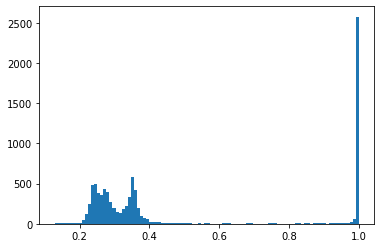

In [59]:
if __name__ == '__main__':
    main(train_df)

if CFG.epochs > 100:
    from IPython.display import clear_output  # セルの出力削除（1000epもログあると重すぎるので消す）
    clear_output()

In [60]:
#%debug

In [61]:
#=====

# Predict and submit

In [62]:
%reload_ext autoreload
%autoreload 2
from src import tta_util

In [63]:
@torch.inference_mode()  # pytorch >= 1.9
def inference(model, pth, test_loader, device, tta_transforms=None, tta_ops=[0]):
    if len(CFG.device_ids) > 1:
        model.load_state_dict(loadpth(pth))
    else:
        model.load_state_dict(torch.load(pth)['model'])
    model.eval().to(device)
    
    if len(CFG.device_ids) > 1:
        LOGGER.info(f"=> inference is_multiGPU {CFG.device_ids}")
        model = nn.DataParallel(model)  # make parallel
        cudnn.benchmark = True
    
    # ttach
    if tta_transforms is not None:
        model = tta.ClassificationTTAWrapper(model, tta_transforms)
    
    LOGGER.info(f"tta_ops: {str(tta_ops)}")
    preds = []
    preds2 = []  # for MultiOutput
    preds3 = []  # for MultiOutput2,3
    for i, (images, _, _,) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        outputs = None
        outputs2 = 0
        outputs3 = 0
        with torch.no_grad():
            
            for _ops in tta_ops:
                
                if "MultiOutput" in CFG.model_cls:
                    if (CFG.model_cls == "CustomModelMultiOutput2") or (CFG.model_cls == "CustomModelMultiOutput3"):
                        o, o2, o3 = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput2,3
                    else:
                        o, o2 = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput
                        o3 = 0
                else:
                    o = model( tta_util.tta_tensor(images, _ops) )  # 予測値の算出  for MultiOutput
                    o2, o3 = 0, 0
                
                if outputs is None:
                    outputs = o
                    outputs2 = o2
                    outputs3 = o3
                else:
                    outputs += o
                    outputs2 += o2
                    outputs3 += o3
        outputs /= len(tta_ops)
        outputs2 /= len(tta_ops)
        outputs3 /= len(tta_ops)
        
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        if "CustomModelMultiOutput" in CFG.model_cls:
            preds2.append(outputs2.argmax(1).cpu().detach().numpy())  # for MultiOutput
        if CFG.model_cls == "CustomModelMultiOutput2":
            preds3.append(outputs3.sigmoid().cpu().detach().numpy())  # for MultiOutput2
        elif CFG.model_cls == "CustomModelMultiOutput3":
            preds3.append(outputs3.argmax(1).cpu().detach().numpy())  # for MultiOutput3
    
    predictions = np.concatenate(preds)
    # for MultiOutput
    if len(preds2) == 0:
        predictions2 = None
    else:
        predictions2 = np.concatenate(preds2) 
    if len(preds3) == 0:
        predictions3 = None
    else:
        predictions3 = np.concatenate(preds3)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    #return predictions, predictions2
    return predictions, predictions2, predictions3  # for MultiOutput2,3

In [64]:
def main_test(test, pths, tta_transforms=None, transforms_type="valid", test_dataset=None, tta_ops=[0], is_cr=False):
    model = eval(CFG.model_cls)(CFG)
    if test_dataset is None:
        test_dataset = TrainDataset(test, 
                                    transforms=get_transforms(data=transforms_type),
                                    is_npy=CFG.is_npy,
                                    #add_ch_type=CFG.add_ch_type,
                                   )
    test_loader = DataLoader(test_dataset, 
                             batch_size=CFG.batch_size * 2, 
                             shuffle=False, 
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    predictions = None
    LOGGER.info(f'========== TEST ==========')  # for MultiOutput
    for i, pth in enumerate(pths):
        print("pth:", pth)
        
        #p, p2 = inference(model, pth, test_loader, device, tta_transforms, tta_ops=tta_ops)  # for MultiOutput
        p, p2, p3 = inference(model, pth, test_loader, device, tta_transforms, tta_ops=tta_ops)  # for MultiOutput2,3
        # 各foldの予測個別で持つ
        test[f'preds_fold{i}'] = p
        # for MultiOutput
        if "CustomModelMultiOutput" in CFG.model_cls:
            test[f'preds_freq_min//N_fold{i}'] = p2
            score2 = accuracy_score(test["freq_min//N"].to_numpy(), p2)
            LOGGER.info(f'freq_min//N {str(Path(pth).stem)} Accuracy: {score2:<.4f}')
            if is_cr:
                LOGGER.info(classification_report(test["freq_min//N"].to_numpy(), p2))
        if CFG.model_cls == "CustomModelMultiOutput2":
            test[f'preds_real_sim_fold{i}'] = p3
            score3 = get_score(test["real_sim"].to_numpy(), p3)
            LOGGER.info(f'real_sim {str(Path(pth).stem)} AUC: {score3:<.4f}')
        elif CFG.model_cls == "CustomModelMultiOutput3":
            test[f'preds_h0deg//10_fold{i}'] = p3
            #score3 = accuracy_score(test["h0deg//10"].to_numpy(), p3)  # testに h0deg//10 は無いのでコメントアウト
            #LOGGER.info(classification_report(test["h0deg//10"].to_numpy(), p3))  # testに h0deg//10 は無いのでコメントアウト
        
        if predictions is None:
            predictions = p
        else:
            predictions += p

    test['preds'] = predictions / len(pths)
    
    return test

In [65]:
# ttach param
# https://www.guruguru.science/competitions/17/discussions/4864ee81-6336-4cad-bb74-a4c9b46e6eb2/
tta_transforms = tta.Compose(
    [
        #tta.HorizontalFlip(),
        #tta.VerticalFlip(),
        #tta.Rotate90(angles=[0, 90, 180, 270]),  # 90度回転
        #tta.Scale(scales=[0.9, 1.1], interpolation="nearest"),  # 画像の大きさscales倍. h * scale_factor, w * scale_factor
        #tta.Add(values=[-1, 0, 1, 2]),  # 画素にfactorの値足す. x + value
        #tta.Multiply(factors=[0.9, 1, 1.1]),  # 画素をfactor倍. x * factor
        #tta.FiveCrops(crop_height=CFG.size//3, crop_width=CFG.size//3),  # 画像を5分割. crop_height: cropする画像の高さ. crop_width: cropする画像の幅
        #tta.Resize(sizes=[(224, 224), (384, 384)], original_size=(CFG.size, CFG.size), interpolation="nearest")  # 指定の大きさにリサイズ
    ]
)
tta_transforms = None

In [66]:
# ==========================================================
# valid inference
# ==========================================================
seed = CFG.seeds[0]
valid = pd.read_csv(OUTPUT_DIR + f"/folds_seed{seed}.csv")

# tta inference
score_list = []
pred_valid = pd.DataFrame()
for fold in CFG.trn_fold:
    print(f"===== valid fold{fold} =====")
    
    # model pths
    pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_score.pth"))
    #pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_loss.pth"))
    print(pths)
    
    valid_f = valid[valid.fold == fold]
    print(valid_f.shape)
    
    #valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", tta_ops=[0], is_cr=False)  # no tta
    #valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", tta_ops=[0,1], is_cr=False)  # orig+hflip
    #valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", tta_ops=[0,2], is_cr=False)  # orig+vflip
    valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", tta_ops=[0,1,2], is_cr=False)  # orig+hflip+vflip
    #valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", tta_ops=[0,1,2,3], is_cr=False)  # orig+hflip+vflip+(hflip+vflip)
    
    ## =============================
    ## tta alb
    ## =============================
    #valid_f_tta1 = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
    #valid_f_tta1 = valid_f_tta1.rename(columns={"preds": "preds_tta1"})
    #
    #valid_f = pd.merge(valid_f, valid_f_tta1[["id", "preds_tta1"]], on="id")
    #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_tta1"].to_numpy()) / 2.0
    ## =============================
    
    ## =============================
    ## tta Dataset
    ## =============================
    #_test_dataset = TrainDataset(valid_f, 
    #                             transforms=get_transforms(data="valid"),
    #                             #prob_spec_start_random=1.0,
    #                             #prob_vshift=1.0,  # CV悪化
    #                             prob_swap_nega=1.0,  # CV悪化
    #                             is_npy=CFG.is_npy,
    #                             add_ch_type=CFG.add_ch_type,
    #                           )
    #valid_f_ttaD = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", test_dataset=_test_dataset)
    #valid_f_ttaD = valid_f_ttaD.rename(columns={"preds": "preds_ttaD"})
    #
    #valid_f = pd.merge(valid_f, valid_f_ttaD[["id", "preds_ttaD"]], on="id")
    #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_ttaD"].to_numpy()) / 2.0
    ## =============================
    
    score = get_result(valid_f, preds_col="preds", add_info=f"TTA fold{fold} ")
    score_list.append(score)
    pred_valid = pd.concat([pred_valid, valid_f])
    
LOGGER.info(f"macro mean folds Score ± std: {str(round(np.mean(score_list), 4))} ± {str(round(np.std(score_list), 4))}")
tta_oof_score = get_result(pred_valid, preds_col="preds", add_info=f"TTA oof ")
pred_valid.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}_tta.csv', index=False)
display(pred_valid.head())

#if CFG.is_wandb:
#    # save log wandb
#    wandb.log({f"TTA oof Score": tta_oof_score})

===== valid fold0 =====
['./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold0_seed0_best_score.pth']
(1800, 38)


========== TEST ==========


pth: ./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████| 15/15 [00:08<00:00,  1.68it/s]
freq_min//N kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold0_seed0_best_score Accuracy: 0.1783
TTA fold0 Score: 0.8554


===== valid fold1 =====
['./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold1_seed0_best_score.pth']
(1800, 38)


========== TEST ==========


pth: ./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████| 15/15 [00:08<00:00,  1.68it/s]
freq_min//N kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold1_seed0_best_score Accuracy: 0.2211
TTA fold1 Score: 0.8703


===== valid fold2 =====
['./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold2_seed0_best_score.pth']
(1800, 38)


========== TEST ==========


pth: ./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████| 15/15 [00:08<00:00,  1.69it/s]
freq_min//N kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold2_seed0_best_score Accuracy: 0.2050
TTA fold2 Score: 0.8718


===== valid fold3 =====
['./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold3_seed0_best_score.pth']
(1800, 38)


========== TEST ==========


pth: ./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████| 15/15 [00:08<00:00,  1.68it/s]
freq_min//N kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold3_seed0_best_score Accuracy: 0.1972
TTA fold3 Score: 0.8474


===== valid fold4 =====
['./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold4_seed0_best_score.pth']
(1800, 38)


========== TEST ==========


pth: ./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████| 15/15 [00:08<00:00,  1.68it/s]
freq_min//N kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold4_seed0_best_score Accuracy: 0.1967
TTA fold4 Score: 0.8633
macro mean folds Score ± std: 0.8616 ± 0.0092
TTA oof Score: 0.8463


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
5   0197bacf8  316.482222  316.681667      360.0     4545.0  1.238168e+09   
12  02c478b09  462.168333  462.367778      360.0     4655.0  1.238168e+09   
17  047e6e2a3   72.943889   73.143333      360.0     4773.0  1.238168e+09   
18  0517ef7fe   99.727778   99.927222      360.0     4647.0  1.238171e+09   
32  09ecddbba  488.741111  488.940556      360.0     4600.0  1.238167e+09   

     H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
5   1.248583e+09         60558.0      360.0     4523.0  1.238182e+09   
12  1.248513e+09         36492.0      360.0     4625.0  1.238174e+09   
17  1.248583e+09         34177.0      360.0     4538.0  1.238168e+09   
18  1.248559e+09         31868.0      360.0     4719.0  1.238179e+09   
32  1.248532e+09         43189.0      360.0     4634.0  1.238166e+09   

     L1 time max  L1 max inteval  target  freq_min//10 freq_min//10_target  \
5   1.248555e+09         60558.0     1.0          31.0                31_1   
12  1.248543e+09         36492.0     1.0          46.0                46_1   
17  1.248565e+09         34177.0     1.0           7.0                 7_1   
18  1.248545e+09         31868.0     1.0           9.0                 9_1   
32  1.248533e+09         43189.0     1.0          48.0                48_1   

                                                 path  orig   h1_mean  \
5   /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.252390   
12  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.247005   
17  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.250768   
18  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.256312   
32  /workspace/g2net2/pyfstat_output/largekernel|p...   1.0  2.257586   

     l1_mean    h1_std    l1_std  freq_min//N  fold  sqrtSX  F0 type dir_name  \
5   2.253793  0.400924  0.401087          6.0     0     NaN NaN  NaN      NaN   
12  2.250381  0.398699  0.399798          9.0     0     NaN NaN  NaN      NaN   
17  2.253459  0.403756  0.401150          1.0     0     NaN NaN  NaN      NaN   
18  2.249809  0.401606  0.402489          1.0     0     NaN NaN  NaN      NaN   
32  2.257342  0.408922  0.412729          9.0     0     NaN NaN  NaN      NaN   

    F1  h0deg  h1_minstd  h1_maxstd  h1_stddiff  l1_minstd  l1_maxstd  \
5  NaN    NaN        NaN        NaN         NaN        NaN        NaN   
12 NaN    NaN        NaN        NaN         NaN        NaN        NaN   
17 NaN    NaN        NaN        NaN         NaN        NaN        NaN   
18 NaN    NaN        NaN        NaN         NaN        NaN        NaN   
32 NaN    NaN        NaN        NaN         NaN        NaN        NaN   

    l1_stddiff  h1_max/l1_max  real_sim  preds_fold0  preds_freq_min//N_fold0  \
5          NaN            NaN       NaN     0.998481                        5   
12         NaN            NaN       NaN     0.223637                        6   
17         NaN            NaN       NaN     0.999535                        3   
18         NaN            NaN       NaN     0.995478                        1   
32         NaN            NaN       NaN     0.999922                        9   

       preds  
5   0.998481  
12  0.223637  
17  0.999535  
18  0.995478  
32  0.999922

In [67]:
#%debug

In [68]:
#=====

['./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold0_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold1_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold2_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold3_seed0_best_score.pth', './output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold4_seed0_best_score.pth']


========== TEST ==========


pth: ./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold0_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████| 63/63 [00:38<00:00,  1.65it/s]
freq_min//N kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold0_seed0_best_score Accuracy: 0.1763


pth: ./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold1_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████| 63/63 [00:37<00:00,  1.66it/s]
freq_min//N kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold1_seed0_best_score Accuracy: 0.1918


pth: ./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold2_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████| 63/63 [00:37<00:00,  1.66it/s]
freq_min//N kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold2_seed0_best_score Accuracy: 0.1821


pth: ./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold3_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████| 63/63 [00:38<00:00,  1.65it/s]
freq_min//N kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold3_seed0_best_score Accuracy: 0.1920


pth: ./output/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep/kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold4_seed0_best_score.pth


tta_ops: [0, 1, 2]
100%|████████| 63/63 [00:38<00:00,  1.65it/s]
freq_min//N kqi_3090_ex075_v2_tta_v2_pseudo_hvflip_lb0771_1000_simall_100ep_fold4_seed0_best_score Accuracy: 0.1739


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w   L1 time min  \
0  1.248567e+09         43102.0      360.0     4566.0  1.238169e+09   
1  1.248520e+09         42746.0      360.0     4650.0  1.238170e+09   
2  1.248535e+09         55878.0      360.0     4633.0  1.238172e+09   
3  1.248536e+09         48020.0      360.0     4621.0  1.238167e+09   
4  1.248535e+09         45246.0      360.0     4366.0  1.238167e+09   

    L1 time max  L1 max inteval    target  \
0  1.248561e+09         43102.0  0.273515   
1  1.248537e+09         42746.0  0.370386   
2  1.248567e+09         55878.0  0.270205   
3  1.248537e+09         48020.0  0.464231   
4  1.248543e+09         45246.0  0.357578   

                                                path  orig  freq_min//10  \
0  /workspace/g2net2/pyfstat_output/largekernel|p...     1          30.0   
1  /workspace/g2net2/pyfstat_output/largekernel|p...     1          12.0   
2  /workspace/g2net2/pyfstat_output/largekernel|p...     1          19.0   
3  /workspace/g2net2/pyfstat_output/largekernel|p...     1           9.0   
4  /workspace/g2net2/pyfstat_output/largekernel|p...     1          46.0   

    h1_mean   l1_mean    h1_std    l1_std     h1_minstd     h1_maxstd  \
0  2.251338  2.247327  0.397542  0.397476  1.058791e-22  1.058791e-22   
1  2.250531  2.253083  0.399520  0.399918  1.058791e-22  1.058791e-22   
2  2.249787  2.250360  0.399082  0.401004  1.058791e-22  1.058791e-22   
3  2.251309  2.250812  0.399954  0.399532  1.058791e-22  1.058791e-22   
4  2.250533  2.250065  0.402394  0.400455  1.058791e-22  1.058791e-22   

   h1_stddiff     l1_minstd     l1_maxstd  l1_stddiff  h1_max/l1_max  \
0         0.0  1.058791e-22  1.058791e-22         0.0       1.085967   
1         0.0  1.058791e-22  1.058791e-22         0.0       0.971284   
2         0.0  1.058791e-22  1.058791e-22         0.0       1.037622   
3         0.0  1.058791e-22  1.058791e-22         0.0       1.025819   
4         0.0  1.058791e-22  1.058791e-22         0.0       0.976649   

   real_sim  freq_min//N  h0deg//10  preds_fold0  preds_freq_min//N_fold0  \
0         0          6.0          0     0.194136                        6   
1         0          2.0          0     0.254134                        2   
2         0          3.0          0     0.235807                        6   
3         0          1.0          0     0.457984                        2   
4         0          9.0          0     0.388933                        1   

   preds_fold1  preds_freq_min//N_fold1  preds_fold2  preds_freq_min//N_fold2  \
0     0.290221                        7     0.274283                        6   
1     0.438633                        1     0.343783                        1   
2     0.262099                        7     0.261545                        7   
3     0.473085                        3     0.549089                        2   
4     0.395020                        1     0.283111                        6   

   preds_fold3  preds_freq_min//N_fold3  preds_fold4  preds_freq_min//N_fold4  \
0     0.259522                        7     0.349413                        7   
1     0.412985                        1     0.402395                        7   
2     0.241647                        7     0.349929                        7   
3     0.447199                        2     0.393799                        7   
4     0.367557                        1     0.353270                        7   

      preds  
0  0.273515  
1  0.370386  
2  0.270205  
3  0.464231  
4  0.357578

target range [0.037550, 0.999954]


id    target
0     00054c878  0.273515
1     0007285a3  0.370386
2     00076c5a6  0.270205
3     001349290  0.464231
4     001a52e92  0.357578
...         ...       ...
7970  ffbce04ef  0.992622
7971  ffc2d976b  0.262071
7972  ffc905909  0.244082
7973  ffe276f3e  0.300254
7974  fffa17f67  0.258566

[7975 rows x 2 columns]

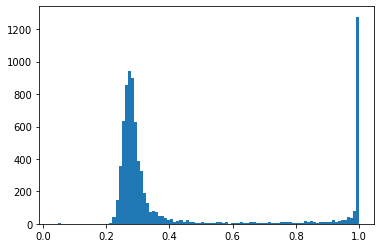

In [69]:
if IS_MAKE_SUB:
    # model pths
    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
    print(pths)
    
    # 'h0deg//10'列無いとエラーになるので入れとく
    test_df['h0deg//10'] = 0

    # ==========================================================
    # test inference
    # ==========================================================
    #submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")
    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", tta_ops=[0,1,2])

    ## =============================
    ## tta alb
    ## =============================
    #submit_tta1 = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
    #submit_tta1 = submit_tta1.rename(columns={"preds": "preds_tta1"})
    #
    #submit = pd.merge(submit, submit_tta1[["id", "preds_tta1"]], on="id")
    #submit["preds"] = (submit["preds"].to_numpy() + submit["preds_tta1"].to_numpy()) / 2.0
    ## =============================

    submit["target"] = submit["preds"].to_numpy()
    display(submit.head())
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test.csv', index=False)
    
    submit = submit[["id", "target"]]
    print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))

    # Write prediction
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv', index=False)
    display(submit)

    plt.hist(submit["target"], bins=100)
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()

In [70]:
if CFG.is_wandb:
    wandb.finish()

In [71]:
## submitファイル連結
#if IS_MAKE_SUB:
#    
#    # シュミレーションデータのsubmitファイル
#    _name = CFG.name.replace("_real", "_sim")
#    sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_submission.csv'
#    
#    if os.path.isfile(sim_csv):
#        submit_real = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv')
#        submit_sim = pd.read_csv(sim_csv)
#        submit = pd.concat([submit_sim, submit_real])
#        
#        # 行の順番をtest_dfの順番にする
#        test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
#        submit = pd.merge(test_df[["id"]], submit, on="id")
#        
#        submit = submit[["id", "target"]]
#        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))
#
#        # Write prediction
#        submit.to_csv(OUTPUT_DIR + f'/{CFG.name.split("_real")[0]}_sim_real_submission.csv', index=False)
#        display(submit)
#
#        plt.hist(submit["target"], bins=100)
#        plt.show()
#        plt.clf()  # メモリ解放
#        plt.close()

# Stacking

In [72]:
#### stacking用にtest set全体で推論
#test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
#test_df["target"] = 0.5
#if cfg_is_npy:
#    test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
#else:
#    test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
#    
#if IS_MAKE_SUB:
#    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
#    
#    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")
#
#    submit["target"] = submit["preds"].to_numpy()
#    display(submit.head())
#    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv', index=False)

In [73]:
import joblib
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


def table_train_fn(df, feature_cols, target_col, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    lgb_params = {
            "objective": "binary",
            "learning_rate": 0.03,
            "n_estimators": 100_000,
        }
    
    Y_pred = np.zeros((len(df)))

    for i in tqdm(CFG.seeds):
        print(f"------------ seed:{i} ------------")
        set_seed(seed=i)
        folds = df.copy()

        for j in range(CFG.n_fold):
            print(f"------------ fold:{j} ------------")

            train = folds[folds["fold"] != j]
            val = folds[folds["fold"] == j]
            val_idx = val.index
            
            X_train, X_val = train[feature_cols], val[feature_cols]
            y_train, y_val = train[target_col], val[target_col]
            X_train, X_val = X_train.values, X_val.values
            y_train, y_val = y_train.values, y_val.values

            ### lgb.LGBMClassifier
            #model = lgb.LGBMClassifier(random_state=i, **lgb_params)
            #model.fit(X_train, y_train,
            #          eval_set=[(X_val, y_val)],
            #          eval_metric="error",
            #          early_stopping_rounds=100,
            #          verbose=-1,
            #         )
            
            ### RandomForestClassifier
            #model = RandomForestClassifier(random_state=i)
            #model = model.fit(X_train, y_train)
            
            ### LogisticRegression
            model = LogisticRegression(random_state=i)
            model = model.fit(X_train, y_train)
            
            pred = model.predict_proba(X_val) / len(CFG.seeds)
            Y_pred[val_idx] += pred[:,1]
            
            joblib.dump(model, out_dir + f"/model_seed_{i}_fold_{j}_{target_col}.jlb", compress=True)

    folds["pred"] = Y_pred
    print("oof score:", get_score(folds[target_col].values, folds["pred"].values))
    
    folds.to_csv(out_dir + f"/{target_col}_oof.csv", index=False)
    
    return folds

def table_test_fn(df, feature_cols, target_col, out_dir, model_paths):
    os.makedirs(out_dir, exist_ok=True)
    X = df[feature_cols]
    Y_pred = np.zeros((len(df)))
    for m_p in sorted(model_paths):
        model = joblib.load(m_p)
        
        ### LogisticRegression
        print("model.coef_:", model.coef_)
        
        pred = model.predict_proba(X) / len(model_paths)
        Y_pred += pred[:,1]
    df[target_col] = Y_pred
    df[["id", "target"]].to_csv(out_dir + f"/{target_col}_sub.csv", index=False)
    return df


#### train
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_oof_df_seed{CFG.seeds[0]}.csv'
#if os.path.isfile(sim_csv):
#    sim_oof = pd.read_csv(sim_csv)
#    real_oof = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{CFG.seeds[0]}.csv')
#    stacking_oof = pd.merge(real_oof[["id", "target", "fold", "preds"]], sim_oof[["id", "preds"]], on="id")
#    stacking_oof = stacking_oof.rename(columns={"preds_x":'real_p', "preds_y":'sim_p'})
#    #display(stacking_oof)
#    _ = table_train_fn(stacking_oof, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking")
#
#### test
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_test_all.csv'
#if os.path.isfile(sim_csv):
#    sim_sub = pd.read_csv(sim_csv)
#    real_sub = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv')
#    stacking_sub = pd.merge(real_sub[["id", "target"]], sim_sub[["id", "target"]], on="id")
#    stacking_sub = stacking_sub.rename(columns={"target_x":'real_p', "target_y":'sim_p'})
#    stacking_sub = table_test_fn(stacking_sub, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking", 
#                                 glob.glob(OUTPUT_DIR + "/stacking/*.jlb"))
#    display(stacking_sub)
#    plt.hist(stacking_sub["target"], bins=100)
#    plt.show()
#    plt.clf()  # メモリ解放
#    plt.close()